In [38]:
# ================================================================================
# ИМПОРТЫ
# ================================================================================

# Базовые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import time
import json

warnings.filterwarnings('ignore')

# Sklearn - разделение данных
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    RandomizedSearchCV
)

# Sklearn - предобработка данных
from sklearn.preprocessing import (
    LabelEncoder,
    RobustScaler,
    OneHotEncoder,
    make_scorer
)

# Sklearn - композиция и pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sklearn - модели классификации
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)

# Sklearn - метрики
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

ImportError: cannot import name 'make_scorer' from 'sklearn.preprocessing' (/media/user/Programs/C/Курс 4/Диплом/Research/.venv/lib/python3.13/site-packages/sklearn/preprocessing/__init__.py)

In [ ]:
# Установка statsmodels для анализа мультиколлинеарности
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])
    from statsmodels.stats.outliers_influence import variance_inflation_factor



In [39]:
# Use local data directory instead of downloading from Kaggle

path = "data"

print("Path to dataset files:", path)

Path to dataset files: data


In [40]:
# List files in the dataset directory
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print('CSV files in dataset:', csv_files)

CSV files in dataset: ['34_3-2 S.csv', '15_9_14_well.csv', '31_2-21 S.csv', '35_6_2_S_well.csv', '31_6-8.csv', '25_11_24_well.csv', '31_2-10.csv', '15_9-23.csv', '34_6_1_S_well.csv', '35_9_8_well.csv', '25_10-9.csv', '34_10_16_R_well.csv', '17_4-1.csv', '25_10_10_well.csv', '29_3_1_well.csv', '16_7-6.csv', '16_2-7.csv', '35_9-7.csv', '31_6-5.csv', '34_3_3_A_well.csv', '25_5_3_well.csv']


In [41]:
# Dictionary to store columns for each file
columns_dict = {}

# Read columns from each file
for file in csv_files:
    file_path = os.path.join(path, file)
    try:
        df = pd.read_csv(file_path)
        columns_dict[file] = set(df.columns)
    except Exception as e:
        print(f'Error reading {file}: {e}')

# Find common columns across all files
all_columns = set()
for columns in columns_dict.values():
    all_columns.update(columns)

print('Total unique columns across all files:', len(all_columns))
print('All unique columns:', sorted(list(all_columns)))

# Find common columns across all files
common_columns = set(list(columns_dict.values())[0])
for columns in columns_dict.values():
    common_columns = common_columns.intersection(columns)

print('\nCommon columns across all files:', sorted(list(common_columns)))

# Find columns that are not common
unique_columns = {}
for file, columns in columns_dict.items():
    unique_columns[file] = columns - common_columns

print('\nUnique columns in each file:')
for file, cols in unique_columns.items():
    if cols:
        print(f'{file}: {list(cols)}')
    else:
        print(f'{file}: No unique columns')

Total unique columns across all files: 31
All unique columns: ['BS', 'CALI', 'DCAL', 'DEPT', 'DEPTH_MD', 'DRHO', 'DTC', 'DTS', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORMATION', 'GR', 'GROUP', 'MUDWEIGHT', 'NPHI', 'PEF', 'RDEP', 'RHOB', 'RMED', 'RMIC', 'ROP', 'ROPA', 'RSHA', 'RXO', 'SGR', 'SP', 'Unnamed: 0', 'WELL', 'X_LOC', 'Y_LOC', 'Z_LOC']

Common columns across all files: ['BS', 'CALI', 'DEPTH_MD', 'DRHO', 'DTC', 'GR', 'NPHI', 'PEF', 'RDEP', 'RHOB', 'RMED', 'RSHA', 'SP', 'X_LOC', 'Y_LOC', 'Z_LOC']

Unique columns in each file:
34_3-2 S.csv: ['FORCE_2020_LITHOFACIES_LITHOLOGY', 'RXO', 'SGR', 'DTS', 'GROUP', 'FORMATION', 'DCAL', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 'ROP', 'WELL', 'MUDWEIGHT', 'ROPA', 'RMIC']
15_9_14_well.csv: ['RXO', 'SGR', 'DTS', 'GROUP', 'FORMATION', 'DCAL', 'ROP', 'WELL', 'MUDWEIGHT', 'ROPA', 'RMIC']
31_2-21 S.csv: ['FORCE_2020_LITHOFACIES_LITHOLOGY', 'RXO', 'SGR', 'DTS', 'GROUP', 'FORMATION', 'DCAL', 'FORCE_2020_LITHOFACIES_CONF

## Анализ структуры данных скважин

На основе анализа всех CSV файлов в датасете, можно сделать следующие выводы:

### Общие столбцы (16 столбцов присутствуют во всех файлах):
- **BS** - Bit Size (размер бита)
- **CALI** - Caliper (калибр, измерение диаметра ствола скважины)
- **DEPTH_MD** - Measured Depth (измеренная глубина)
- **DRHO** - Difference in Density (разница в плотности)
- **DTC** - Delta-T Compressional (интервальное время сжатия)
- **GR** - Gamma Ray (гамма-каротаж)
- **NPHI** - Neutron Porosity (нейтронная пористость)
- **PEF** - Photoelectric Factor (фотоэлектрический фактор)
- **RDEP** - Deep Resistivity (глубокое сопротивление)
- **RHOB** - Bulk Density (объемная плотность)
- **RMED** - Medium Resistivity (среднее сопротивление)
- **RSHA** - Shallow Resistivity (мелкое сопротивление)
- **SP** - Spontaneous Potential (спонтанный потенциал)
- **X_LOC** - X Coordinate (координата X)
- **Y_LOC** - Y Coordinate (координата Y)
- **Z_LOC** - Z Coordinate (координата Z)

### Уникальные столбцы:
Большинство файлов имеют дополнительные столбцы, включая:
- **FORMATION** - Геологическая формация
- **GROUP** - Группа формаций
- **MUDWEIGHT** - Вес бурового раствора
- **DTS** - Delta-T Shear (интервальное время сдвига)
- **RXO** - Resistivity of Flush Zone (сопротивление промытой зоны)
- **SGR** - Spectral Gamma Ray (спектральный гамма-каротаж)
- **ROP** - Rate of Penetration (скорость бурения)
- **DCAL** - Differential Caliper (дифференциальный калибр)
- **RMIC** - Micronormal Resistivity (микронормальное сопротивление)
- **WELL** - Идентификатор скважины
- **ROPA** - Rate of Penetration Average (усредненная скорость бурения)

Два файла (31_6-5.csv и 31_6-8.csv) имеют особую структуру:
- Столбец **DEPT** вместо **DEPTH_MD** (возможно, это то же самое измерение глубины)
- Столбец **Unnamed: 0** (обычно это индекс строки)
- Отсутствие столбцов **WELL**, **FORMATION**, **GROUP**, **MUDWEIGHT**, **DTS**, **SGR**, **ROP**, **DCAL**, **RMIC**, **ROPA**
- Наличие столбцов **FORCE_2020_LITHOFACIES_CONFIDENCE** и **FORCE_2020_LITHOFACIES_LITHOLOGY** (классификация литологии с уровнем достоверности)

### Возможность изучения одной скважины на основе другой:

Да, возможно частично изучать одну скважину на основе данных другой скважины, поскольку:

1. **Общие параметры**: Все скважины имеют 16 общих измерений, которые обеспечивают фундаментальную информацию о геологических характеристиках.

2. **Сходные физические свойства**: Общие столбцы описывают схожие физические свойства горных пород (плотность, пористость, сопротивление, гамма-излучение), которые могут следовать схожим паттернам в геологически схожих регионах.

3. **Пространственные данные**: Наличие координат (X_LOC, Y_LOC, Z_LOC) позволяет анализировать пространственные корреляции между скважинами.

4. **Ограниченные различия**: Некоторые скважины содержат дополнительные параметры, которые могут быть недоступны в других, но базовые измерения остаются схожими.

Однако, есть важные ограничения:

1. **Различия в структуре**: Две скважины (31_6-5 и 31_6-8) имеют значительно отличающуюся структуру данных, включая отсутствие информации о скважине и формации.

2. **Отсутствие ключевых данных**: Некоторые скважины могут не содержать важные параметры, такие как литологическая классификация (FORCE_2020_LITHOFACIES_LITHOLOGY), которая присутствует только в части файлов.

3. **Различия в геологических условиях**: Разные скважины могут проходить через различные геологические формации, что влияет на свойства измеряемых параметров.

Таким образом, хотя есть основа для переноса знаний между скважинами, важно учитывать структурные различия и потенциальные различия в геологических условиях при анализе и моделировании.

In [42]:
# Обновленное объединение файлов для задачи прогнозирования литологии
# Исключаем 31_6-5.csv и 31_6-8.csv
files_to_include = [f for f in os.listdir(path) if f.endswith('.csv') and f not in ['31_6-5.csv', '31_6-8.csv']]

# Список для хранения датафреймов
dfs = []

for file in files_to_include:
    file_path = os.path.join(path, file)
    df = pd.read_csv(file_path)
    
    # Проверка наличия необходимых столбцов для задачи прогнозирования литологии
    # Добавляем RDEP, SP и RSHA к основным столбцам (все они присутствуют во всех файлах)
    required_cols = ['FORCE_2020_LITHOFACIES_LITHOLOGY', 'GR', 'RHOB', 'NPHI', 'DTC', 'RDEP', 'SP', 'RSHA']
    if all(col in df.columns for col in required_cols):
        # Добавление столбца с именем скважины для идентификации
        if 'WELL' in df.columns:
            df['WELL_NAME'] = df['WELL']
        else:
            df['WELL_NAME'] = file
        
        # Выбор только нужных столбцов
        df = df[required_cols + ['WELL_NAME']]
        dfs.append(df)

# Объединение всех датафреймов
combined_df = pd.concat(dfs, ignore_index=True)

print(f'Обновленный объединенный датасет содержит {len(combined_df)} строк и {len(combined_df.columns)} столбцов')
print(f'Количество уникальных скважин в объединенном датасете: {combined_df["WELL_NAME"].nunique()}')
print(f'Распределение по скважинам:')
print(combined_df["WELL_NAME"].value_counts())

# Показать первые несколько строк объединенного датасета
print('\nПервые 5 строк объединенного датасета:')
print(combined_df.head())

# Проверить пропущенные значения
print('\nКоличество пропусков в каждом столбце:')
print(combined_df.isnull().sum())

Обновленный объединенный датасет содержит 100793 строк и 9 столбцов
Количество уникальных скважин в объединенном датасете: 9
Распределение по скважинам:
WELL_NAME
17/4-1       17271
34/3-2 S     12216
16/2-7       11683
15/9-23      11063
25/10-9      10788
35/9-7       10677
16/7-6       10222
31/2-10       9033
31/2-21 S     7840
Name: count, dtype: int64

Первые 5 строк объединенного датасета:
   FORCE_2020_LITHOFACIES_LITHOLOGY          GR  RHOB  NPHI         DTC  \
0                             65000  113.104942   NaN   NaN  131.869385   
1                             65000  130.444839   NaN   NaN  134.873535   
2                             65000  139.467636   NaN   NaN  136.471268   
3                             65000  142.260132   NaN   NaN  136.931976   
4                             65000  136.774857   NaN   NaN  136.873383   

       RDEP  SP  RSHA WELL_NAME  
0  1.034647 NaN   NaN  34/3-2 S  
1  1.029853 NaN   NaN  34/3-2 S  
2  1.004122 NaN   NaN  34/3-2 S  
3  0.987292 N

In [43]:
# Очистка до EDA
# Удаление дубликатов
print(f'Количество строк до удаления дубликатов: {len(combined_df)}')
rows_before = len(combined_df)
combined_df = combined_df.drop_duplicates()
print(f'Количество строк после удаления дубликатов: {len(combined_df)}')
print(f'Удалено дубликатов: {rows_before - len(combined_df)}')

Количество строк до удаления дубликатов: 100793
Количество строк после удаления дубликатов: 100793
Удалено дубликатов: 0


In [44]:
# Удаление столбцов с более чем 50% пропусков
print('Процент пропусков в каждом столбце:')
missing_percentages = (combined_df.isnull().sum() / len(combined_df)) * 100
print(missing_percentages)

# Определяем столбцы с более чем 50% пропусков
columns_to_drop = missing_percentages[missing_percentages > 50].index.tolist()
print(f'\nСтолбцы с более чем 50% пропусков: {columns_to_drop}')

# Удаляем эти столбцы
if columns_to_drop:
    combined_df = combined_df.drop(columns=columns_to_drop)
    print(f'\nСтолбцы после удаления: {list(combined_df.columns)}')
else:
    print('\nНет столбцов с более чем 50% пропусков')

Процент пропусков в каждом столбце:
FORCE_2020_LITHOFACIES_LITHOLOGY     0.000000
GR                                   0.000000
RHOB                                 6.141299
NPHI                                11.229947
DTC                                  0.450428
RDEP                                 0.000000
SP                                  71.777802
RSHA                                81.580070
WELL_NAME                            0.000000
dtype: float64

Столбцы с более чем 50% пропусков: ['SP', 'RSHA']

Столбцы после удаления: ['FORCE_2020_LITHOFACIES_LITHOLOGY', 'GR', 'RHOB', 'NPHI', 'DTC', 'RDEP', 'WELL_NAME']


In [45]:
# Преобразование категориальных данных в тип category
# В нашем случае FORCE_2020_LITHOFACIES_LITHOLOGY - это категориальная переменная
if 'FORCE_2020_LITHOFACIES_LITHOLOGY' in combined_df.columns:
    combined_df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = combined_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].astype('category')
    print('Столбец FORCE_2020_LITHOFACIES_LITHOLOGY преобразован в тип category')
    
# WELL_NAME также можно считать категориальной переменной
if 'WELL_NAME' in combined_df.columns:
    combined_df['WELL_NAME'] = combined_df['WELL_NAME'].astype('category')
    print('Столбец WELL_NAME преобразован в тип category')

print('\nТипы данных в датасете:')
print(combined_df.dtypes)

Столбец FORCE_2020_LITHOFACIES_LITHOLOGY преобразован в тип category
Столбец WELL_NAME преобразован в тип category

Типы данных в датасете:
FORCE_2020_LITHOFACIES_LITHOLOGY    category
GR                                   float64
RHOB                                 float64
NPHI                                 float64
DTC                                  float64
RDEP                                 float64
WELL_NAME                           category
dtype: object


In [46]:
# Проверка опечаток в столбцах
# Для числовых столбцов проверим уникальные значения и статистику
numeric_columns = combined_df.select_dtypes(include=[np.number]).columns.tolist()
print('Статистика для числовых столбцов:')
print(combined_df[numeric_columns].describe())

Статистика для числовых столбцов:
                  GR          RHOB          NPHI            DTC           RDEP
count  100793.000000  94603.000000  89474.000000  100339.000000  100793.000000
mean       70.524258      2.331008      0.320665     108.795454      28.093654
std        37.238531      0.206957      0.127854      30.248587     105.552489
min         1.132300      1.127937     -0.015035      48.268532       0.037163
25%        46.831429      2.187116      0.225147      82.809410       0.828335
50%        70.936447      2.360354      0.326571     106.071526       1.364411
75%        94.682205      2.495778      0.417969     137.749435       2.873766
max      1141.292114      3.209886      0.906257     178.817993    1755.531006


In [47]:
# Проверим уникальные значения в категориальных столбцах
categorical_columns = combined_df.select_dtypes(include=['category']).columns.tolist()
for col in categorical_columns:
    print(f'\nУникальные значения в столбце {col}:')
    print(combined_df[col].value_counts())


Уникальные значения в столбце FORCE_2020_LITHOFACIES_LITHOLOGY:
FORCE_2020_LITHOFACIES_LITHOLOGY
65000    58401
30000    10566
65030     8181
70000     8104
88000     6498
80000     4198
70032     2905
99000      895
86000      597
74000      269
90000      179
Name: count, dtype: int64

Уникальные значения в столбце WELL_NAME:
WELL_NAME
17/4-1       17271
34/3-2 S     12216
16/2-7       11683
15/9-23      11063
25/10-9      10788
35/9-7       10677
16/7-6       10222
31/2-10       9033
31/2-21 S     7840
Name: count, dtype: int64


In [48]:
# EDA: Проверка категориального признака на числовость
# Проверим, является ли категориальный признак числовым

if 'FORCE_2020_LITHOFACIES_LITHOLOGY' in combined_df.columns:
    lithology_col = combined_df['FORCE_2020_LITHOFACIES_LITHOLOGY']
    print('Уникальные значения в столбце FORCE_2020_LITHOFACIES_LITHOLOGY:')
    print(lithology_col.value_counts())
    
    # Проверим, являются ли значения числовыми
    print('\nТип данных столбца:', lithology_col.dtype)
    print('Количество уникальных значений:', lithology_col.nunique())
    
    # Проверим, есть ли числовая закономерность в значениях
    unique_values = lithology_col.cat.categories.values if hasattr(lithology_col, 'cat') else lithology_col.unique()
    print('Уникальные значения:', sorted(unique_values))
    
    # Проверим, можно ли интерпретировать значения как числа
    try:
        numeric_values = pd.to_numeric(unique_values, errors='coerce')
        if not numeric_values.isna().any():
            print('Значения можно интерпретировать как числа')
            print('Статистика числовых значений:')
            print(pd.Series(numeric_values).describe())
        else:
            print('Значения нельзя интерпретировать как числа')
    except:
        print('Ошибка при попытке интерпретации значений как чисел')

Уникальные значения в столбце FORCE_2020_LITHOFACIES_LITHOLOGY:
FORCE_2020_LITHOFACIES_LITHOLOGY
65000    58401
30000    10566
65030     8181
70000     8104
88000     6498
80000     4198
70032     2905
99000      895
86000      597
74000      269
90000      179
Name: count, dtype: int64

Тип данных столбца: category
Количество уникальных значений: 11
Уникальные значения: [np.int64(30000), np.int64(65000), np.int64(65030), np.int64(70000), np.int64(70032), np.int64(74000), np.int64(80000), np.int64(86000), np.int64(88000), np.int64(90000), np.int64(99000)]
Ошибка при попытке интерпретации значений как чисел


In [49]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100793 entries, 0 to 100792
Data columns (total 7 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   FORCE_2020_LITHOFACIES_LITHOLOGY  100793 non-null  category
 1   GR                                100793 non-null  float64 
 2   RHOB                              94603 non-null   float64 
 3   NPHI                              89474 non-null   float64 
 4   DTC                               100339 non-null  float64 
 5   RDEP                              100793 non-null  float64 
 6   WELL_NAME                         100793 non-null  category
dtypes: category(2), float64(5)
memory usage: 4.0 MB


Процент пропусков в каждом столбце:
FORCE_2020_LITHOFACIES_LITHOLOGY     0.000000
GR                                   0.000000
RHOB                                 6.141299
NPHI                                11.229947
DTC                                  0.450428
RDEP                                 0.000000
WELL_NAME                            0.000000
dtype: float64

Количество пропущенных значений:
FORCE_2020_LITHOFACIES_LITHOLOGY        0
GR                                      0
RHOB                                 6190
NPHI                                11319
DTC                                   454
RDEP                                    0
WELL_NAME                               0
dtype: int64


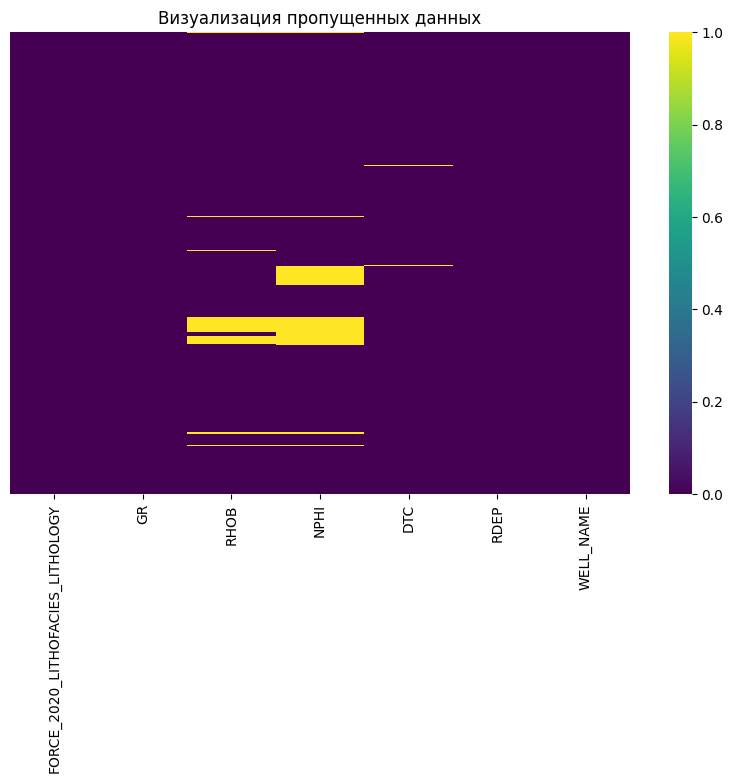

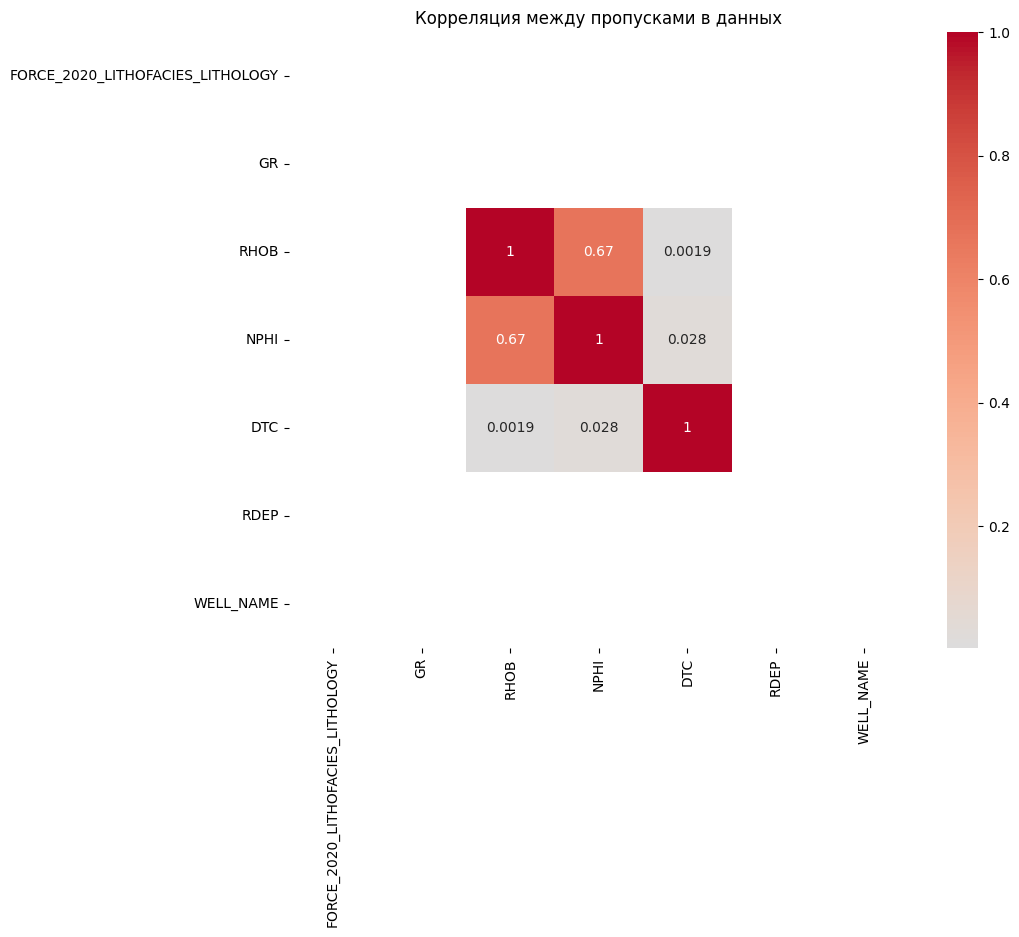

In [50]:
# EDA: Анализ пропущенных данных
# Количественный анализ пропущенных данных

print('Процент пропусков в каждом столбце:')
missing_percentages = (combined_df.isnull().sum() / len(combined_df)) * 100
print(missing_percentages)

print('\nКоличество пропущенных значений:')
print(combined_df.isnull().sum())

# Визуализация пропущенных данных
plt.figure(figsize=(10, 6))
sns.heatmap(combined_df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Визуализация пропущенных данных')
plt.show()

# Проверим, есть ли корреляция между пропусками
missing_data = combined_df.isnull()
plt.figure(figsize=(10, 8))
sns.heatmap(missing_data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция между пропусками в данных')
plt.show()

Анализ причин пропусков:

Процент пропусков по скважинам:
           FORCE_2020_LITHOFACIES_LITHOLOGY   GR       RHOB       NPHI  \
WELL_NAME                                                                
15/9-23                                 0.0  0.0   0.488114   0.235018   
16/2-7                                  0.0  0.0   4.014380   3.928785   
16/7-6                                  0.0  0.0   0.000000   0.000000   
17/4-1                                  0.0  0.0  29.118175  60.268658   
25/10-9                                 0.0  0.0   1.909529   1.594364   
31/2-10                                 0.0  0.0   0.000000   0.000000   
31/2-21 S                               0.0  0.0   0.573980   0.357143   
34/3-2 S                                0.0  0.0   2.685003   1.350688   
35/9-7                                  0.0  0.0   0.552590   0.561956   

                DTC  RDEP  WELL_NAME  
WELL_NAME                             
15/9-23    1.102775   0.0        0.0  
16/2-7    

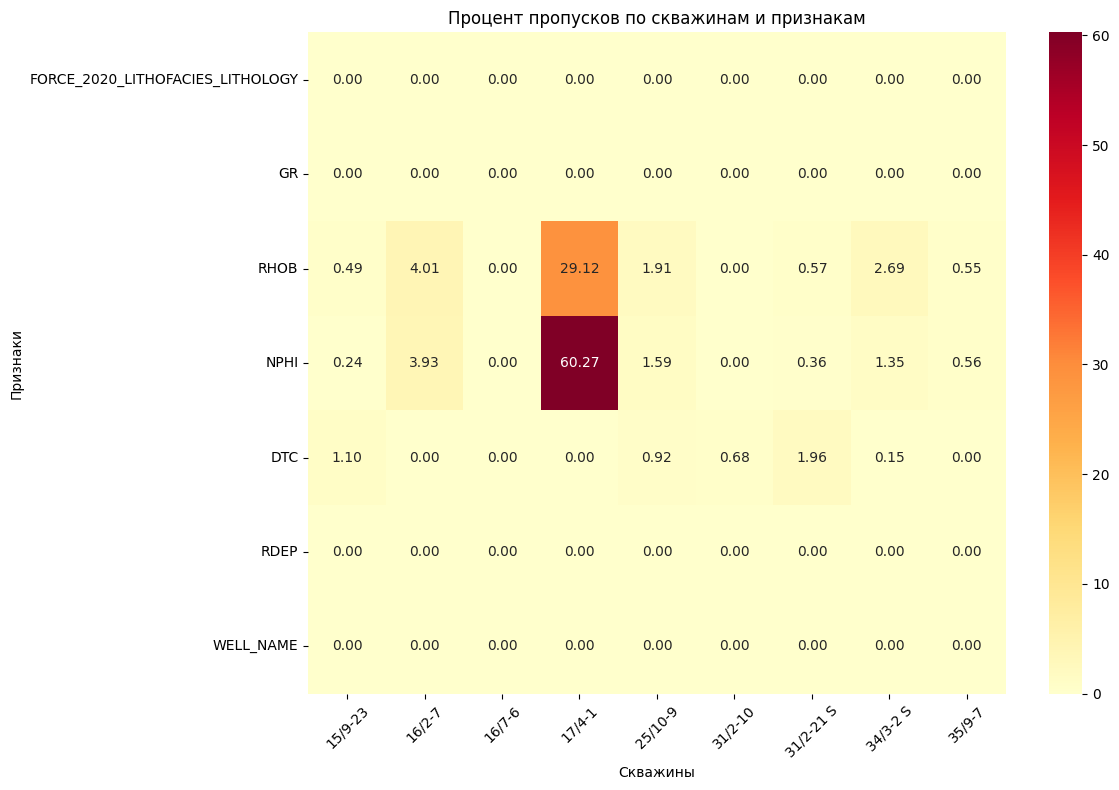

In [51]:
# Анализ причин пропусков

print('Анализ причин пропусков:')

# Проверим, есть ли связь между пропусками и скважинами
if 'WELL_NAME' in combined_df.columns:
    well_missing = combined_df.groupby('WELL_NAME').apply(lambda x: x.isnull().mean() * 100)
    print('\nПроцент пропусков по скважинам:')
    print(well_missing)
    
    # Визуализация пропусков по скважинам
    plt.figure(figsize=(12, 8))
    sns.heatmap(well_missing.T, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Процент пропусков по скважинам и признакам')
    plt.ylabel('Признаки')
    plt.xlabel('Скважины')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

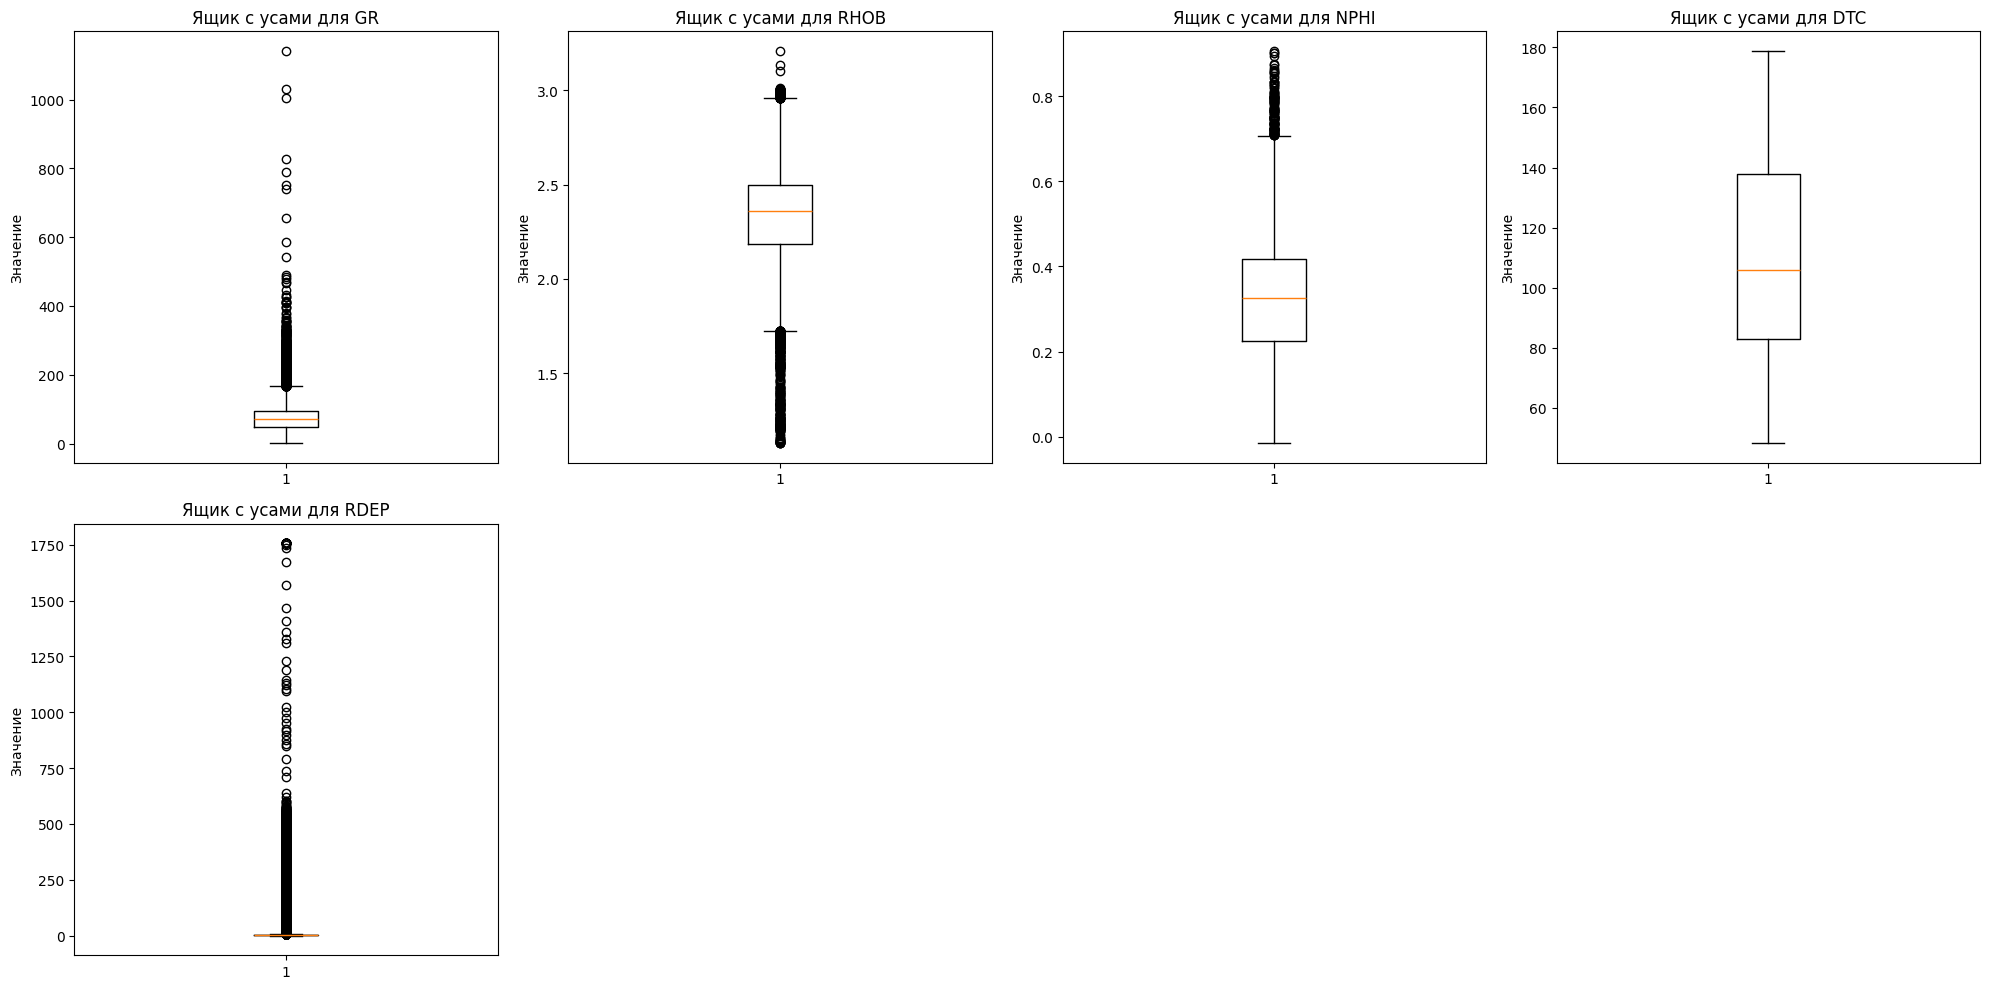

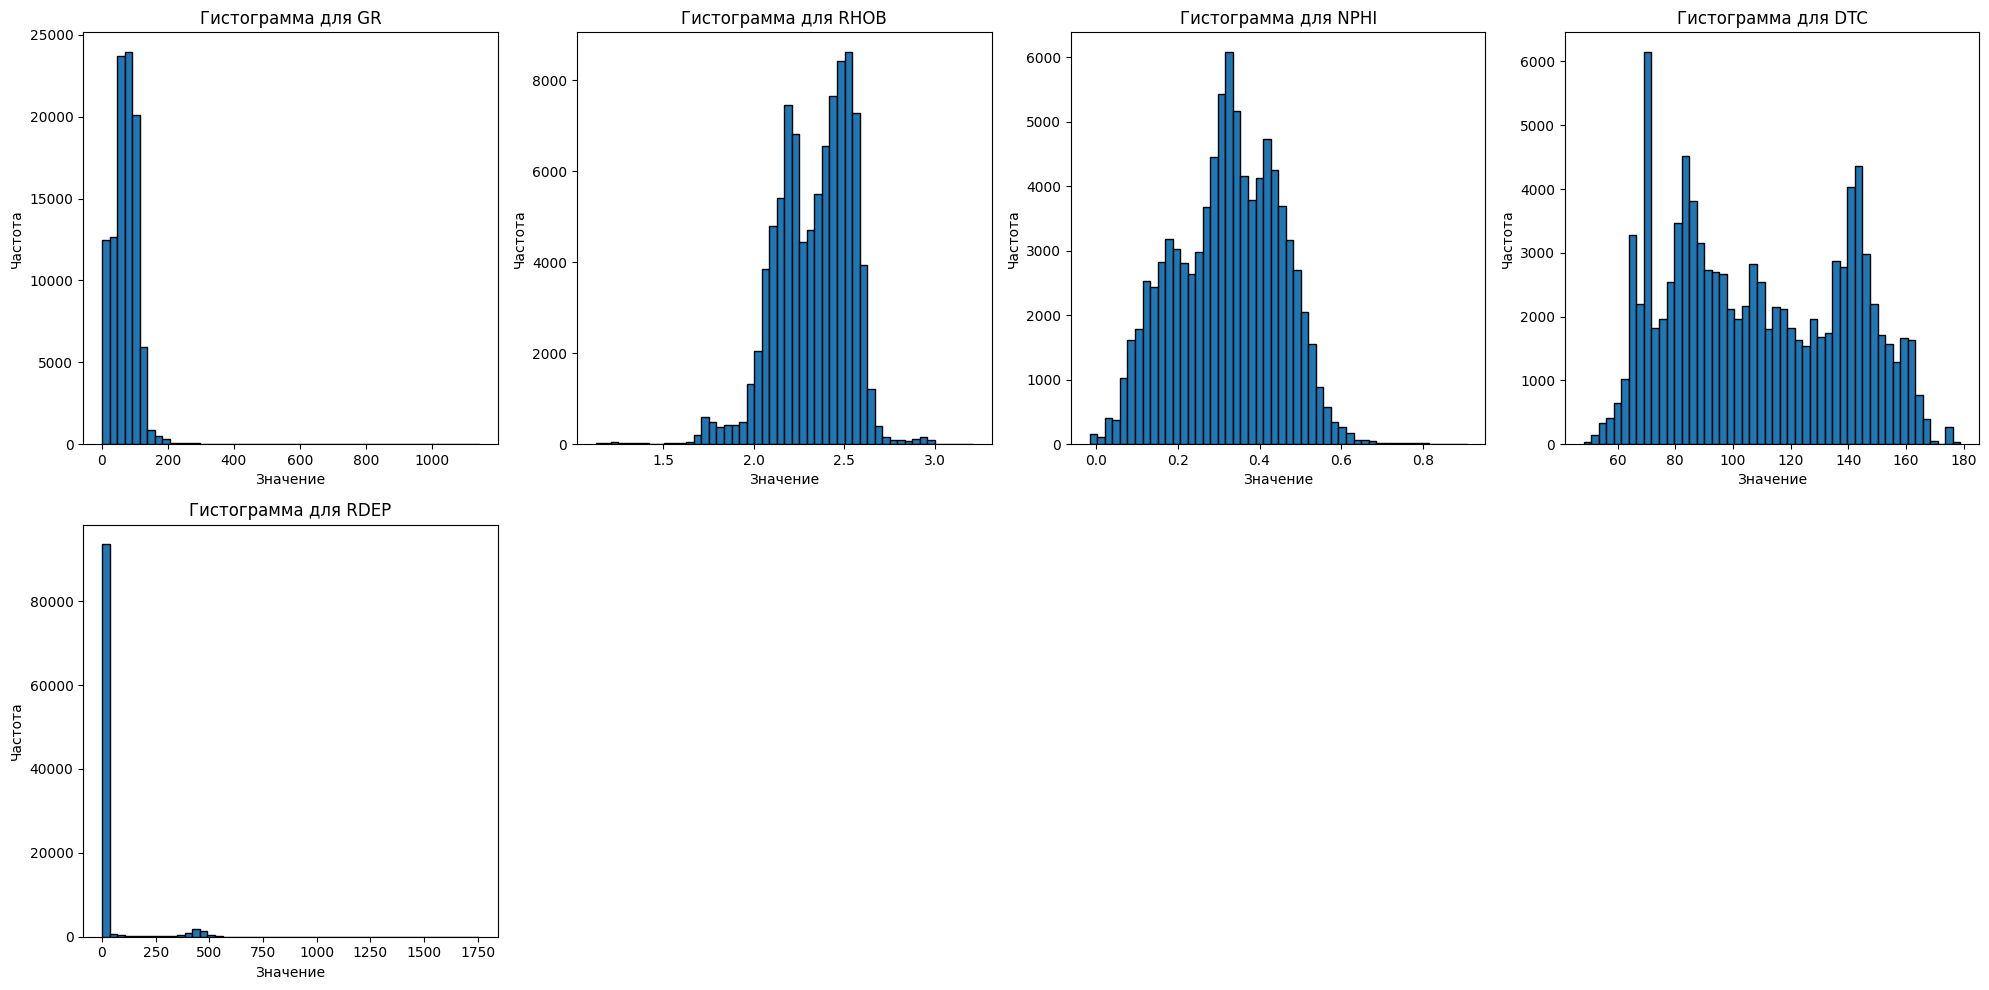

Количество выбросов по методу IQR:
GR: 1020 выбросов (1.01%)
RHOB: 773 выбросов (0.77%)
NPHI: 114 выбросов (0.11%)
DTC: 0 выбросов (0.00%)
RDEP: 11275 выбросов (11.19%)


In [52]:
# EDA: Анализ выбросов
# Визуальный анализ выбросов

numeric_columns = combined_df.select_dtypes(include=[np.number]).columns.tolist()

# Ящики с усами для числовых признаков
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_columns):
    axes[i].boxplot(combined_df[col].dropna())
    axes[i].set_title(f'Ящик с усами для {col}')
    axes[i].set_ylabel('Значение')

# Удаляем пустые подграфики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Гистограммы для визуализации распределения и поиска выбросов
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_columns):
    axes[i].hist(combined_df[col].dropna(), bins=50, edgecolor='black')
    axes[i].set_title(f'Гистограмма для {col}')
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Частота')

# Удаляем пустые подграфики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Статистический анализ выбросов (метод IQR)
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

print('Количество выбросов по методу IQR:')
for col in numeric_columns:
    outliers = detect_outliers_iqr(combined_df[col])
    print(f'{col}: {outliers.sum()} выбросов ({outliers.mean()*100:.2f}%)')

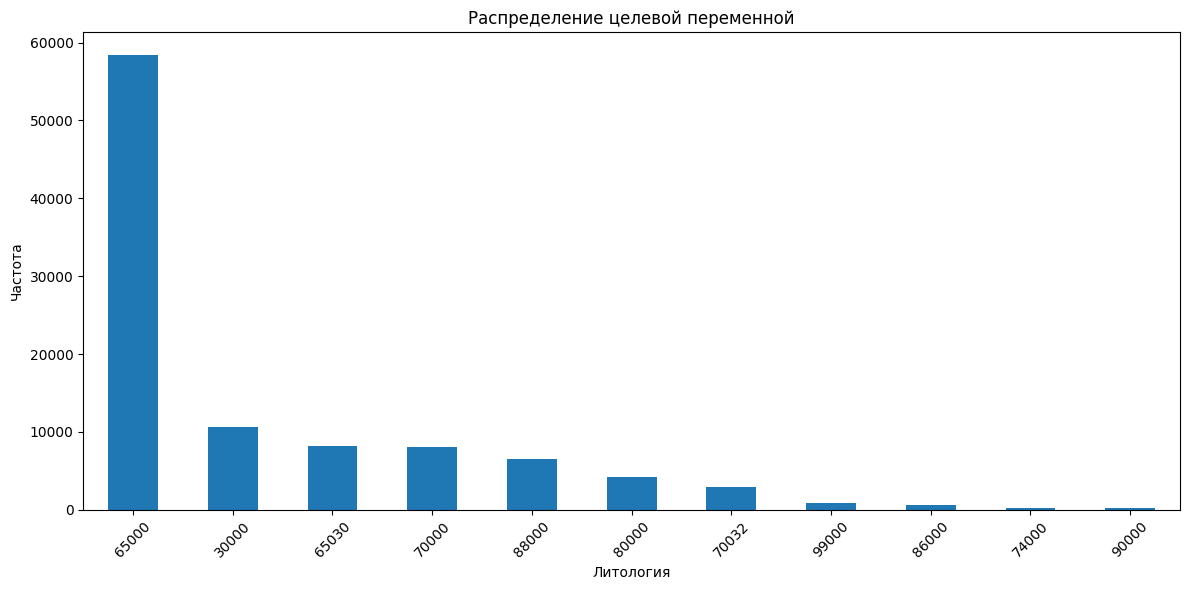

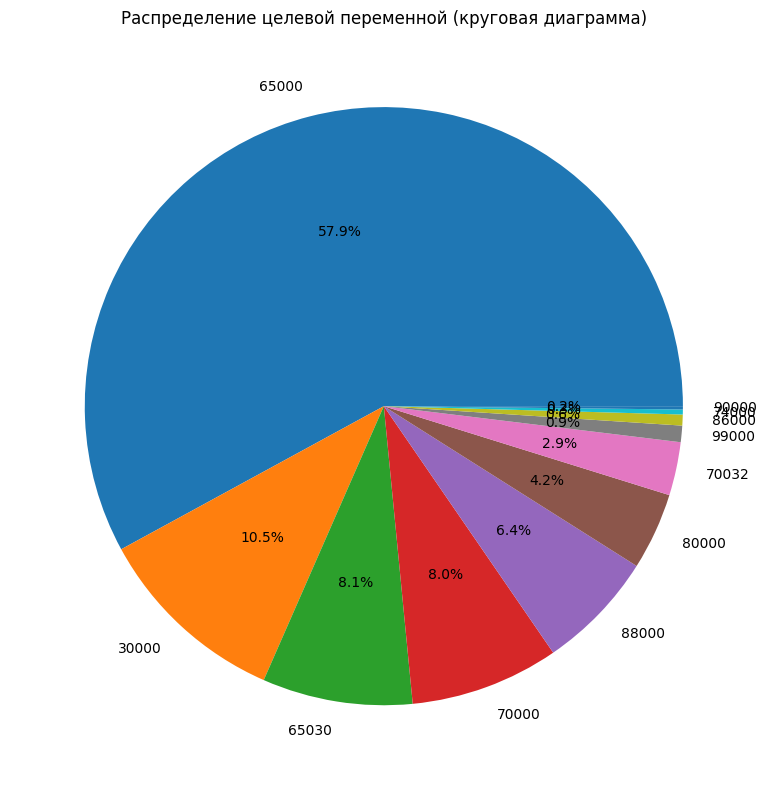

Статистика по целевой переменной:
FORCE_2020_LITHOFACIES_LITHOLOGY
65000    58401
30000    10566
65030     8181
70000     8104
88000     6498
80000     4198
70032     2905
99000      895
86000      597
74000      269
90000      179
Name: count, dtype: int64

Количество уникальных значений: 11
Самое частое значение: 65000
Самое редкое значение: 90000


In [53]:
# EDA: Анализ целевой переменной
# Анализ распределения целевой переменной

if 'FORCE_2020_LITHOFACIES_LITHOLOGY' in combined_df.columns:
    target_col = 'FORCE_2020_LITHOFACIES_LITHOLOGY'
    
    # Гистограмма распределения
    plt.figure(figsize=(12, 6))
    combined_df[target_col].value_counts().plot(kind='bar')
    plt.title('Распределение целевой переменной')
    plt.xlabel('Литология')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Круговая диаграмма
    plt.figure(figsize=(8, 8))
    combined_df[target_col].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Распределение целевой переменной (круговая диаграмма)')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
    print('Статистика по целевой переменной:')
    print(combined_df[target_col].value_counts())
    print(f'\nКоличество уникальных значений: {combined_df[target_col].nunique()}')
    print(f'Самое частое значение: {combined_df[target_col].mode().iloc[0] if not combined_df[target_col].mode().empty else "Нет"}')
    print(f'Самое редкое значение: {combined_df[target_col].value_counts().idxmin()}')


=== Анализ признака GR ===
Основные статистики:
count    100793.000000
mean         70.524258
std          37.238531
min           1.132300
25%          46.831429
50%          70.936447
75%          94.682205
max        1141.292114
Name: GR, dtype: float64

Асимметрия: 1.582
Эксцесс: 25.260


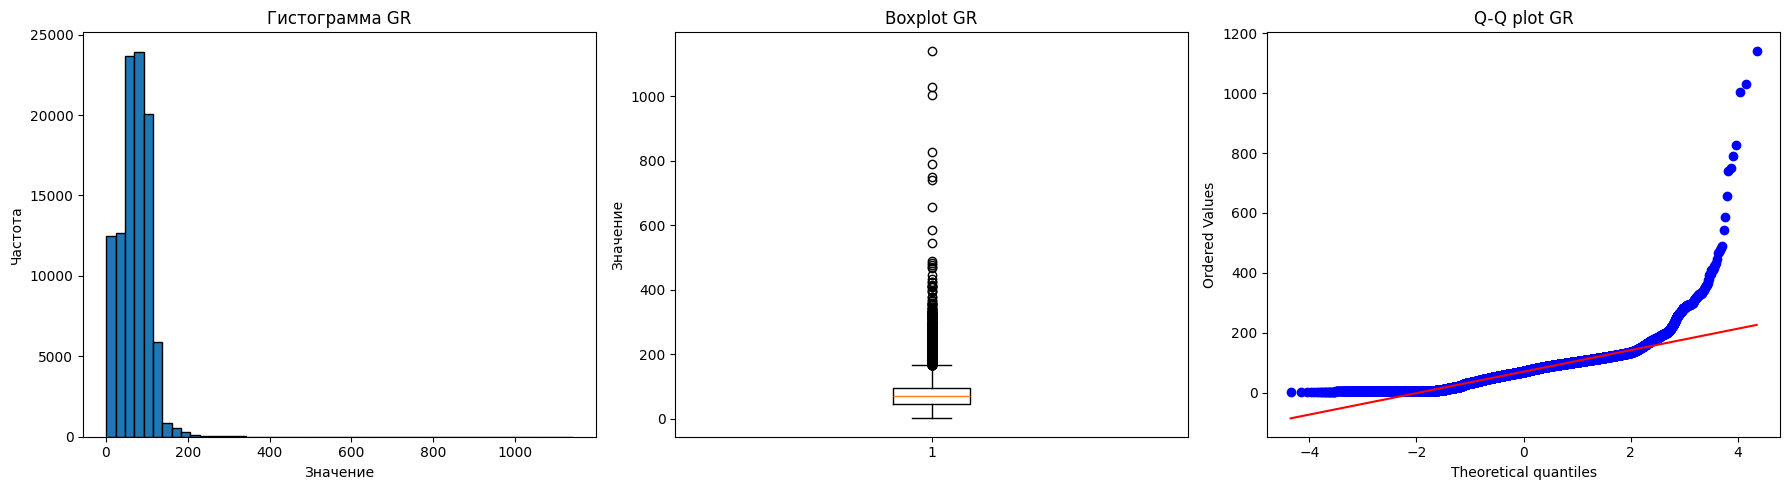


=== Анализ признака RHOB ===
Основные статистики:
count    94603.000000
mean         2.331008
std          0.206957
min          1.127937
25%          2.187116
50%          2.360354
75%          2.495778
max          3.209886
Name: RHOB, dtype: float64

Асимметрия: -0.643
Эксцесс: 1.184


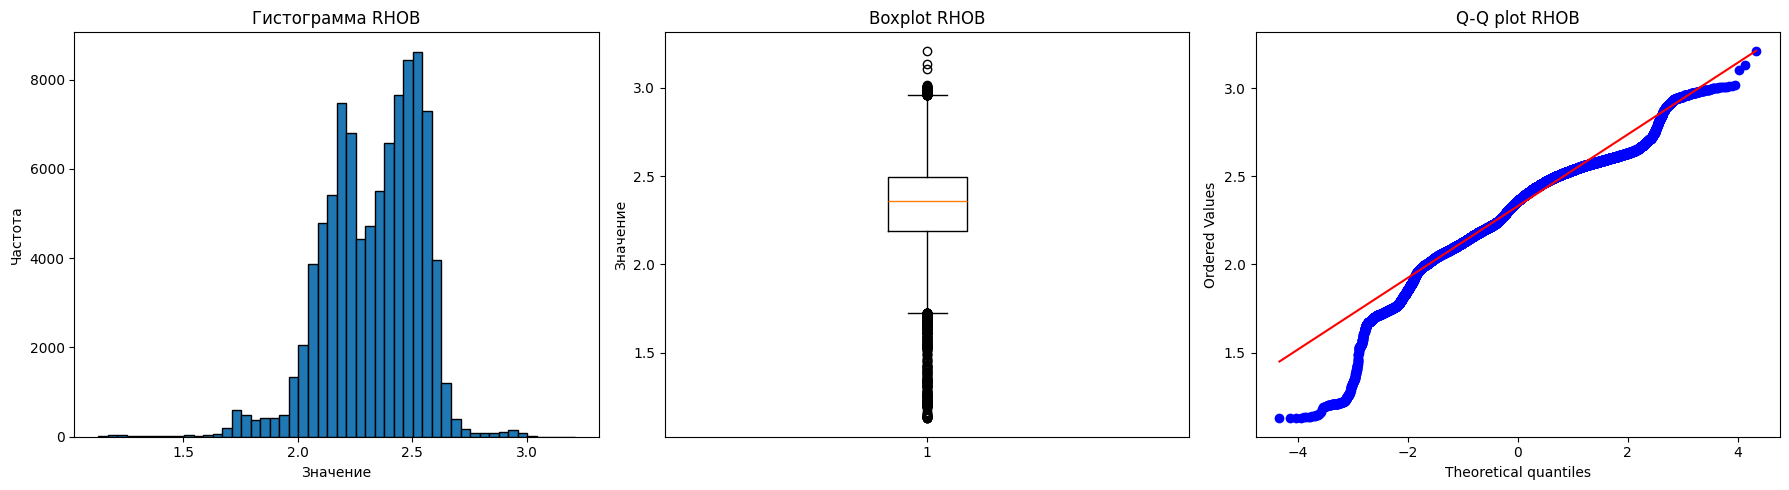


=== Анализ признака NPHI ===
Основные статистики:
count    89474.000000
mean         0.320665
std          0.127854
min         -0.015035
25%          0.225147
50%          0.326571
75%          0.417969
max          0.906257
Name: NPHI, dtype: float64

Асимметрия: -0.091
Эксцесс: -0.477


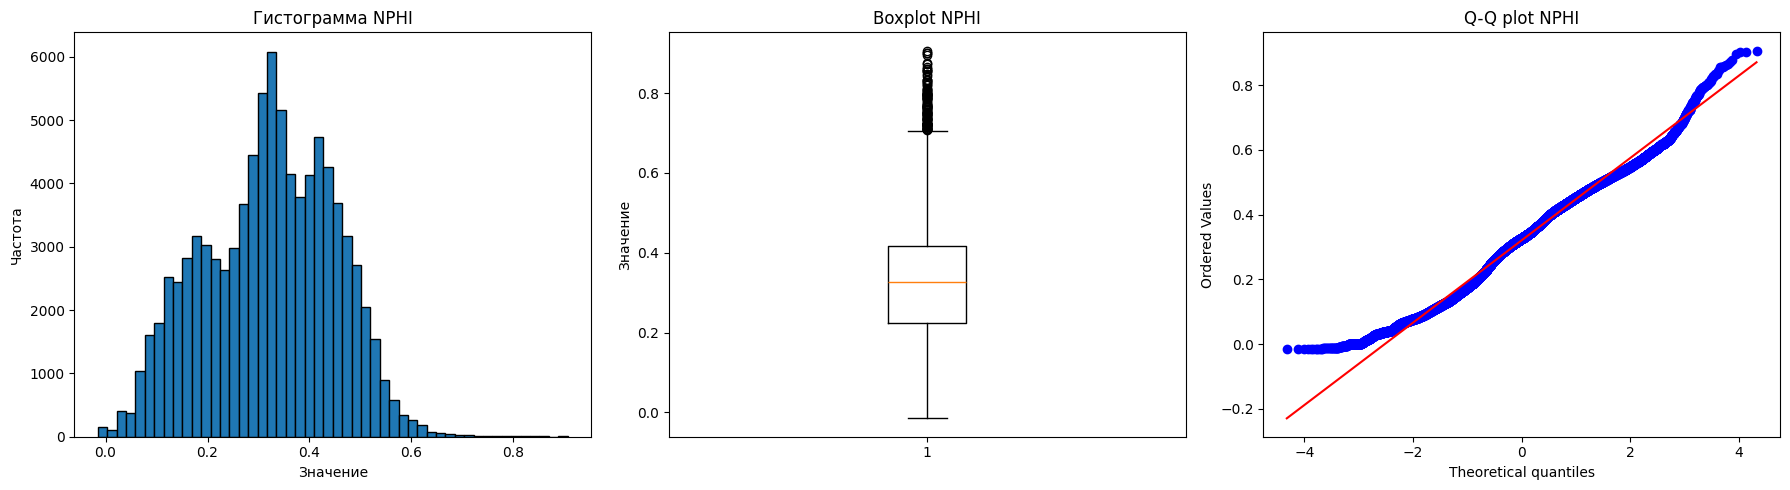


=== Анализ признака DTC ===
Основные статистики:
count    100339.000000
mean        108.795454
std          30.248587
min          48.268532
25%          82.809410
50%         106.071526
75%         137.749435
max         178.817993
Name: DTC, dtype: float64

Асимметрия: 0.163
Эксцесс: -1.228


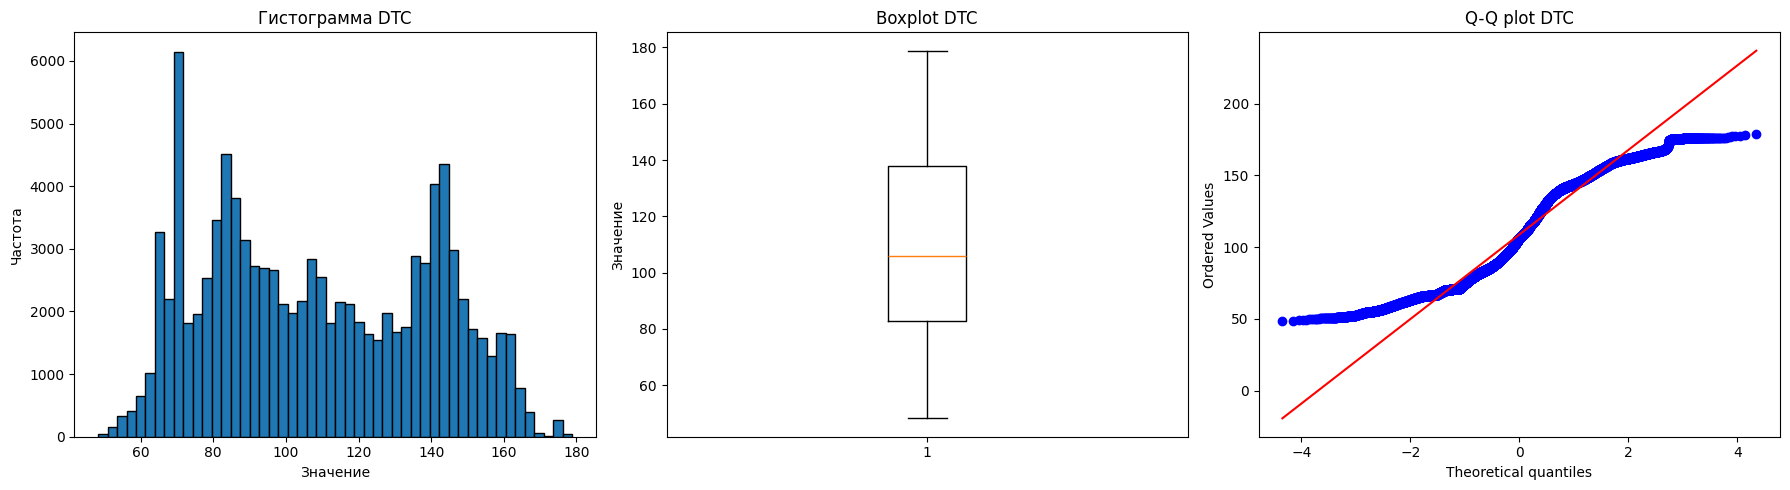


=== Анализ признака RDEP ===
Основные статистики:
count    100793.000000
mean         28.093654
std         105.552489
min           0.037163
25%           0.828335
50%           1.364411
75%           2.873766
max        1755.531006
Name: RDEP, dtype: float64

Асимметрия: 5.033
Эксцесс: 38.463


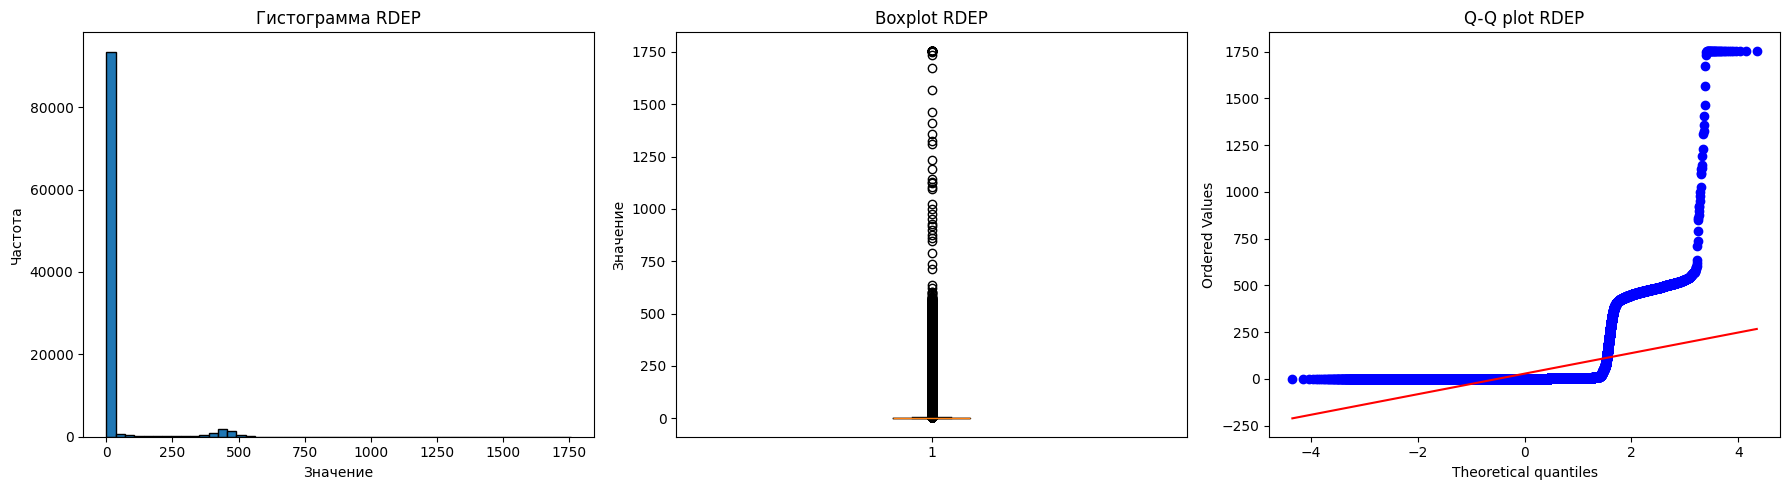

In [54]:
# EDA: Одномерный анализ числовых признаков
# Одномерный анализ числовых признаков

numeric_columns = combined_df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_columns:
    print(f'\n=== Анализ признака {col} ===')
    
    # Основные статистики
    print('Основные статистики:')
    print(combined_df[col].describe())
    
    # Асимметрия и эксцесс
    print(f'\nАсимметрия: {combined_df[col].skew():.3f}')
    print(f'Эксцесс: {combined_df[col].kurtosis():.3f}')
    
    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Гистограмма
    axes[0].hist(combined_df[col].dropna(), bins=50, edgecolor='black')
    axes[0].set_title(f'Гистограмма {col}')
    axes[0].set_xlabel('Значение')
    axes[0].set_ylabel('Частота')
    
    # Boxplot
    axes[1].boxplot(combined_df[col].dropna())
    axes[1].set_title(f'Boxplot {col}')
    axes[1].set_ylabel('Значение')
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(combined_df[col].dropna(), dist="norm", plot=axes[2])
    axes[2].set_title(f'Q-Q plot {col}')
    
    plt.tight_layout()
    plt.show()


=== Анализ признака FORCE_2020_LITHOFACIES_LITHOLOGY ===
Распределение значений:
FORCE_2020_LITHOFACIES_LITHOLOGY
65000    58401
30000    10566
65030     8181
70000     8104
88000     6498
80000     4198
70032     2905
99000      895
86000      597
74000      269
90000      179
Name: count, dtype: int64

Количество уникальных значений: 11
Количество пропущенных значений: 0


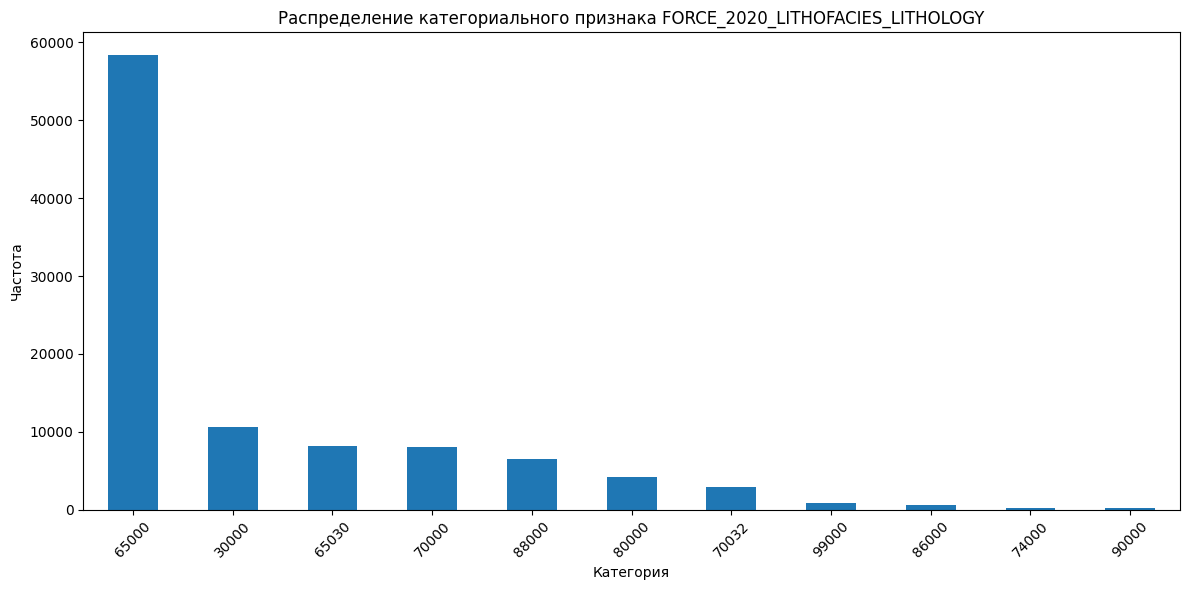


=== Анализ признака WELL_NAME ===
Распределение значений:
WELL_NAME
17/4-1       17271
34/3-2 S     12216
16/2-7       11683
15/9-23      11063
25/10-9      10788
35/9-7       10677
16/7-6       10222
31/2-10       9033
31/2-21 S     7840
Name: count, dtype: int64

Количество уникальных значений: 9
Количество пропущенных значений: 0


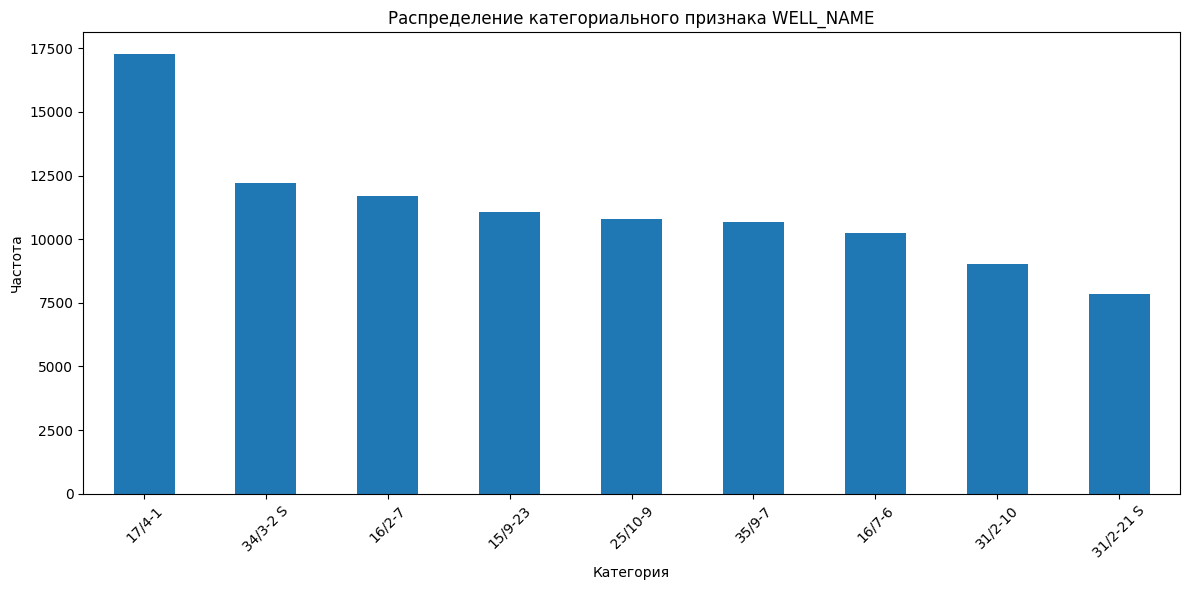

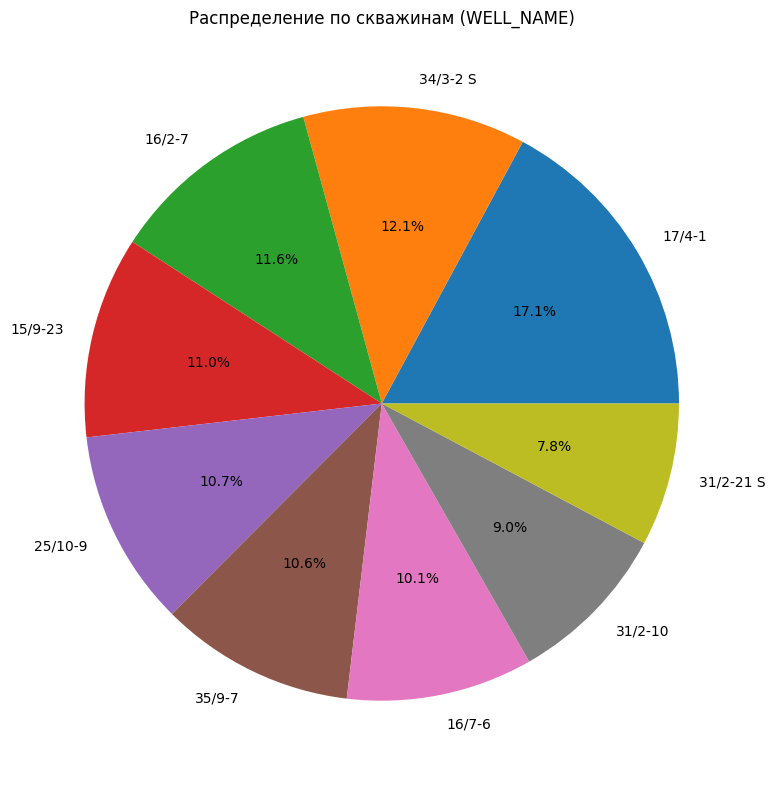

In [55]:
# EDA: Одномерный анализ категориальных признаков
# Одномерный анализ категориальных признаков

categorical_columns = combined_df.select_dtypes(include=['category']).columns.tolist()

for col in categorical_columns:
    print(f'\n=== Анализ признака {col} ===')
    
    # Распределение значений
    print('Распределение значений:')
    print(combined_df[col].value_counts())
    
    print(f'\nКоличество уникальных значений: {combined_df[col].nunique()}')
    print(f'Количество пропущенных значений: {combined_df[col].isna().sum()}')
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    combined_df[col].value_counts().plot(kind='bar')
    plt.title(f'Распределение категориального признака {col}')
    plt.xlabel('Категория')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Круговая диаграмма для признака WELL_NAME
    if col == 'WELL_NAME':
        plt.figure(figsize=(8, 8))
        combined_df[col].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'Распределение по скважинам ({col})')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()

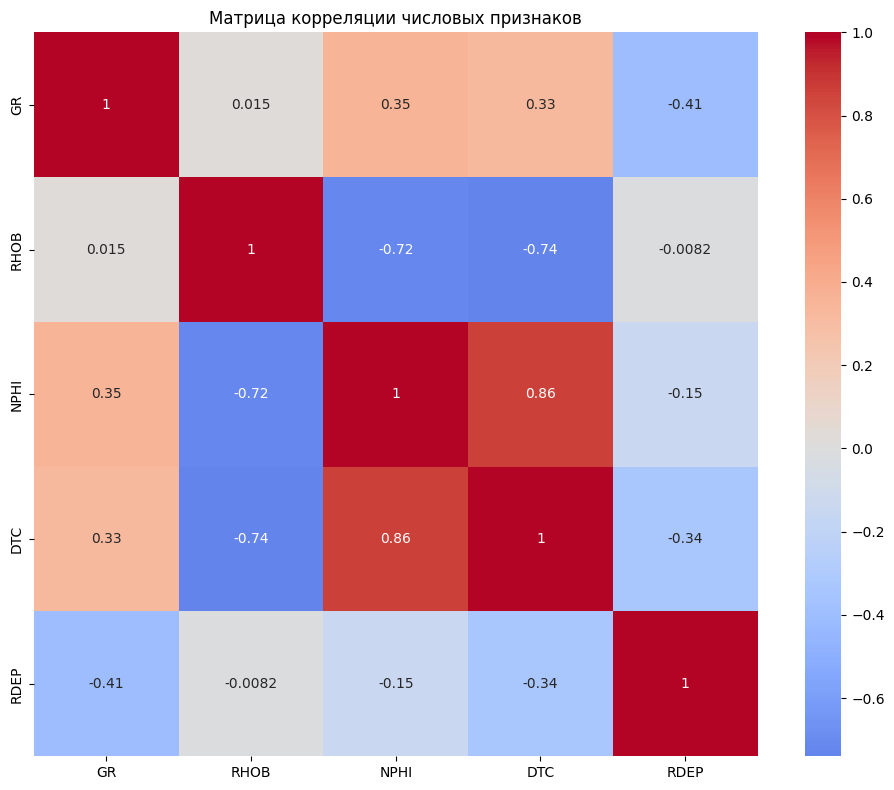

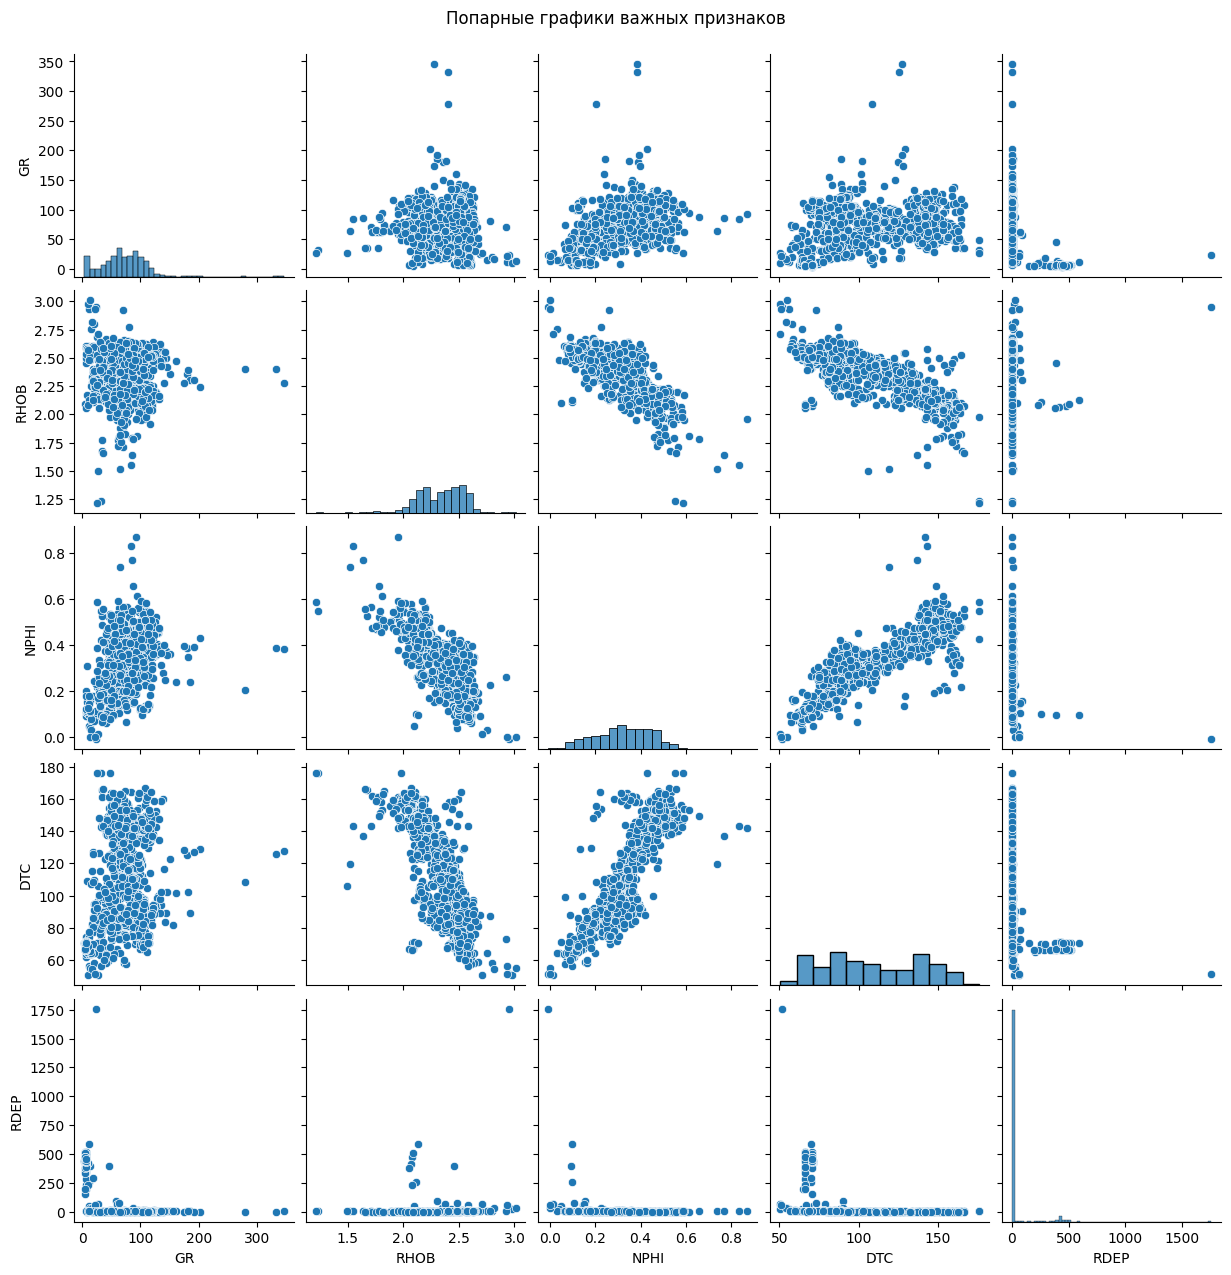

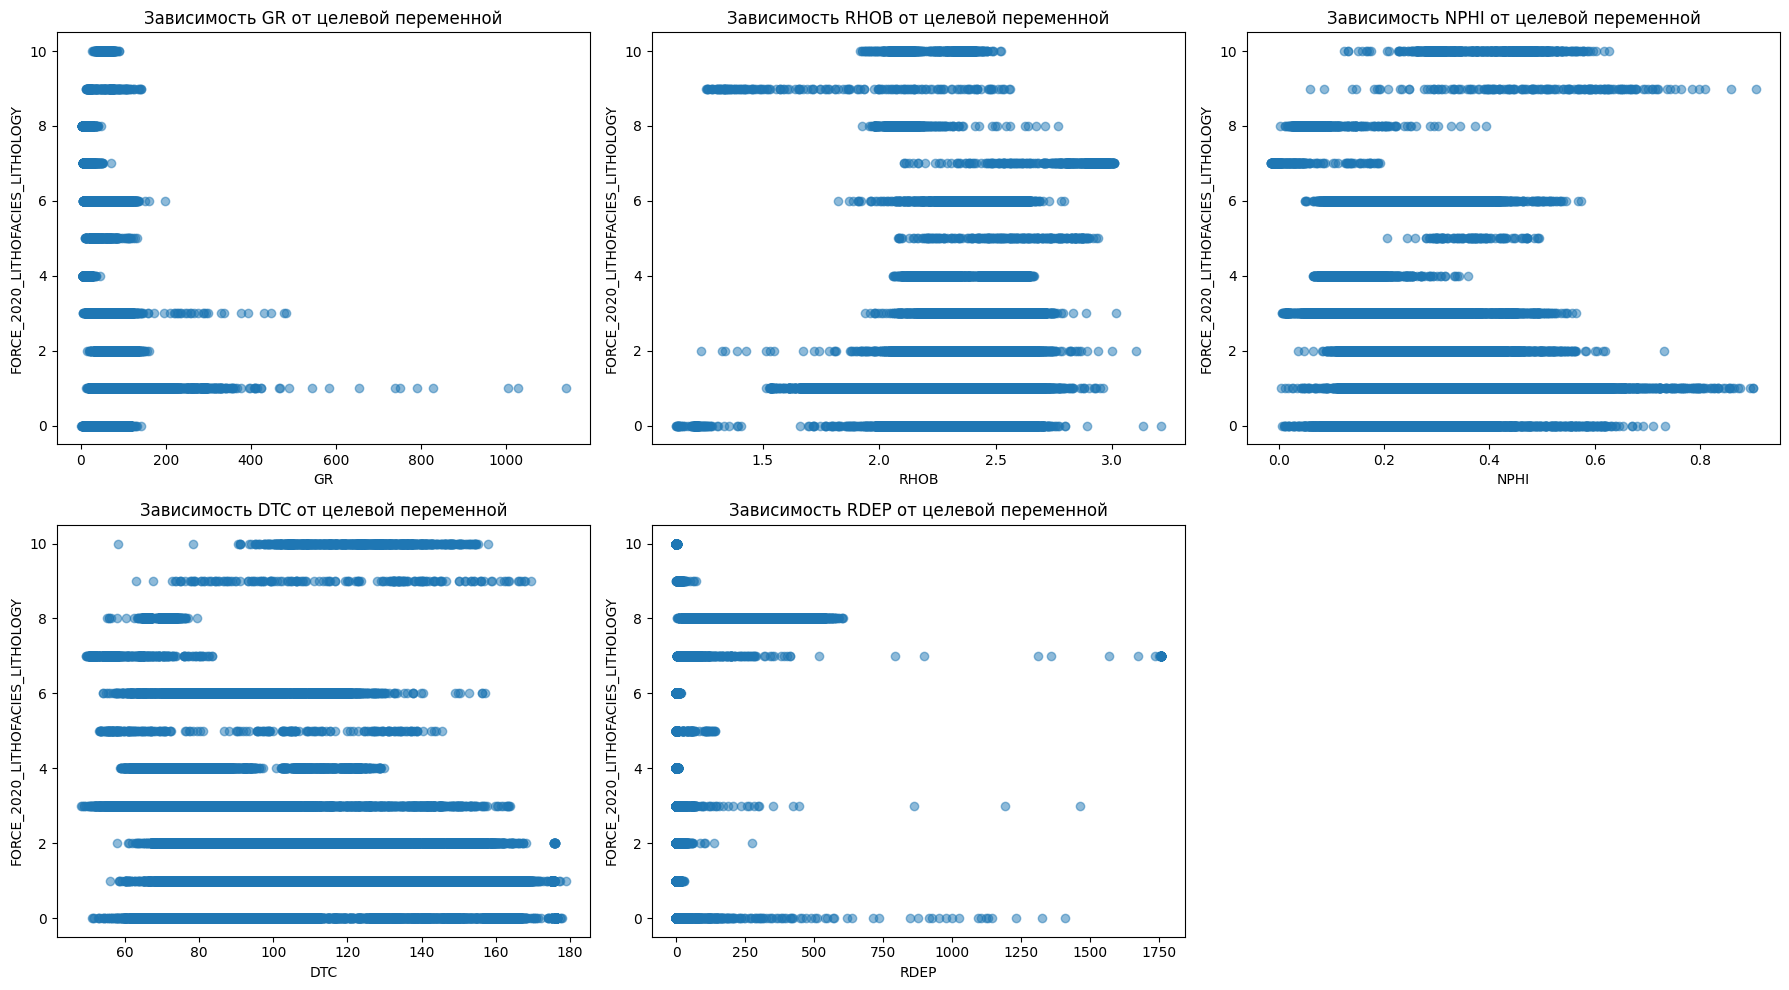

In [56]:
# EDA: Двумерный анализ
# Двумерный анализ: корреляция между числовыми признаками

numeric_columns = combined_df.select_dtypes(include=[np.number]).columns.tolist()

# Матрица корреляции
correlation_matrix = combined_df[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Матрица корреляции числовых признаков')
plt.tight_layout()
plt.show()

# Попарные графики для наиболее коррелирующих признаков
if len(numeric_columns) > 1:
    # Выберем несколько наиболее важных признаков для визуализации
    important_features = ['GR', 'RHOB', 'NPHI', 'DTC', 'RDEP']  # Оставим только существующие признаки
    existing_features = [f for f in important_features if f in numeric_columns]
    
    if len(existing_features) > 1:
        # Попарные графики для выбранных признаков
        sns.pairplot(combined_df[existing_features].sample(n=min(1000, len(combined_df)), random_state=42))
        plt.suptitle('Попарные графики важных признаков', y=1.02)
        plt.show()
        
        # Визуализация зависимости признаков от целевой переменной (если она числовая)
        try:
            target_numeric = pd.to_numeric(combined_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].cat.codes)
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            axes = axes.ravel()
            
            for i, col in enumerate(existing_features):
                if i < len(axes):
                    axes[i].scatter(combined_df[col], target_numeric, alpha=0.5)
                    axes[i].set_xlabel(col)
                    axes[i].set_ylabel('FORCE_2020_LITHOFACIES_LITHOLOGY')
                    axes[i].set_title(f'Зависимость {col} от целевой переменной')
            
            # Удаляем пустые подграфики
            for j in range(i+1, len(axes)):
                fig.delaxes(axes[j])
            
            plt.tight_layout()
            plt.show()
        except:
            print('Невозможно визуализировать зависимость от целевой переменной')

Коэффициенты инфляции дисперсии (VIF):
  Признак        VIF
0      GR   7.324643
1    RHOB  14.373564
2    NPHI  33.525781
3     DTC  51.908656
4    RDEP   1.033379


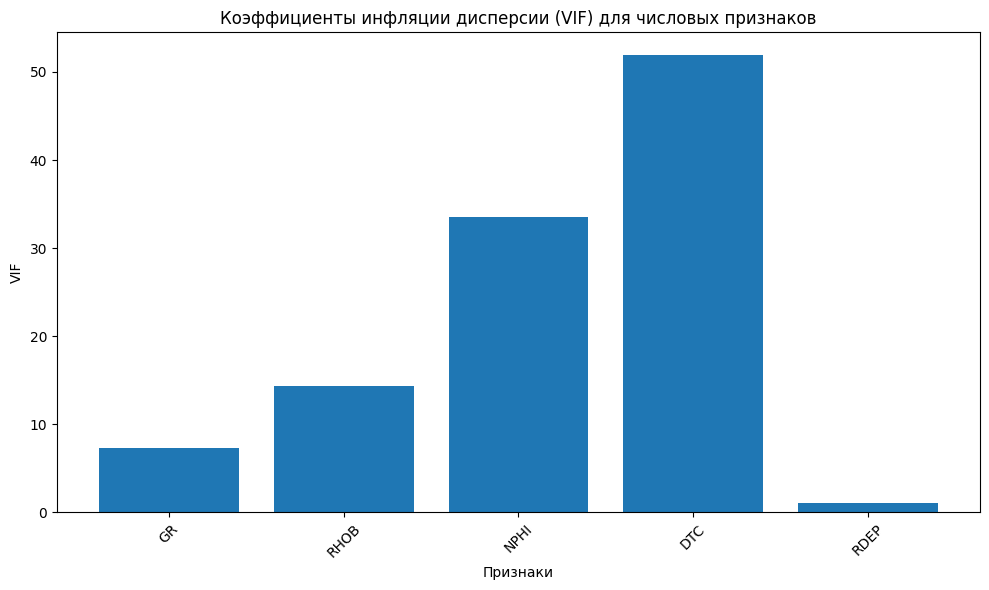


Признаки с высокой мультиколлинеарностью (VIF > 10):
  Признак        VIF
1    RHOB  14.373564
2    NPHI  33.525781
3     DTC  51.908656


In [57]:
# EDA: Исследование мультиколлинеарности
# Расчет VIF (коэффициент инфляции дисперсии) для числовых признаков
# Импорт variance_inflation_factor выполнен в предыдущей ячейке

# Подготовим данные для VIF (только числовые признаки без пропусков)
numeric_data = combined_df[numeric_columns].dropna()

# Вычислим VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Признак"] = numeric_data.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(len(numeric_data.columns))]

print('Коэффициенты инфляции дисперсии (VIF):')
print(vif_data)

# Визуализация VIF
plt.figure(figsize=(10, 6))
plt.bar(vif_data["Признак"], vif_data["VIF"])
plt.title('Коэффициенты инфляции дисперсии (VIF) для числовых признаков')
plt.xlabel('Признаки')
plt.ylabel('VIF')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Определение признаков с высокой мультиколлинеарностью (VIF > 10)
high_vif = vif_data[vif_data["VIF"] > 10]
if not high_vif.empty:
    print(f'\nПризнаки с высокой мультиколлинеарностью (VIF > 10):')
    print(high_vif)
else:
    print('\nНет признаков с высокой мультиколлинеарностью (VIF > 10)')

In [58]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100793 entries, 0 to 100792
Data columns (total 7 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   FORCE_2020_LITHOFACIES_LITHOLOGY  100793 non-null  category
 1   GR                                100793 non-null  float64 
 2   RHOB                              94603 non-null   float64 
 3   NPHI                              89474 non-null   float64 
 4   DTC                               100339 non-null  float64 
 5   RDEP                              100793 non-null  float64 
 6   WELL_NAME                         100793 non-null  category
dtypes: category(2), float64(5)
memory usage: 4.0 MB


In [59]:
combined_df.isnull().sum() / len(combined_df) * 100

FORCE_2020_LITHOFACIES_LITHOLOGY     0.000000
GR                                   0.000000
RHOB                                 6.141299
NPHI                                11.229947
DTC                                  0.450428
RDEP                                 0.000000
WELL_NAME                            0.000000
dtype: float64

# Логическое преобразование

## Числовые признаки

Исследование на пропуски и выбросы

In [60]:
# Автоматическая загрузка данных, если combined_df не найден
if 'combined_df' not in globals():
    print("⚠️ Переменная 'combined_df' не найдена. Выполняю автоматическую загрузку и подготовку данных...")
    
    # Определяем путь к данным
    path = "data"
    
    # Исключаем 31_6-5.csv и 31_6-8.csv
    files_to_include = [f for f in os.listdir(path) if f.endswith('.csv') and f not in ['31_6-5.csv', '31_6-8.csv']]
    
    # Список для хранения датафреймов
    dfs = []
    
    for file in files_to_include:
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path)
        
        # Проверка наличия необходимых столбцов
        required_cols = ['FORCE_2020_LITHOFACIES_LITHOLOGY', 'GR', 'RHOB', 'NPHI', 'DTC', 'RDEP', 'SP', 'RSHA']
        if all(col in df.columns for col in required_cols):
            # Добавление столбца с именем скважины
            if 'WELL' in df.columns:
                df['WELL_NAME'] = df['WELL']
            else:
                df['WELL_NAME'] = file
            
            # Выбор только нужных столбцов
            df = df[required_cols + ['WELL_NAME']]
            dfs.append(df)
    
    # Объединение всех датафреймов
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Преобразование в категориальный тип
    if 'FORCE_2020_LITHOFACIES_LITHOLOGY' in combined_df.columns:
        combined_df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = combined_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].astype('category')
    
    if 'WELL_NAME' in combined_df.columns:
        combined_df['WELL_NAME'] = combined_df['WELL_NAME'].astype('category')
    
    print(f"✅ Данные успешно загружены: {len(combined_df)} строк, {len(combined_df.columns)} столбцов\n")

# Получаем все числовые признаки
numeric_columns = combined_df.select_dtypes(include=[np.number]).columns.tolist()

print("="*80)
print("АНАЛИЗ ЧИСЛОВЫХ ПРИЗНАКОВ")
print("="*80)
print(f"\nВсего числовых признаков: {len(numeric_columns)}")
print(f"Список признаков: {numeric_columns}\n")

# Описание каждого признака
feature_descriptions = {
    'GR': 'Gamma Ray (Гамма-каротаж) - измеряет естественную радиоактивность пород. Высокие значения указывают на глинистые породы или сланцы.',
    'RHOB': 'Bulk Density (Объемная плотность) - плотность горной породы в г/см³. Используется для определения литологии и пористости.',
    'NPHI': 'Neutron Porosity (Нейтронная пористость) - измерение пористости породы с помощью нейтронного каротажа. Значения от 0 до 1.',
    'DTC': 'Delta-T Compressional (Интервальное время сжатия) - время прохождения компрессионной волны через породу в мкс/фут. Обратно пропорционально упругим свойствам.',
    'RDEP': 'Deep Resistivity (Глубокое сопротивление) - электрическое сопротивление породы на большой глубине. Высокие значения указывают на нефтегазонасыщенные зоны.',
    'SP': 'Spontaneous Potential (Спонтанный потенциал) - естественный электрический потенциал, возникающий на границе порода-флюид. Измеряется в милливольтах.',
    'RSHA': 'Shallow Resistivity (Мелкое сопротивление) - электрическое сопротивление породы в зоне проникновения бурового раствора (промытая зона).'
}

# Функция для определения выбросов методом IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, lower_bound, upper_bound

# Анализ каждого числового признака
analysis_results = []

for col in numeric_columns:
    print("\n" + "="*80)
    print(f"ПРИЗНАК: {col}")
    print("="*80)
    
    # Описание признака
    if col in feature_descriptions:
        print(f"\n📖 ОПИСАНИЕ: {feature_descriptions[col]}")
    else:
        print(f"\n📖 ОПИСАНИЕ: Описание не найдено")
    
    # Базовые статистики
    col_data = combined_df[col].dropna()
    if len(col_data) > 0:
        print(f"\n📊 СТАТИСТИКА:")
        print(f"  Количество значений: {len(col_data)} / {len(combined_df)} ({len(col_data)/len(combined_df)*100:.2f}%)")
        print(f"  Среднее: {col_data.mean():.4f}")
        print(f"  Медиана: {col_data.median():.4f}")
        print(f"  Стандартное отклонение: {col_data.std():.4f}")
        print(f"  Минимум: {col_data.min():.4f}")
        print(f"  Максимум: {col_data.max():.4f}")
        print(f"  25-й перцентиль: {col_data.quantile(0.25):.4f}")
        print(f"  75-й перцентиль: {col_data.quantile(0.75):.4f}")
        
        # Пропуски
        missing_count = combined_df[col].isnull().sum()
        missing_percent = (missing_count / len(combined_df)) * 100
        print(f"\n❌ ПРОПУСКИ:")
        print(f"  Количество: {missing_count}")
        print(f"  Процент: {missing_percent:.2f}%")
        if missing_percent > 50:
            print(f"  ⚠️ ВНИМАНИЕ: Более 50% пропусков!")
        elif missing_percent > 20:
            print(f"  ⚠️ ВНИМАНИЕ: Более 20% пропусков")
        
        # Выбросы
        outliers, lower_bound, upper_bound = detect_outliers_iqr(col_data)
        outlier_count = outliers.sum()
        outlier_percent = (outlier_count / len(col_data)) * 100
        print(f"\n🔍 ВЫБРОСЫ (метод IQR):")
        print(f"  Количество: {outlier_count}")
        print(f"  Процент: {outlier_percent:.2f}%")
        print(f"  Нижняя граница: {lower_bound:.4f}")
        print(f"  Верхняя граница: {upper_bound:.4f}")
        if outlier_percent > 10:
            print(f"  ⚠️ ВНИМАНИЕ: Более 10% выбросов!")
        
        # Сохраняем результаты
        analysis_results.append({
            'Признак': col,
            'Описание': feature_descriptions.get(col, 'Не указано'),
            'Всего значений': len(combined_df),
            'Не пропущено': len(col_data),
            'Пропущено': missing_count,
            '% пропусков': f"{missing_percent:.2f}%",
            'Выбросов': outlier_count,
            '% выбросов': f"{outlier_percent:.2f}%",
            'Среднее': f"{col_data.mean():.4f}",
            'Медиана': f"{col_data.median():.4f}",
            'Мин': f"{col_data.min():.4f}",
            'Макс': f"{col_data.max():.4f}"
        })
    else:
        print(f"\n⚠️ ВНИМАНИЕ: Все значения пропущены!")

# Итоговая таблица
print("\n" + "="*80)
print("ИТОГОВАЯ СВОДКА")
print("="*80)
summary_df = pd.DataFrame(analysis_results)
print("\n", summary_df.to_string(index=False))

print("\n" + "="*80)
print("РЕКОМЕНДАЦИИ")
print("="*80)
print("\nДля признаков с большим процентом пропусков (>20%):")
print("  - Рассмотреть удаление признака или заполнение пропусков")
print("  - Использовать методы импутации (медиана, среднее, или ML-методы)")
print("\nДля признаков с большим процентом выбросов (>10%):")
print("  - Проверить корректность данных")
print("  - Рассмотреть логарифмическое преобразование")
print("  - Использовать методы обработки выбросов (удаление, трансформация, winsorization)")



АНАЛИЗ ЧИСЛОВЫХ ПРИЗНАКОВ

Всего числовых признаков: 5
Список признаков: ['GR', 'RHOB', 'NPHI', 'DTC', 'RDEP']


ПРИЗНАК: GR

📖 ОПИСАНИЕ: Gamma Ray (Гамма-каротаж) - измеряет естественную радиоактивность пород. Высокие значения указывают на глинистые породы или сланцы.

📊 СТАТИСТИКА:
  Количество значений: 100793 / 100793 (100.00%)
  Среднее: 70.5243
  Медиана: 70.9364
  Стандартное отклонение: 37.2385
  Минимум: 1.1323
  Максимум: 1141.2921
  25-й перцентиль: 46.8314
  75-й перцентиль: 94.6822

❌ ПРОПУСКИ:
  Количество: 0
  Процент: 0.00%

🔍 ВЫБРОСЫ (метод IQR):
  Количество: 1020
  Процент: 1.01%
  Нижняя граница: -24.9447
  Верхняя граница: 166.4584

ПРИЗНАК: RHOB

📖 ОПИСАНИЕ: Bulk Density (Объемная плотность) - плотность горной породы в г/см³. Используется для определения литологии и пористости.

📊 СТАТИСТИКА:
  Количество значений: 94603 / 100793 (93.86%)
  Среднее: 2.3310
  Медиана: 2.3604
  Стандартное отклонение: 0.2070
  Минимум: 1.1279
  Максимум: 3.2099
  25-й перцентиль: 2.

### Вывод

Признаки слишком не понятны и сложны заполнить данные или изменить логически

## Категориальные признаки

In [61]:
# ================================================================================
# АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
# ================================================================================
print("\n\n" + "="*80)
print("АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("="*80)

# Описание категориальных признаков
categorical_descriptions = {
    'FORCE_2020_LITHOFACIES_LITHOLOGY': 'Литология (целевая переменная) - классификация типов горных пород на основе их физических свойств. Числовые коды соответствуют различным типам литологии.',
    'WELL_NAME': 'Имя скважины (идентификатор) - уникальное название скважины, из которой были получены данные. Используется для идентификации источника данных.'
}

# Получаем категориальные признаки
categorical_columns = combined_df.select_dtypes(include=['category', 'object']).columns.tolist()

print(f"\nВсего категориальных признаков: {len(categorical_columns)}")
print(f"Список признаков: {categorical_columns}\n")

# Анализ каждого категориального признака
categorical_results = []

for col in categorical_columns:
    print("\n" + "="*80)
    print(f"ПРИЗНАК: {col}")
    print("="*80)
    
    # Описание признака
    if col in categorical_descriptions:
        print(f"\n📖 ОПИСАНИЕ: {categorical_descriptions[col]}")
    else:
        print(f"\n📖 ОПИСАНИЕ: Описание не найдено")
    
    # Базовые статистики
    col_data = combined_df[col].dropna()
    total_count = len(combined_df)
    
    if len(col_data) > 0:
        print(f"\n📊 СТАТИСТИКА:")
        print(f"  Количество значений: {len(col_data)} / {total_count} ({len(col_data)/total_count*100:.2f}%)")
        print(f"  Количество уникальных значений: {col_data.nunique()}")
        
        # Пропуски
        missing_count = combined_df[col].isnull().sum()
        missing_percent = (missing_count / total_count) * 100
        print(f"\n❌ ПРОПУСКИ:")
        print(f"  Количество: {missing_count}")
        print(f"  Процент: {missing_percent:.2f}%")
        if missing_percent > 50:
            print(f"  ⚠️ ВНИМАНИЕ: Более 50% пропусков!")
        elif missing_percent > 20:
            print(f"  ⚠️ ВНИМАНИЕ: Более 20% пропусков")
        elif missing_percent > 0:
            print(f"  ⚠️ Есть пропуски, но их количество приемлемо")
        else:
            print(f"  ✅ Пропусков нет")
        
        # Распределение значений
        value_counts = col_data.value_counts()
        total_non_missing = len(col_data)
        
        print(f"\n📋 РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ:")
        print(f"  Топ-10 наиболее частых значений:")
        for i, (value, count) in enumerate(value_counts.head(10).items(), 1):
            percent = (count / total_non_missing) * 100
            print(f"    {i}. {value}: {count} ({percent:.2f}%)")
        
        if len(value_counts) > 10:
            print(f"  ... и еще {len(value_counts) - 10} уникальных значений")
        
        # Редкие значения (аналог "выбросов" для категориальных)
        # Значения, которые встречаются реже 1% от всех записей
        rare_threshold = total_non_missing * 0.01
        rare_values = value_counts[value_counts < rare_threshold]
        
        print(f"\n🔍 РЕДКИЕ ЗНАЧЕНИЯ (встречаются менее чем в 1% записей):")
        if len(rare_values) > 0:
            print(f"  Количество редких значений: {len(rare_values)}")
            rare_count_total = rare_values.sum()
            rare_percent = (rare_count_total / total_non_missing) * 100
            print(f"  Общее количество записей с редкими значениями: {rare_count_total} ({rare_percent:.2f}%)")
            print(f"  Список редких значений:")
            for value, count in rare_values.items():
                percent = (count / total_non_missing) * 100
                print(f"    - {value}: {count} раз ({percent:.3f}%)")
            
            if rare_percent > 10:
                print(f"  ⚠️ ВНИМАНИЕ: Более 10% записей содержат редкие значения!")
            elif rare_percent > 5:
                print(f"  ⚠️ ВНИМАНИЕ: Более 5% записей содержат редкие значения")
        else:
            print(f"  ✅ Редких значений не обнаружено (все значения встречаются часто)")
        
        # Сохраняем результаты
        rare_count_total = rare_values.sum() if len(rare_values) > 0 else 0
        categorical_results.append({
            'Признак': col,
            'Описание': categorical_descriptions.get(col, 'Не указано'),
            'Всего значений': total_count,
            'Не пропущено': len(col_data),
            'Пропущено': missing_count,
            '% пропусков': f"{missing_percent:.2f}%",
            'Уникальных значений': col_data.nunique(),
            'Редких значений': len(rare_values),
            'Записей с редкими значениями': rare_count_total,
            '% редких значений': f"{(rare_count_total / total_non_missing * 100):.2f}%" if len(rare_values) > 0 else "0.00%",
            'Самое частое': f"{value_counts.index[0]} ({value_counts.iloc[0]} раз)"
        })
    else:
        print(f"\n⚠️ ВНИМАНИЕ: Все значения пропущены!")

# Итоговая таблица для категориальных признаков
print("\n" + "="*80)
print("ИТОГОВАЯ СВОДКА ПО КАТЕГОРИАЛЬНЫМ ПРИЗНАКАМ")
print("="*80)
if categorical_results:
    categorical_summary_df = pd.DataFrame(categorical_results)
    print("\n", categorical_summary_df.to_string(index=False))
    
    print("\n" + "="*80)
    print("РЕКОМЕНДАЦИИ ПО КАТЕГОРИАЛЬНЫМ ПРИЗНАКАМ")
    print("="*80)
    print("\nДля категориальных признаков с пропусками:")
    print("  - Если пропусков мало (<5%), можно заполнить наиболее частым значением")
    print("  - Если пропусков много (>20%), рассмотреть создание отдельной категории 'Unknown'")
    print("  - Или удалить записи с пропусками, если это не критично")
    print("\nДля категориальных признаков с редкими значениями:")
    print("  - Рассмотреть группировку редких значений в категорию 'Other' или 'Rare'")
    print("  - Это поможет уменьшить количество уникальных значений и улучшить обобщающую способность модели")
    print("  - Особенно важно для целевой переменной (если редкие классы не представляют интереса)")
else:
    print("\n⚠️ Категориальные признаки не найдены или все значения пропущены")




АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Всего категориальных признаков: 2
Список признаков: ['FORCE_2020_LITHOFACIES_LITHOLOGY', 'WELL_NAME']


ПРИЗНАК: FORCE_2020_LITHOFACIES_LITHOLOGY

📖 ОПИСАНИЕ: Литология (целевая переменная) - классификация типов горных пород на основе их физических свойств. Числовые коды соответствуют различным типам литологии.

📊 СТАТИСТИКА:
  Количество значений: 100793 / 100793 (100.00%)
  Количество уникальных значений: 11

❌ ПРОПУСКИ:
  Количество: 0
  Процент: 0.00%
  ✅ Пропусков нет

📋 РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ:
  Топ-10 наиболее частых значений:
    1. 65000: 58401 (57.94%)
    2. 30000: 10566 (10.48%)
    3. 65030: 8181 (8.12%)
    4. 70000: 8104 (8.04%)
    5. 88000: 6498 (6.45%)
    6. 80000: 4198 (4.16%)
    7. 70032: 2905 (2.88%)
    8. 99000: 895 (0.89%)
    9. 86000: 597 (0.59%)
    10. 74000: 269 (0.27%)
  ... и еще 1 уникальных значений

🔍 РЕДКИЕ ЗНАЧЕНИЯ (встречаются менее чем в 1% записей):
  Количество редких значений: 4
  Общее количество записей с р

### Вывод

В признаке FORCE_2020_LITHOFACIES_LITHOLOGY есть редкие при значения. Их надо объединить в Other

In [62]:
# Проверяем наличие combined_df
if 'combined_df' not in globals():
    print("⚠️ Переменная 'combined_df' не найдена. Выполните ячейку с загрузкой данных.")
else:
    if 'FORCE_2020_LITHOFACIES_LITHOLOGY' not in combined_df.columns:
        print("⚠️ Признак FORCE_2020_LITHOFACIES_LITHOLOGY не найден в данных.")
    else:
        print("="*80)
        print("ОБЪЕДИНЕНИЕ РЕДКИХ ЗНАЧЕНИЙ В КАТЕГОРИЮ 'Other'")
        print("="*80)
        
        # Получаем данные по целевой переменной
        target_col = 'FORCE_2020_LITHOFACIES_LITHOLOGY'
        col_data = combined_df[target_col].dropna()
        total_count = len(col_data)
        
        print(f"\nАнализ признака: {target_col}")
        print(f"Всего записей (без пропусков): {total_count}")
        
        # Подсчитываем частоту каждого значения
        value_counts = col_data.value_counts()
        print(f"\nКоличество уникальных значений: {len(value_counts)}")
        
        # Определяем порог для редких значений (менее 1% от всех записей)
        rare_threshold = total_count * 0.01
        print(f"Порог для редких значений: < {rare_threshold:.0f} записей (< 1%)")
        
        # Находим редкие значения
        rare_values = value_counts[value_counts < rare_threshold]
        
        if len(rare_values) > 0:
            print(f"\n📊 НАЙДЕНО РЕДКИХ ЗНАЧЕНИЙ: {len(rare_values)}")
            print(f"Общее количество записей с редкими значениями: {rare_values.sum()}")
            print(f"\nСписок редких значений, которые будут объединены в 'Other':")
            for value, count in rare_values.items():
                percent = (count / total_count) * 100
                print(f"  - {value}: {count} раз ({percent:.3f}%)")
            
            # Сохраняем исходное распределение до изменений
            original_value_counts = combined_df[target_col].value_counts()
            
            # Создаем копию исходных данных ПЕРЕД изменениями
            # Важно: делаем глубокую копию и удаляем неиспользуемые категории сразу
            combined_df[target_col + '_original'] = combined_df[target_col].copy()
            
            # Заменяем редкие значения на "Other" в основном столбце
            rare_values_list = rare_values.index.tolist()
            
            # Преобразуем в строковый тип для надежной замены
            col_series = combined_df[target_col].astype(str)
            
            # Заменяем редкие значения на "Other"
            for rare_val in rare_values_list:
                col_series = col_series.replace(str(rare_val), 'Other')
            
            # Обновляем столбец в датафрейме
            combined_df[target_col] = col_series
            
            # Преобразуем обратно в категориальный тип
            combined_df[target_col] = combined_df[target_col].astype('category')
            
            # Удаляем неиспользуемые категории в основном столбце
            combined_df[target_col] = combined_df[target_col].cat.remove_unused_categories()
            
            # Удаляем неиспользуемые категории в оригинальном столбце тоже
            if combined_df[target_col + '_original'].dtype.name == 'category':
                combined_df[target_col + '_original'] = combined_df[target_col + '_original'].cat.remove_unused_categories()
            
            print(f"\n✅ Изменения применены!")
            print(f"  Объединено {len(rare_values)} редких значений в категорию 'Other'")
            print(f"  Затронуто записей: {rare_values.sum()}")
            
            # Показываем новое распределение (только непустые категории)
            print(f"\n📋 НОВОЕ РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ (после удаления неиспользуемых категорий):")
            new_value_counts = combined_df[target_col].value_counts()
            # Показываем только категории с ненулевыми значениями
            non_zero_counts = new_value_counts[new_value_counts > 0]
            for value, count in non_zero_counts.items():
                percent = (count / total_count) * 100
                print(f"  {value}: {count} ({percent:.2f}%)")
            
            # Сравнение до и после
            print(f"\n📊 СРАВНЕНИЕ ДО И ПОСЛЕ:")
            print(f"  До объединения: {len(original_value_counts)} уникальных значений")
            print(f"  После объединения: {len(new_value_counts)} уникальных значений")
            print(f"  Уменьшение количества категорий: {len(original_value_counts) - len(new_value_counts)}")
            
            # Сохраняем информацию о маппинге
            mapping_info = {
                'original_rare_values': rare_values_list,
                'replaced_with': 'Other',
                'total_affected_records': int(rare_values.sum())
            }
            print(f"\n💾 Информация о маппинге сохранена в переменной mapping_info")
            
            # Дополнительная проверка: показываем что в основном столбце нет неиспользуемых категорий
            print(f"\n🔍 ПРОВЕРКА ОСНОВНОГО СТОЛБЦА:")
            print(f"  Категории в {target_col}: {list(combined_df[target_col].cat.categories)}")
            print(f"  Все категории используются: {len(combined_df[target_col].cat.categories) == len(new_value_counts)}")
            
            # Показываем что в _original столбце тоже удалены неиспользуемые категории
            if target_col + '_original' in combined_df.columns:
                original_categories = list(combined_df[target_col + '_original'].cat.categories) if combined_df[target_col + '_original'].dtype.name == 'category' else []
                original_value_counts_check = combined_df[target_col + '_original'].value_counts()
                print(f"\n🔍 ПРОВЕРКА СТОЛБЦА _original:")
                print(f"  Категории в {target_col}_original: {original_categories}")
                print(f"  Распределение (только ненулевые):")
                for val, cnt in original_value_counts_check[original_value_counts_check > 0].items():
                    print(f"    {val}: {cnt}")
            
        else:
            print(f"\n✅ Редких значений не обнаружено (все значения встречаются чаще 1%)")
            print(f"   Объединение не требуется.")


ОБЪЕДИНЕНИЕ РЕДКИХ ЗНАЧЕНИЙ В КАТЕГОРИЮ 'Other'

Анализ признака: FORCE_2020_LITHOFACIES_LITHOLOGY
Всего записей (без пропусков): 100793

Количество уникальных значений: 11
Порог для редких значений: < 1008 записей (< 1%)

📊 НАЙДЕНО РЕДКИХ ЗНАЧЕНИЙ: 4
Общее количество записей с редкими значениями: 1940

Список редких значений, которые будут объединены в 'Other':
  - 99000: 895 раз (0.888%)
  - 86000: 597 раз (0.592%)
  - 74000: 269 раз (0.267%)
  - 90000: 179 раз (0.178%)

✅ Изменения применены!
  Объединено 4 редких значений в категорию 'Other'
  Затронуто записей: 1940

📋 НОВОЕ РАСПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ (после удаления неиспользуемых категорий):
  65000: 58401 (57.94%)
  30000: 10566 (10.48%)
  65030: 8181 (8.12%)
  70000: 8104 (8.04%)
  88000: 6498 (6.45%)
  80000: 4198 (4.16%)
  70032: 2905 (2.88%)
  Other: 1940 (1.92%)

📊 СРАВНЕНИЕ ДО И ПОСЛЕ:
  До объединения: 11 уникальных значений
  После объединения: 8 уникальных значений
  Уменьшение количества категорий: 3

💾 Информация о маппи

In [63]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100793 entries, 0 to 100792
Data columns (total 8 columns):
 #   Column                                     Non-Null Count   Dtype   
---  ------                                     --------------   -----   
 0   FORCE_2020_LITHOFACIES_LITHOLOGY           100793 non-null  category
 1   GR                                         100793 non-null  float64 
 2   RHOB                                       94603 non-null   float64 
 3   NPHI                                       89474 non-null   float64 
 4   DTC                                        100339 non-null  float64 
 5   RDEP                                       100793 non-null  float64 
 6   WELL_NAME                                  100793 non-null  category
 7   FORCE_2020_LITHOFACIES_LITHOLOGY_original  100793 non-null  category
dtypes: category(3), float64(5)
memory usage: 4.1 MB


In [64]:
combined_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()

FORCE_2020_LITHOFACIES_LITHOLOGY
65000    58401
30000    10566
65030     8181
70000     8104
88000     6498
80000     4198
70032     2905
Other     1940
Name: count, dtype: int64

# Повторый EDA

EXPLORATORY DATA ANALYSIS (EDA) ПОСЛЕ ПРЕОБРАЗОВАНИЙ

📊 ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:
  Размер датасета: 100793 строк × 8 столбцов
  Объем памяти: 4.14 MB

📋 СТРУКТУРА ДАННЫХ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100793 entries, 0 to 100792
Data columns (total 8 columns):
 #   Column                                     Non-Null Count   Dtype   
---  ------                                     --------------   -----   
 0   FORCE_2020_LITHOFACIES_LITHOLOGY           100793 non-null  category
 1   GR                                         100793 non-null  float64 
 2   RHOB                                       94603 non-null   float64 
 3   NPHI                                       89474 non-null   float64 
 4   DTC                                        100339 non-null  float64 
 5   RDEP                                       100793 non-null  float64 
 6   WELL_NAME                                  100793 non-null  category
 7   FORCE_2020_LITHOFACIES_LITHOLOGY_original  100

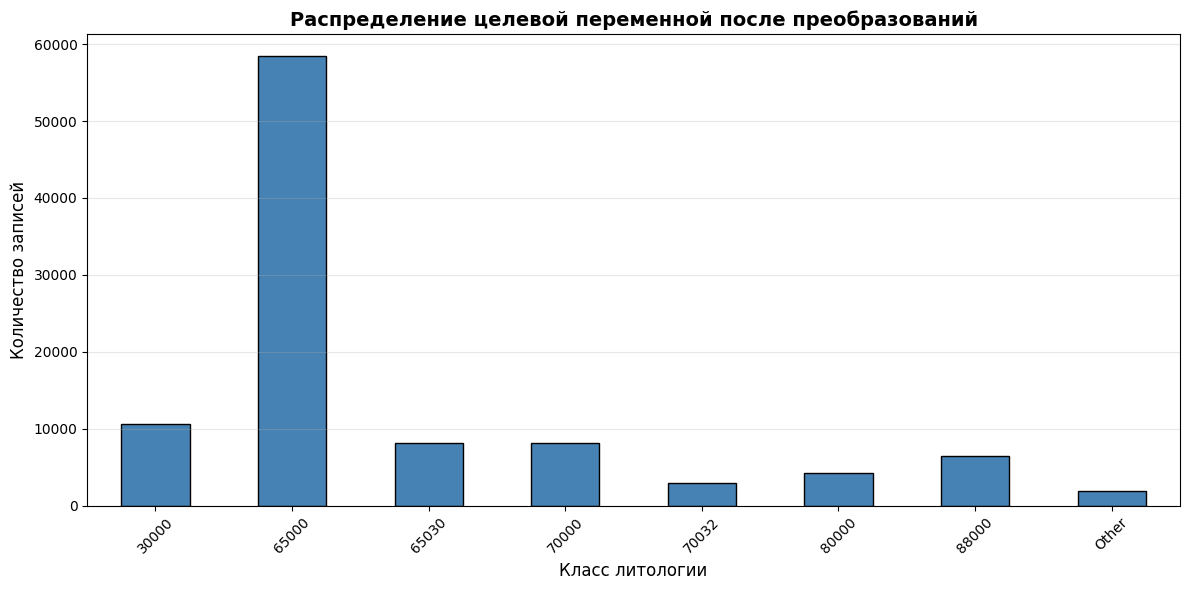

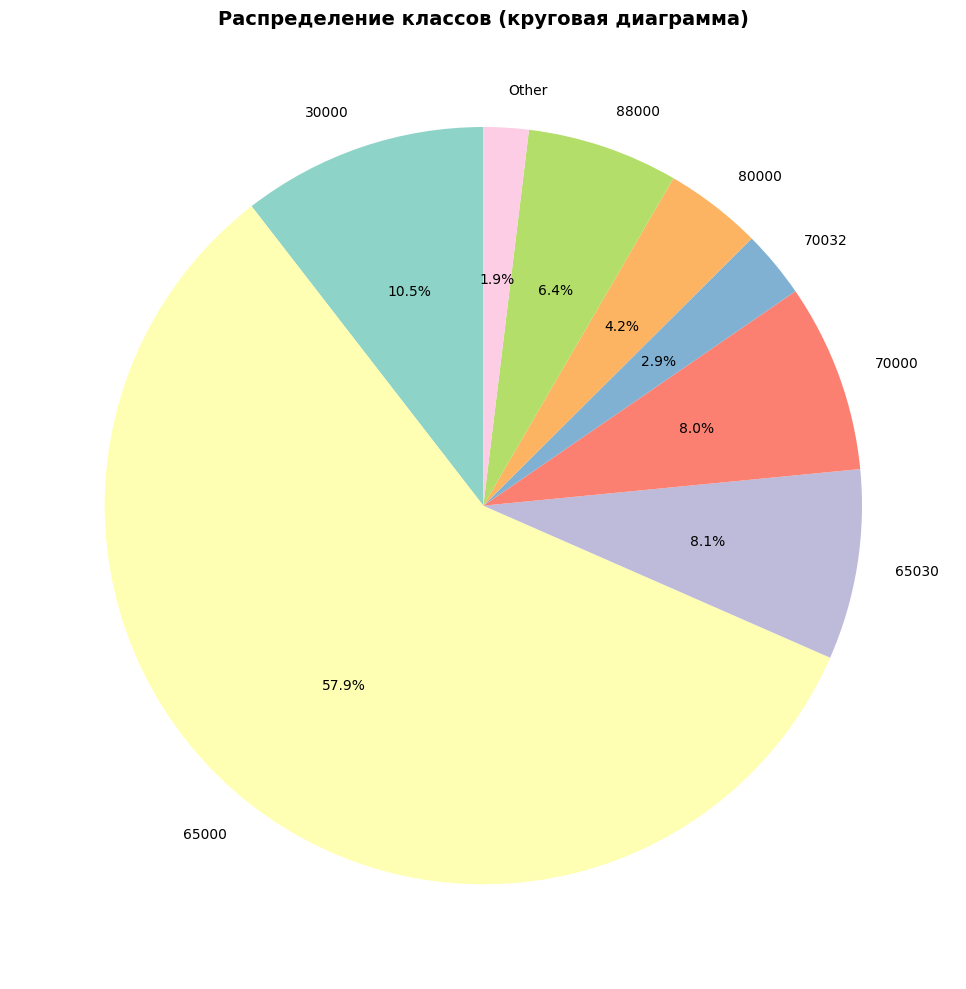


📊 АНАЛИЗ ДИСБАЛАНСА КЛАССОВ:
  Максимальный класс: 58401 записей
  Минимальный класс: 1940 записей
  Соотношение: 30.10:1
  ⚠️ КРИТИЧЕСКИЙ ДИСБАЛАНС! Рекомендуется:
     - Использовать методы балансировки (SMOTE, undersampling, oversampling)
     - Использовать метрики для несбалансированных данных (F1, precision, recall)
     - Применить class_weight='balanced' в моделях

АНАЛИЗ ПРИЗНАКОВ ПОСЛЕ ПРЕОБРАЗОВАНИЙ

📊 ЧИСЛОВЫЕ ПРИЗНАКИ (5):
  ['GR', 'RHOB', 'NPHI', 'DTC', 'RDEP']

  Базовая статистика:
                  GR          RHOB          NPHI            DTC           RDEP
count  100793.000000  94603.000000  89474.000000  100339.000000  100793.000000
mean       70.524258      2.331008      0.320665     108.795454      28.093654
std        37.238531      0.206957      0.127854      30.248587     105.552489
min         1.132300      1.127937     -0.015035      48.268532       0.037163
25%        46.831429      2.187116      0.225147      82.809410       0.828335
50%        70.936447  

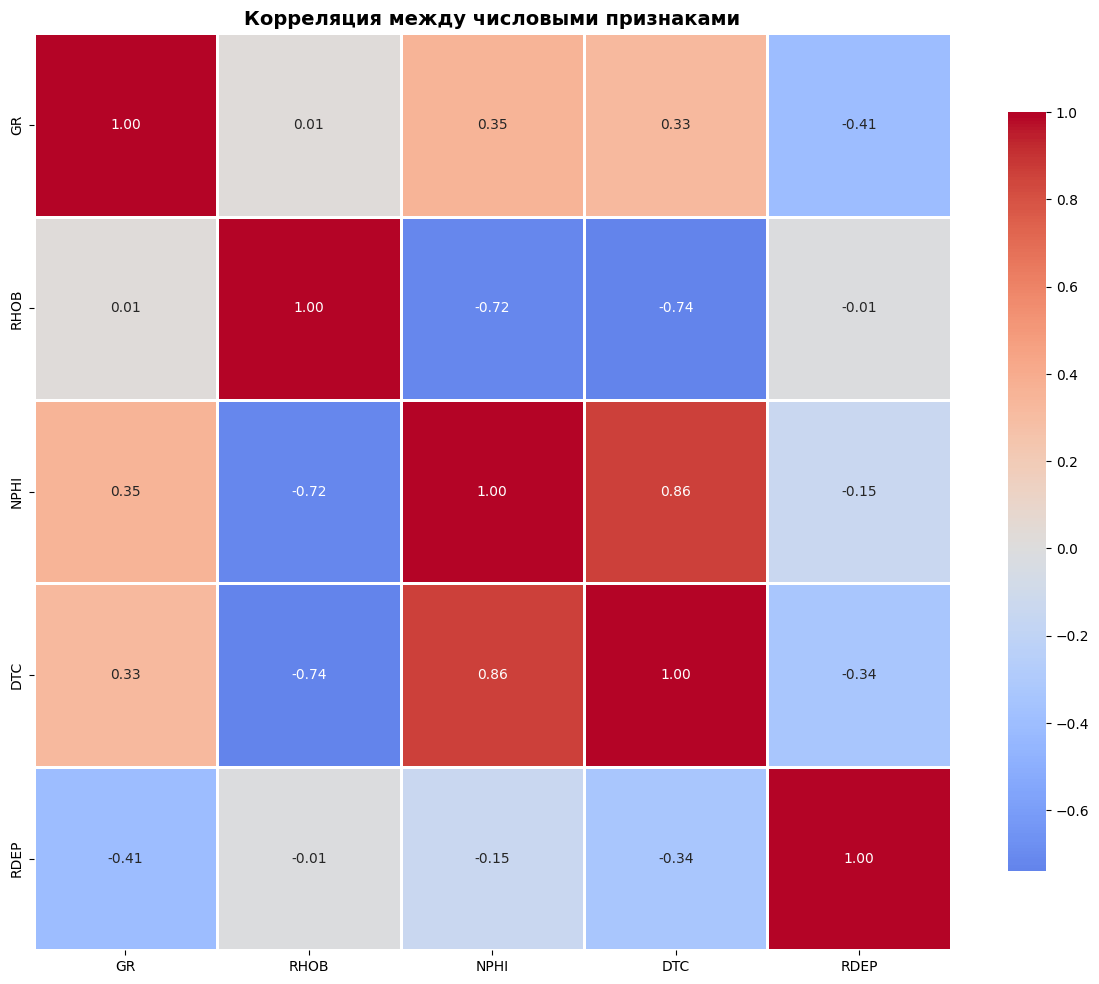


  ⚠️ Обнаружены высокие корреляции (|r| > 0.7):
    RHOB ↔ NPHI: -0.724
    RHOB ↔ DTC: -0.740
    NPHI ↔ DTC: 0.859
  Рекомендуется рассмотреть удаление одного из признаков для избежания мультиколлинеарности

📊 КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ (1):
  ['WELL_NAME']

  WELL_NAME:
    Уникальных значений: 9
    Пропусков: 0
    Топ-5 значений:
      17/4-1: 17271
      34/3-2 S: 12216
      16/2-7: 11683
      15/9-23: 11063
      25/10-9: 10788

ВИЗУАЛИЗАЦИЯ ЗАВИСИМОСТИ ПРИЗНАКОВ ОТ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ


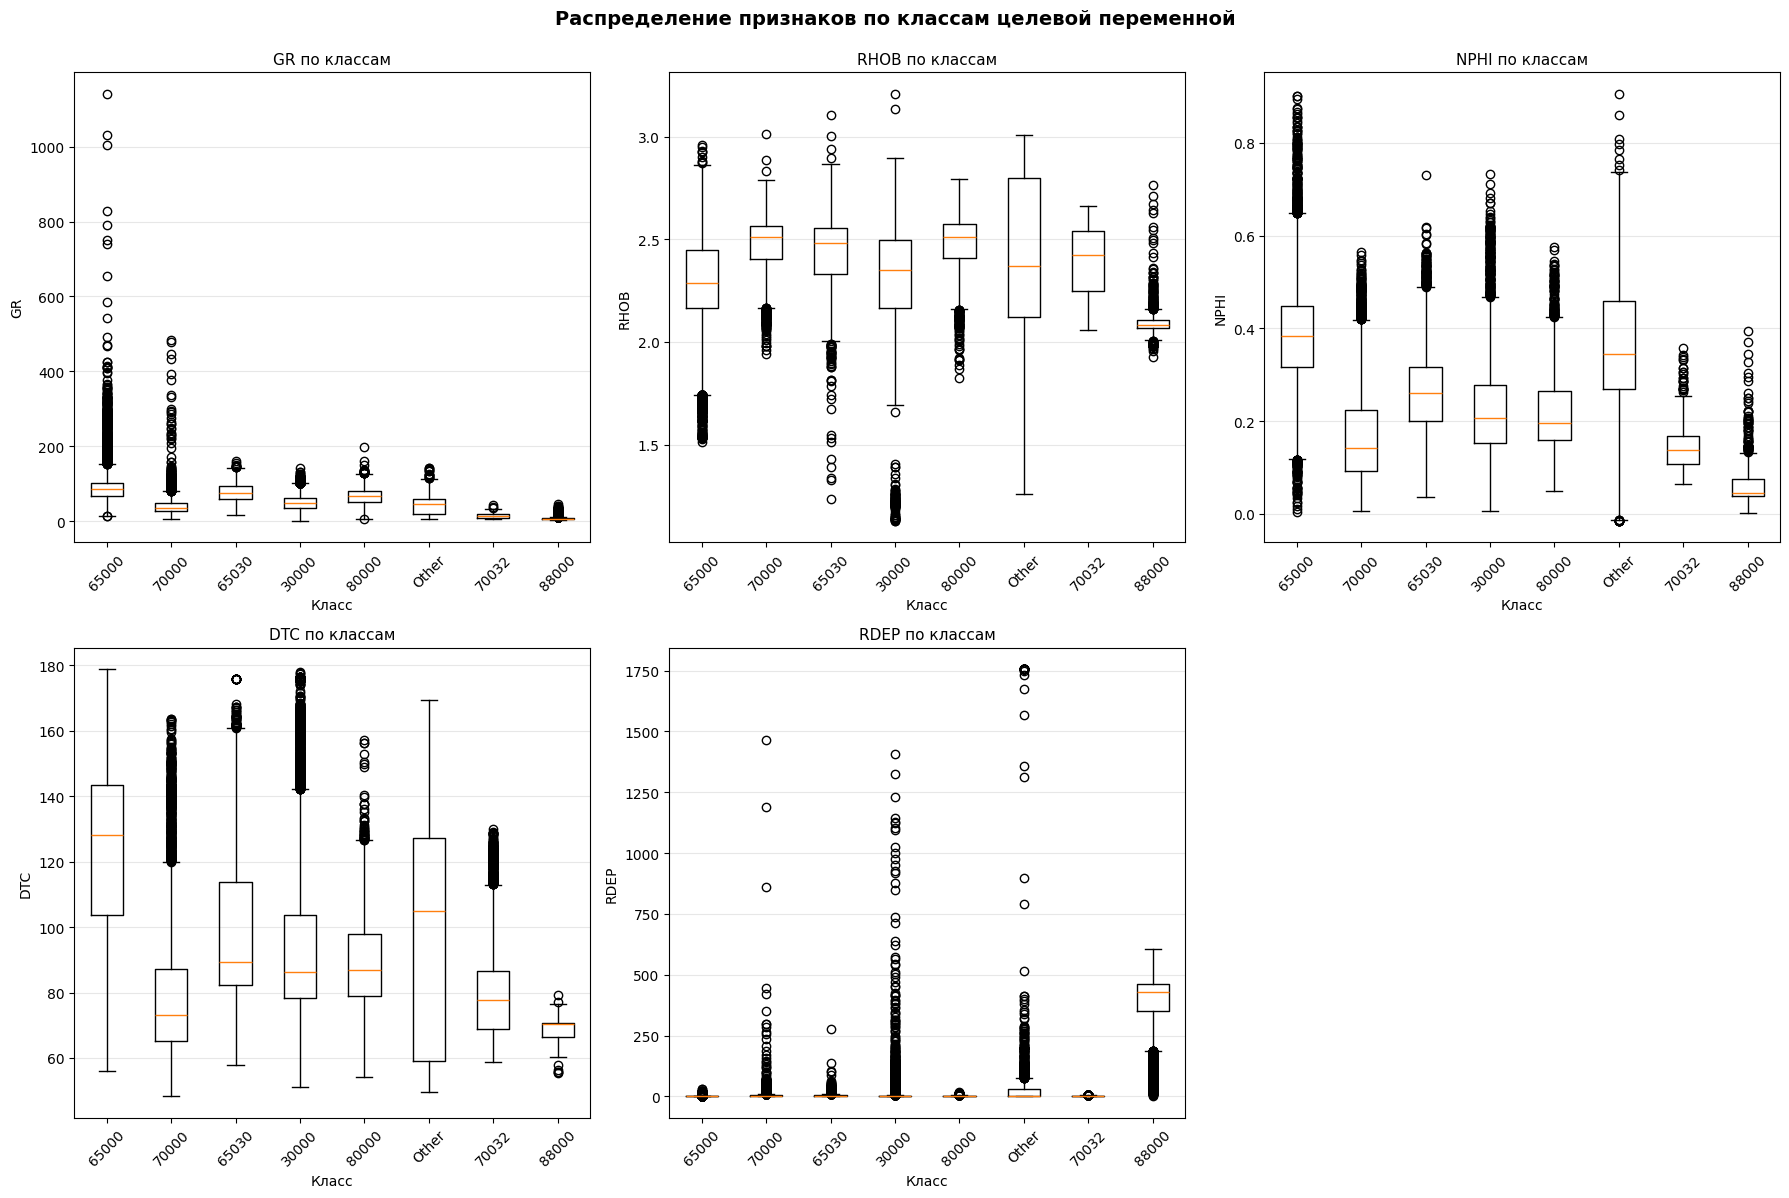


ИТОГОВЫЕ ВЫВОДЫ EDA ПОСЛЕ ПРЕОБРАЗОВАНИЙ

✅ ВЫПОЛНЕННЫЕ ПРЕОБРАЗОВАНИЯ:
  - Объединены редкие значения в категорию 'Other'
  - Удалены неиспользуемые категории

📊 ХАРАКТЕРИСТИКИ ДАННЫХ:
  - Всего записей: 100793
  - Числовых признаков: 5
  - Категориальных признаков: 1
  - Классов целевой переменной: 8
  - Дисбаланс классов: 30.10:1

⚠️ ВАЖНЫЕ ЗАМЕЧАНИЯ:
  - Сильный дисбаланс классов требует специальных подходов
  - Необходимо использовать stratify при разделении данных
  - Рекомендуется применение техник балансировки классов
  - Обнаружены высокие корреляции между признаками
  - Необходимо рассмотреть удаление одного из коррелирующих признаков
  - Обнаружены пропуски: 17963 пропущенных значений (2.55% от всех)
  - Требуется обработка пропусков перед обучением модели

🎯 РЕКОМЕНДАЦИИ ДЛЯ МОДЕЛИ:
  1. Использовать stratify=True при разделении на train/val/test
  2. Обработать пропуски (заполнение или удаление)
  3. Применить методы балансировки классов
  4. Использовать метрики для несб

In [65]:
# Проверяем наличие combined_df
if 'combined_df' not in globals():
    print("⚠️ Переменная 'combined_df' не найдена. Выполните ячейку с загрузкой и преобразованием данных.")
else:
    print("="*80)
    print("EXPLORATORY DATA ANALYSIS (EDA) ПОСЛЕ ПРЕОБРАЗОВАНИЙ")
    print("="*80)
    
    print(f"\n📊 ОБЩАЯ ИНФОРМАЦИЯ О ДАННЫХ:")
    print(f"  Размер датасета: {combined_df.shape[0]} строк × {combined_df.shape[1]} столбцов")
    print(f"  Объем памяти: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print(f"\n📋 СТРУКТУРА ДАННЫХ:")
    print(combined_df.info())
    
    # Проверяем наличие столбца _original и удаляем его если есть
    if 'FORCE_2020_LITHOFACIES_LITHOLOGY_original' in combined_df.columns:
        print(f"\n⚠️ Обнаружен столбец '_original'. Удаляем его из анализа...")
        combined_df = combined_df.drop(columns=['FORCE_2020_LITHOFACIES_LITHOLOGY_original'])
        print(f"✅ Столбец удален")
    
    # ============================================================================
    # АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ПОСЛЕ ПРЕОБРАЗОВАНИЙ
    # ============================================================================
    print("\n" + "="*80)
    print("АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (FORCE_2020_LITHOFACIES_LITHOLOGY)")
    print("="*80)
    
    target_col = 'FORCE_2020_LITHOFACIES_LITHOLOGY'
    if target_col in combined_df.columns:
        print(f"\n📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ ПОСЛЕ ОБЪЕДИНЕНИЯ РЕДКИХ ЗНАЧЕНИЙ:")
        target_dist = combined_df[target_col].value_counts().sort_index()
        total = len(combined_df[target_col].dropna())
        
        for class_val, count in target_dist.items():
            percent = (count / total) * 100
            print(f"  {class_val}: {count} ({percent:.2f}%)")
        
        print(f"\n  Всего классов: {target_dist.nunique()}")
        print(f"  Всего записей (без пропусков): {total}")
        
        # Визуализация распределения целевой переменной
        plt.figure(figsize=(12, 6))
        target_dist.plot(kind='bar', color='steelblue', edgecolor='black')
        plt.title('Распределение целевой переменной после преобразований', fontsize=14, fontweight='bold')
        plt.xlabel('Класс литологии', fontsize=12)
        plt.ylabel('Количество записей', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Круговая диаграмма
        plt.figure(figsize=(10, 10))
        target_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90, 
                        colors=plt.cm.Set3.colors)
        plt.title('Распределение классов (круговая диаграмма)', fontsize=14, fontweight='bold')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
        
        # Анализ дисбаланса
        max_class = target_dist.max()
        min_class = target_dist.min()
        imbalance_ratio = max_class / min_class
        
        print(f"\n📊 АНАЛИЗ ДИСБАЛАНСА КЛАССОВ:")
        print(f"  Максимальный класс: {max_class} записей")
        print(f"  Минимальный класс: {min_class} записей")
        print(f"  Соотношение: {imbalance_ratio:.2f}:1")
        
        if imbalance_ratio > 10:
            print(f"  ⚠️ КРИТИЧЕСКИЙ ДИСБАЛАНС! Рекомендуется:")
            print(f"     - Использовать методы балансировки (SMOTE, undersampling, oversampling)")
            print(f"     - Использовать метрики для несбалансированных данных (F1, precision, recall)")
            print(f"     - Применить class_weight='balanced' в моделях")
        elif imbalance_ratio > 5:
            print(f"  ⚠️ СИЛЬНЫЙ ДИСБАЛАНС. Рекомендуется использовать stratify при разделении")
        elif imbalance_ratio > 2:
            print(f"  ⚠️ Умеренный дисбаланс")
        else:
            print(f"  ✅ Дисбаланс незначителен")
    
    # ============================================================================
    # АНАЛИЗ ПРИЗНАКОВ ПОСЛЕ ПРЕОБРАЗОВАНИЙ
    # ============================================================================
    print("\n" + "="*80)
    print("АНАЛИЗ ПРИЗНАКОВ ПОСЛЕ ПРЕОБРАЗОВАНИЙ")
    print("="*80)
    
    # Разделяем на числовые и категориальные признаки
    numeric_cols = combined_df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = combined_df.select_dtypes(include=['category', 'object']).columns.tolist()
    
    if target_col in categorical_cols:
        categorical_cols.remove(target_col)
    
    print(f"\n📊 ЧИСЛОВЫЕ ПРИЗНАКИ ({len(numeric_cols)}):")
    if len(numeric_cols) > 0:
        print(f"  {numeric_cols}")
        print(f"\n  Базовая статистика:")
        print(combined_df[numeric_cols].describe())
        
        # Пропуски в числовых признаках
        print(f"\n  Пропуски в числовых признаках:")
        missing_numeric = combined_df[numeric_cols].isnull().sum()
        for col in numeric_cols:
            missing_count = missing_numeric[col]
            missing_percent = (missing_count / len(combined_df)) * 100
            if missing_count > 0:
                print(f"    {col}: {missing_count} ({missing_percent:.2f}%)")
        
        # Корреляция между числовыми признаками
        if len(numeric_cols) > 1:
            print(f"\n  Матрица корреляции:")
            corr_matrix = combined_df[numeric_cols].corr()
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                       square=True, linewidths=1, cbar_kws={"shrink": 0.8})
            plt.title('Корреляция между числовыми признаками', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Высокая корреляция
            high_corr_pairs = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    if abs(corr_matrix.iloc[i, j]) > 0.7:
                        high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
            
            if high_corr_pairs:
                print(f"\n  ⚠️ Обнаружены высокие корреляции (|r| > 0.7):")
                for col1, col2, corr_val in high_corr_pairs:
                    print(f"    {col1} ↔ {col2}: {corr_val:.3f}")
                print(f"  Рекомендуется рассмотреть удаление одного из признаков для избежания мультиколлинеарности")
    
    print(f"\n📊 КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ ({len(categorical_cols)}):")
    if len(categorical_cols) > 0:
        print(f"  {categorical_cols}")
        for col in categorical_cols:
            print(f"\n  {col}:")
            value_counts = combined_df[col].value_counts()
            print(f"    Уникальных значений: {value_counts.nunique()}")
            print(f"    Пропусков: {combined_df[col].isnull().sum()}")
            print(f"    Топ-5 значений:")
            for val, count in value_counts.head(5).items():
                print(f"      {val}: {count}")
    
    # ============================================================================
    # ВИЗУАЛИЗАЦИЯ ЗАВИСИМОСТЕЙ
    # ============================================================================
    if target_col in combined_df.columns and len(numeric_cols) > 0:
        print("\n" + "="*80)
        print("ВИЗУАЛИЗАЦИЯ ЗАВИСИМОСТИ ПРИЗНАКОВ ОТ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
        print("="*80)
        
        # Выбираем несколько важных признаков для визуализации
        important_features = numeric_cols[:5]  # Первые 5 числовых признаков
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        for i, feature in enumerate(important_features):
            if i < len(axes):
                # Boxplot по классам
                classes = combined_df[target_col].dropna().unique()
                data_to_plot = [combined_df[combined_df[target_col] == cls][feature].dropna() for cls in classes]
                
                axes[i].boxplot(data_to_plot, labels=classes)
                axes[i].set_title(f'{feature} по классам', fontsize=11)
                axes[i].set_xlabel('Класс')
                axes[i].set_ylabel(feature)
                axes[i].grid(axis='y', alpha=0.3)
                axes[i].tick_params(axis='x', rotation=45)
        
        # Удаляем лишние subplot
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])
        
        plt.suptitle('Распределение признаков по классам целевой переменной', 
                    fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
    
    # ============================================================================
    # ИТОГОВЫЕ ВЫВОДЫ
    # ============================================================================
    print("\n" + "="*80)
    print("ИТОГОВЫЕ ВЫВОДЫ EDA ПОСЛЕ ПРЕОБРАЗОВАНИЙ")
    print("="*80)
    
    print("\n✅ ВЫПОЛНЕННЫЕ ПРЕОБРАЗОВАНИЯ:")
    print("  - Объединены редкие значения в категорию 'Other'")
    print("  - Удалены неиспользуемые категории")
    
    print("\n📊 ХАРАКТЕРИСТИКИ ДАННЫХ:")
    print(f"  - Всего записей: {len(combined_df)}")
    print(f"  - Числовых признаков: {len(numeric_cols)}")
    print(f"  - Категориальных признаков: {len(categorical_cols)}")
    
    if target_col in combined_df.columns:
        print(f"  - Классов целевой переменной: {combined_df[target_col].nunique()}")
        print(f"  - Дисбаланс классов: {imbalance_ratio:.2f}:1")
    
    print("\n⚠️ ВАЖНЫЕ ЗАМЕЧАНИЯ:")
    if imbalance_ratio > 5:
        print("  - Сильный дисбаланс классов требует специальных подходов")
        print("  - Необходимо использовать stratify при разделении данных")
        print("  - Рекомендуется применение техник балансировки классов")
    
    if high_corr_pairs:
        print("  - Обнаружены высокие корреляции между признаками")
        print("  - Необходимо рассмотреть удаление одного из коррелирующих признаков")
    
    missing_total = combined_df.isnull().sum().sum()
    if missing_total > 0:
        missing_percent = (missing_total / (len(combined_df) * len(combined_df.columns))) * 100
        print(f"  - Обнаружены пропуски: {missing_total} пропущенных значений ({missing_percent:.2f}% от всех)")
        print("  - Требуется обработка пропусков перед обучением модели")
    
    print("\n🎯 РЕКОМЕНДАЦИИ ДЛЯ МОДЕЛИ:")
    print("  1. Использовать stratify=True при разделении на train/val/test")
    print("  2. Обработать пропуски (заполнение или удаление)")
    if imbalance_ratio > 5:
        print("  3. Применить методы балансировки классов")
        print("  4. Использовать метрики для несбалансированных данных")
    print("  5. Рассмотреть применение One-Hot Encoding для категориальных признаков")
    print("  6. Провести масштабирование числовых признаков")
    
    print("\n✅ Данные готовы для разделения на train/val/test")

In [66]:
# Удаление признака DTC для избежания мультиколлинеарности
# Обнаружены высокие корреляции:
# - RHOB ↔ NPHI: -0.724
# - RHOB ↔ DTC: -0.740
# - NPHI ↔ DTC: 0.859 (наибольшая корреляция)
# Признак DTC удаляется, так как имеет самую высокую корреляцию с NPHI (0.859)
# и также высокую корреляцию с RHOB (-0.740), что позволяет максимально снизить мультиколлинеарность

if 'combined_df' in globals() and 'DTC' in combined_df.columns:
    combined_df = combined_df.drop(columns=['DTC'])
    print("🗑️ Признак DTC удален для избежания мультиколлинеарности")

🗑️ Признак DTC удален для избежания мультиколлинеарности


In [67]:
# Преобразование целевой переменной из категориальной в числовую (до разделения данных)
from sklearn.preprocessing import LabelEncoder

if 'combined_df' in globals():
    target_col = 'FORCE_2020_LITHOFACIES_LITHOLOGY'
    
    if target_col in combined_df.columns:
        # Проверяем, нужно ли преобразование
        if combined_df[target_col].dtype.name == 'category':
            print(f"\n🔄 Преобразование целевой переменной '{target_col}' из категориальной в числовую...")
            
            # Сохраняем соответствие классов для обратного преобразования при необходимости
            label_encoder = LabelEncoder()
            combined_df[target_col + '_encoded'] = label_encoder.fit_transform(combined_df[target_col])
            
            # Заменяем категориальную переменную на числовую
            combined_df[target_col] = combined_df[target_col + '_encoded'].astype('int64')
            
            # Удаляем временный столбец
            combined_df = combined_df.drop(columns=[target_col + '_encoded'])
            
            # Сохраняем соответствие классов в глобальную переменную
            class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
            
            print(f"✅ Целевая переменная '{target_col}' преобразована в числовую")
            print(f"   Классы: {list(class_mapping.keys())}")
            print(f"   Соответствие: {class_mapping}")
            print(f"   Тип данных после преобразования: {combined_df[target_col].dtype}")
        else:
            print(f"\nℹ️ Целевая переменная '{target_col}' уже числовая (тип: {combined_df[target_col].dtype})")
    else:
        print(f"\n⚠️ Целевая переменная '{target_col}' не найдена в combined_df")
else:
    print("\nℹ️ Переменная 'combined_df' еще не создана. Преобразование будет выполнено после загрузки данных.")



🔄 Преобразование целевой переменной 'FORCE_2020_LITHOFACIES_LITHOLOGY' из категориальной в числовую...
✅ Целевая переменная 'FORCE_2020_LITHOFACIES_LITHOLOGY' преобразована в числовую
   Классы: ['30000', '65000', '65030', '70000', '70032', '80000', '88000', 'Other']
   Соответствие: {'30000': 0, '65000': 1, '65030': 2, '70000': 3, '70032': 4, '80000': 5, '88000': 6, 'Other': 7}
   Тип данных после преобразования: int64


## Преобразование целевой переменной

Целевая переменная `FORCE_2020_LITHOFACIES_LITHOLOGY` была преобразована из категориальной в числовую с помощью Label Encoding.

### Соответствие классов:

| Исходное значение (категория) | Числовое значение |
|-------------------------------|-------------------|
| 30000 | 0 |
| 65000 | 1 |
| 65030 | 2 |
| 70000 | 3 |
| 70032 | 4 |
| 80000 | 5 |
| 88000 | 6 |
| Other | 7 |

**Примечание:** Преобразование выполнено до разделения данных на train/val/test для обеспечения консистентности кодирования классов во всех выборках.


# Разделение данных

In [68]:
# Разделение данных на train/val/test с учетом дисбаланса классов

# Проверяем наличие combined_df
if 'combined_df' not in globals():
    print("⚠️ Переменная 'combined_df' не найдена. Выполните ячейку с загрузкой данных.")
else:
    print("="*80)
    print("РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/VAL/TEST")
    print("="*80)
    
    # Удаляем столбец _original если он существует
    original_col = 'FORCE_2020_LITHOFACIES_LITHOLOGY_original'
    if original_col in combined_df.columns:
        combined_df = combined_df.drop(columns=[original_col])
        print(f"\n✅ Столбец '{original_col}' удален из выборки")
    
    # Проверяем наличие целевой переменной
    target_col = 'FORCE_2020_LITHOFACIES_LITHOLOGY'
    if target_col not in combined_df.columns:
        print(f"⚠️ Целевая переменная '{target_col}' не найдена.")
    else:
        # Подготовка данных: разделяем на признаки (X) и целевую переменную (y)
        X = combined_df.drop(columns=[target_col])
        y = combined_df[target_col]
        
        print(f"\n📊 ИНФОРМАЦИЯ О ДАННЫХ:")
        print(f"  Всего записей: {len(combined_df)}")
        print(f"  Количество признаков: {len(X.columns)}")
        print(f"  Признаки: {list(X.columns)}")
        
        # Анализ дисбаланса классов
        print(f"\n📊 АНАЛИЗ ДИСБАЛАНСА КЛАССОВ:")
        class_distribution = y.value_counts()
        print(f"  Количество классов: {len(class_distribution)}")
        print(f"  Распределение классов:")
        for class_val, count in class_distribution.items():
            percent = (count / len(y)) * 100
            print(f"    {class_val}: {count} ({percent:.2f}%)")
        
        # Определяем дисбаланс
        max_class = class_distribution.max()
        min_class = class_distribution.min()
        imbalance_ratio = max_class / min_class
        print(f"\n  Соотношение максимального к минимальному классу: {imbalance_ratio:.2f}:1")
        
        if imbalance_ratio > 5:
            print(f"  ⚠️ СИЛЬНЫЙ ДИСБАЛАНС КЛАССОВ обнаружен!")
            print(f"     Рекомендуется использовать stratify=True для сохранения пропорций классов")
        elif imbalance_ratio > 2:
            print(f"  ⚠️ Умеренный дисбаланс классов")
        else:
            print(f"  ✅ Дисбаланс классов незначителен")
        
        # Разделение на train/test (70% train, 30% test)
        print(f"\n🔀 РАЗДЕЛЕНИЕ ДАННЫХ:")
        print(f"  Train: 70%")
        print(f"  Val: 15%")
        print(f"  Test: 15%")
        
        # Первое разделение: train (70%) и temp (30%)
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y,
            test_size=0.30,
            random_state=42,
            stratify=y  # Учитываем дисбаланс классов
        )
        
        # Второе разделение: temp (30%) -> val (15%) и test (15%)
        # test_size = 0.5 означает половину от temp (30%), т.е. 15% от исходных данных
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=0.5,  # Половина от temp = 15% от исходных
            random_state=42,
            stratify=y_temp  # Учитываем дисбаланс классов в temp
        )
        
        print(f"\n✅ Разделение выполнено успешно!")
        print(f"\n📊 РЕЗУЛЬТАТЫ РАЗДЕЛЕНИЯ:")
        print(f"  Train: {len(X_train)} записей ({len(X_train)/len(combined_df)*100:.1f}%)")
        print(f"  Val: {len(X_val)} записей ({len(X_val)/len(combined_df)*100:.1f}%)")
        print(f"  Test: {len(X_test)} записей ({len(X_test)/len(combined_df)*100:.1f}%)")
        
        # Проверяем распределение классов в каждой выборке
        print(f"\n📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ ПО ВЫБОРКАМ:")
        
        print(f"\n  Train:")
        train_dist = y_train.value_counts()
        for class_val, count in train_dist.items():
            percent = (count / len(y_train)) * 100
            print(f"    {class_val}: {count} ({percent:.2f}%)")
        
        print(f"\n  Val:")
        val_dist = y_val.value_counts()
        for class_val, count in val_dist.items():
            percent = (count / len(y_val)) * 100
            print(f"    {class_val}: {count} ({percent:.2f}%)")
        
        print(f"\n  Test:")
        test_dist = y_test.value_counts()
        for class_val, count in test_dist.items():
            percent = (count / len(y_test)) * 100
            print(f"    {class_val}: {count} ({percent:.2f}%)")
        
        # Проверяем сохранение пропорций
        print(f"\n✅ ПРОПОРЦИИ КЛАССОВ СОХРАНЕНЫ (благодаря stratify=True)")
        
        print(f"\n💾 Переменные созданы:")
        print(f"  X_train, y_train - обучающая выборка")
        print(f"  X_val, y_val - валидационная выборка")
        print(f"  X_test, y_test - тестовая выборка")
        
        print(f"\n📋 ИТОГО:")
        print(f"  Готово к обучению модели!")
        print(f"  Все выборки сохранены с учетом дисбаланса классов")


РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/VAL/TEST

📊 ИНФОРМАЦИЯ О ДАННЫХ:
  Всего записей: 100793
  Количество признаков: 5
  Признаки: ['GR', 'RHOB', 'NPHI', 'RDEP', 'WELL_NAME']

📊 АНАЛИЗ ДИСБАЛАНСА КЛАССОВ:
  Количество классов: 8
  Распределение классов:
    1: 58401 (57.94%)
    0: 10566 (10.48%)
    2: 8181 (8.12%)
    3: 8104 (8.04%)
    6: 6498 (6.45%)
    5: 4198 (4.16%)
    4: 2905 (2.88%)
    7: 1940 (1.92%)

  Соотношение максимального к минимальному классу: 30.10:1
  ⚠️ СИЛЬНЫЙ ДИСБАЛАНС КЛАССОВ обнаружен!
     Рекомендуется использовать stratify=True для сохранения пропорций классов

🔀 РАЗДЕЛЕНИЕ ДАННЫХ:
  Train: 70%
  Val: 15%
  Test: 15%

✅ Разделение выполнено успешно!

📊 РЕЗУЛЬТАТЫ РАЗДЕЛЕНИЯ:
  Train: 70555 записей (70.0%)
  Val: 15119 записей (15.0%)
  Test: 15119 записей (15.0%)

📊 РАСПРЕДЕЛЕНИЕ КЛАССОВ ПО ВЫБОРКАМ:

  Train:
    1: 40881 (57.94%)
    0: 7396 (10.48%)
    2: 5727 (8.12%)
    3: 5673 (8.04%)
    6: 4548 (6.45%)
    5: 2939 (4.17%)
    4: 2033 (2.88%)
    7: 1358 

## Обработка числовых данных

Заполнение пропусков

In [69]:
# Group-wise imputation для числовых признаков (заполнение пропусков групповыми значениями)
# Важно: вычисляем статистику только на train данных, чтобы избежать утечки данных

print("="*80)
print("GROUP-WISE IMPUTATION ДЛЯ ЧИСЛОВЫХ ПРИЗНАКОВ")
print("="*80)

# Проверяем наличие данных
if 'X_train' not in globals() or 'y_train' not in globals():
    print("⚠️ Переменные X_train и y_train не найдены.")
    print("   Пожалуйста, выполните ячейку с разделением данных.")
elif 'X_val' not in globals() or 'y_val' not in globals():
    print("⚠️ Переменные X_val и y_val не найдены.")
    print("   Пожалуйста, выполните ячейку с разделением данных.")
elif 'X_test' not in globals() or 'y_test' not in globals():
    print("⚠️ Переменные X_test и y_test не найдены.")
    print("   Пожалуйста, выполните ячейку с разделением данных.")
else:
    print(f"\n📊 Информация о данных:")
    print(f"   Train: {X_train.shape}")
    print(f"   Val: {X_val.shape}")
    print(f"   Test: {X_test.shape}")
    
    # Проверяем пропуски в train данных
    print(f"\n🔍 Анализ пропусков в числовых признаках (Train):")
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    missing_in_train = X_train[numeric_cols].isnull().sum()
    
    if missing_in_train.sum() == 0:
        print("   ✅ Пропусков в числовых признаках не обнаружено")
    else:
        print("\n   Пропуски по признакам:")
        for col in numeric_cols:
            if missing_in_train[col] > 0:
                missing_pct = (missing_in_train[col] / len(X_train)) * 100
                print(f"      {col}: {missing_in_train[col]} ({missing_pct:.2f}%)")
        
        # Группируем по WELL_NAME для group-wise imputation
        # Если WELL_NAME есть в данных, используем его для группировки
        if 'WELL_NAME' in X_train.columns:
            group_col = 'WELL_NAME'
            print(f"\n📊 Group-wise imputation по группам '{group_col}'...")
            
            # Объединяем X_train с y_train для использования при необходимости
            train_with_target = X_train.copy()
            train_with_target['_target'] = y_train.values
            
            # Словарь для хранения групповых значений (среднее по группам)
            group_means = {}
            
            # Для каждого числового признака вычисляем среднее по группам только на train данных
            for col in numeric_cols:
                if missing_in_train[col] > 0:
                    # Вычисляем среднее значение по группам (WELL_NAME) только на train
                    means_by_group = train_with_target.groupby(group_col)[col].mean()
                    group_means[col] = means_by_group.to_dict()
                    
                    # Заполняем пропуски в train данных средним по соответствующей группе
                    # Используем безопасный метод через Series для избежания ошибок типов
                    missing_mask = train_with_target[col].isnull()
                    
                    # Создаем Series с групповыми значениями для пропущенных элементов
                    imputed_values = train_with_target.loc[missing_mask, group_col].map(means_by_group).astype(float)
                    
                    # Присваиваем значения через update для безопасности
                    train_with_target.loc[missing_mask, col] = imputed_values
                    
                    # Если для какой-то группы нет данных, используем общее среднее по всем train данным
                    overall_mean = float(train_with_target[col].mean())
                    train_with_target[col] = train_with_target[col].fillna(overall_mean).astype(float)
                    
                    # Обновляем X_train - убеждаемся, что тип float
                    X_train[col] = train_with_target[col].values.astype(float)
                    
                    print(f"   ✅ {col}: заполнено групповыми значениями")
            
            # Удаляем временный столбец
            train_with_target = train_with_target.drop(columns=['_target'])
            
            # Применяем те же групповые значения к val данным (без утечки данных)
            print(f"\n📊 Применение групповых значений к Val данным...")
            
            for col in numeric_cols:
                # Вычисляем общее среднее из train заранее для всех случаев
                overall_mean_train = float(X_train[col].mean())
                
                # Проверяем пропуски в val для этой колонки
                missing_mask = X_val[col].isnull()
                
                if missing_mask.sum() > 0:
                    initial_missing = missing_mask.sum()
                    
                    if col in group_means:
                        # Заполняем пропуски средним по группе (если группа есть в train)
                        # Для каждой пропущенной строки находим группу и соответствующее среднее
                        for idx in X_val[missing_mask].index:
                            group_value = X_val.loc[idx, group_col]
                            # Пытаемся найти среднее для этой группы
                            if group_value in group_means[col]:
                                X_val.loc[idx, col] = group_means[col][group_value]
                            else:
                                # Если группы нет в train, используем общее среднее
                                X_val.loc[idx, col] = overall_mean_train
                    else:
                        # Если колонки не было в group_means (не было пропусков в train), 
                        # просто заполняем общим средним из train
                        X_val.loc[missing_mask, col] = overall_mean_train
                    
                    # Финальное заполнение на случай, если что-то осталось
                    X_val[col] = X_val[col].fillna(overall_mean_train)
                    
                    # Убеждаемся, что тип float
                    X_val[col] = X_val[col].astype(float)
                    
                    # Финальная проверка
                    remaining_missing = X_val[col].isnull().sum()
                    if remaining_missing > 0:
                        print(f"   ⚠️ В {col} осталось {remaining_missing} пропусков после заполнения {initial_missing}, принудительно заполняем")
                        X_val[col] = X_val[col].fillna(overall_mean_train).astype(float)
                    elif initial_missing > 0:
                        print(f"   ✅ {col}: заполнено {initial_missing} пропусков")
                    
            # Применяем те же групповые значения к test данным (без утечки данных)
            print(f"\n📊 Применение групповых значений к Test данным...")
            
            for col in numeric_cols:
                # Вычисляем общее среднее из train заранее для всех случаев
                overall_mean_train = float(X_train[col].mean())
                
                # Проверяем пропуски в test для этой колонки
                missing_mask = X_test[col].isnull()
                
                if missing_mask.sum() > 0:
                    initial_missing = missing_mask.sum()
                    
                    if col in group_means:
                        # Заполняем пропуски средним по группе (если группа есть в train)
                        # Для каждой пропущенной строки находим группу и соответствующее среднее
                        for idx in X_test[missing_mask].index:
                            group_value = X_test.loc[idx, group_col]
                            # Пытаемся найти среднее для этой группы
                            if group_value in group_means[col]:
                                X_test.loc[idx, col] = group_means[col][group_value]
                            else:
                                # Если группы нет в train, используем общее среднее
                                X_test.loc[idx, col] = overall_mean_train
                    else:
                        # Если колонки не было в group_means (не было пропусков в train), 
                        # просто заполняем общим средним из train
                        X_test.loc[missing_mask, col] = overall_mean_train
                    
                    # Финальное заполнение на случай, если что-то осталось
                    X_test[col] = X_test[col].fillna(overall_mean_train)
                    
                    # Убеждаемся, что тип float
                    X_test[col] = X_test[col].astype(float)
                    
                    # Финальная проверка
                    remaining_missing = X_test[col].isnull().sum()
                    if remaining_missing > 0:
                        print(f"   ⚠️ В {col} осталось {remaining_missing} пропусков после заполнения {initial_missing}, принудительно заполняем")
                        X_test[col] = X_test[col].fillna(overall_mean_train).astype(float)
                    elif initial_missing > 0:
                        print(f"   ✅ {col}: заполнено {initial_missing} пропусков")
            
            print(f"\n✅ Group-wise imputation завершен!")
            
        else:
            # Если нет WELL_NAME, используем просто среднее по train данным для всех выборок
            print(f"\n⚠️ Признак 'WELL_NAME' не найден. Используем простое среднее по train данным...")
            
            for col in numeric_cols:
                if missing_in_train[col] > 0:
                    # Вычисляем среднее только на train данных
                    mean_value = float(X_train[col].mean())
                    
                    # Заполняем пропуски в train и преобразуем в float
                    X_train[col] = X_train[col].fillna(mean_value).astype(float)
                    
                    # Заполняем пропуски в val тем же значением из train
                    X_val[col] = X_val[col].fillna(mean_value).astype(float)
                    
                    # Заполняем пропуски в test тем же значением из train
                    X_test[col] = X_test[col].fillna(mean_value).astype(float)
                    
                    print(f"   ✅ {col}: заполнено средним значением из train ({mean_value:.4f})")
            
            print(f"\n✅ Заполнение пропусков завершено!")
    
    # Проверяем результаты
    print(f"\n🔍 Проверка пропусков после заполнения:")
    train_missing_numeric = X_train[numeric_cols].isnull().sum().sum()
    val_missing_numeric = X_val[numeric_cols].isnull().sum().sum()
    test_missing_numeric = X_test[numeric_cols].isnull().sum().sum()
    
    # Проверяем все признаки (включая категориальные)
    train_missing_all = X_train.isnull().sum().sum()
    val_missing_all = X_val.isnull().sum().sum()
    test_missing_all = X_test.isnull().sum().sum()
    
    print(f"\n   Числовые признаки:")
    print(f"      Train: {train_missing_numeric} пропусков")
    print(f"      Val: {val_missing_numeric} пропусков")
    print(f"      Test: {test_missing_numeric} пропусков")
    
    print(f"\n   Все признаки (включая категориальные):")
    print(f"      Train: {train_missing_all} пропусков")
    print(f"      Val: {val_missing_all} пропусков")
    print(f"      Test: {test_missing_all} пропусков")
    
    # Детальная диагностика пропусков
    if val_missing_all > val_missing_numeric or test_missing_all > test_missing_numeric:
        print(f"\n🔍 Детальный анализ пропусков по признакам:")
        
        # Проверяем val
        if val_missing_all > val_missing_numeric:
            print(f"\n   Val (детально по каждому признаку):")
            val_missing_by_col = X_val.isnull().sum()
            for col in X_val.columns:
                if val_missing_by_col[col] > 0:
                    col_type = X_val[col].dtype
                    print(f"      {col} ({col_type}): {val_missing_by_col[col]} пропусков")
        
        # Проверяем test
        if test_missing_all > test_missing_numeric:
            print(f"\n   Test (детально по каждому признаку):")
            test_missing_by_col = X_test.isnull().sum()
            for col in X_test.columns:
                if test_missing_by_col[col] > 0:
                    col_type = X_test[col].dtype
                    print(f"      {col} ({col_type}): {test_missing_by_col[col]} пропусков")
    
    if train_missing_numeric == 0 and val_missing_numeric == 0 and test_missing_numeric == 0:
        print(f"\n✅ Все пропуски в числовых признаках успешно заполнены!")
        if val_missing_all > 0 or test_missing_all > 0:
            print(f"   ⚠️ Однако остались пропуски в категориальных признаках (это нормально, если они не используются для обучения)")
        else:
            print(f"   Данные готовы для обучения моделей")
    else:
        print(f"\n⚠️ Остались пропуски в числовых признаках!")
        print(f"   Проверьте логику заполнения пропусков выше")
    
    print(f"\n💾 Обновлены переменные:")
    print(f"   - X_train: пропуски заполнены")
    print(f"   - X_val: пропуски заполнены (использованы значения из train)")
    print(f"   - X_test: пропуски заполнены (использованы значения из train)")


GROUP-WISE IMPUTATION ДЛЯ ЧИСЛОВЫХ ПРИЗНАКОВ

📊 Информация о данных:
   Train: (70555, 5)
   Val: (15119, 5)
   Test: (15119, 5)

🔍 Анализ пропусков в числовых признаках (Train):

   Пропуски по признакам:
      RHOB: 4323 (6.13%)
      NPHI: 7951 (11.27%)

📊 Group-wise imputation по группам 'WELL_NAME'...
   ✅ RHOB: заполнено групповыми значениями
   ✅ NPHI: заполнено групповыми значениями

📊 Применение групповых значений к Val данным...
   ✅ RHOB: заполнено 926 пропусков
   ✅ NPHI: заполнено 1632 пропусков

📊 Применение групповых значений к Test данным...
   ✅ RHOB: заполнено 941 пропусков
   ✅ NPHI: заполнено 1736 пропусков

✅ Group-wise imputation завершен!

🔍 Проверка пропусков после заполнения:

   Числовые признаки:
      Train: 0 пропусков
      Val: 0 пропусков
      Test: 0 пропусков

   Все признаки (включая категориальные):
      Train: 0 пропусков
      Val: 0 пропусков
      Test: 0 пропусков

✅ Все пропуски в числовых признаках успешно заполнены!
   Данные готовы для обу

In [70]:
# Анализ числовых признаков на пропуски после заполнения

print("="*80)
print("АНАЛИЗ ПРОПУСКОВ В ЧИСЛОВЫХ ПРИЗНАКАХ")
print("="*80)

# Проверяем наличие данных
if 'X_train' not in globals() or 'X_val' not in globals() or 'X_test' not in globals():
    print("⚠️ Переменные X_train, X_val или X_test не найдены.")
    print("   Пожалуйста, выполните ячейки с разделением данных и заполнением пропусков.")
else:
    print(f"\n📊 Информация о данных:")
    print(f"   Train: {X_train.shape}")
    print(f"   Val: {X_val.shape}")
    print(f"   Test: {X_test.shape}")
    
    # Выбираем только числовые признаки
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"\n📋 Числовые признаки ({len(numeric_cols)}):")
    for i, col in enumerate(numeric_cols, 1):
        print(f"   {i}. {col}")
    
    # Анализ пропусков по каждой выборке
    print(f"\n" + "="*80)
    print("АНАЛИЗ ПРОПУСКОВ ПО ВЫБОРКАМ")
    print("="*80)
    
    # Train
    train_missing = X_train[numeric_cols].isnull().sum()
    train_missing_pct = (train_missing / len(X_train)) * 100
    
    # Val
    val_missing = X_val[numeric_cols].isnull().sum()
    val_missing_pct = (val_missing / len(X_val)) * 100
    
    # Test
    test_missing = X_test[numeric_cols].isnull().sum()
    test_missing_pct = (test_missing / len(X_test)) * 100
    
    # Создаем сводную таблицу
    missing_summary = pd.DataFrame({
        'Train (кол-во)': train_missing,
        'Train (%)': train_missing_pct.round(2),
        'Val (кол-во)': val_missing,
        'Val (%)': val_missing_pct.round(2),
        'Test (кол-во)': test_missing,
        'Test (%)': test_missing_pct.round(2)
    })
    
    print(f"\n📊 Сводная таблица пропусков в числовых признаках:")
    print(missing_summary)
    
    # Общая статистика
    print(f"\n📊 ОБЩАЯ СТАТИСТИКА ПРОПУСКОВ:")
    total_train_missing = train_missing.sum()
    total_val_missing = val_missing.sum()
    total_test_missing = test_missing.sum()
    
    print(f"   Train: {total_train_missing} пропусков из {len(X_train) * len(numeric_cols)} значений ({train_missing_pct.sum()/len(numeric_cols):.2f}%)")
    print(f"   Val: {total_val_missing} пропусков из {len(X_val) * len(numeric_cols)} значений ({val_missing_pct.sum()/len(numeric_cols):.2f}%)")
    print(f"   Test: {total_test_missing} пропусков из {len(X_test) * len(numeric_cols)} значений ({test_missing_pct.sum()/len(numeric_cols):.2f}%)")
    
    # Визуализация
    if total_train_missing > 0 or total_val_missing > 0 or total_test_missing > 0:
        print(f"\n📈 Визуализация пропусков:")
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Train
        ax1 = axes[0]
        train_data = train_missing[train_missing > 0]
        if len(train_data) > 0:
            train_data.plot(kind='bar', ax=ax1, color='#e74c3c')
            ax1.set_title('Пропуски в Train (количество)', fontsize=12, fontweight='bold')
            ax1.set_xlabel('Признак')
            ax1.set_ylabel('Количество пропусков')
            ax1.tick_params(axis='x', rotation=45)
            ax1.grid(axis='y', alpha=0.3)
        else:
            ax1.text(0.5, 0.5, 'Нет пропусков', ha='center', va='center', fontsize=14)
            ax1.set_title('Пропуски в Train', fontsize=12, fontweight='bold')
        
        # 2. Val
        ax2 = axes[1]
        val_data = val_missing[val_missing > 0]
        if len(val_data) > 0:
            val_data.plot(kind='bar', ax=ax2, color='#f39c12')
            ax2.set_title('Пропуски в Val (количество)', fontsize=12, fontweight='bold')
            ax2.set_xlabel('Признак')
            ax2.set_ylabel('Количество пропусков')
            ax2.tick_params(axis='x', rotation=45)
            ax2.grid(axis='y', alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'Нет пропусков', ha='center', va='center', fontsize=14)
            ax2.set_title('Пропуски в Val', fontsize=12, fontweight='bold')
        
        # 3. Test
        ax3 = axes[2]
        test_data = test_missing[test_missing > 0]
        if len(test_data) > 0:
            test_data.plot(kind='bar', ax=ax3, color='#3498db')
            ax3.set_title('Пропуски в Test (количество)', fontsize=12, fontweight='bold')
            ax3.set_xlabel('Признак')
            ax3.set_ylabel('Количество пропусков')
            ax3.tick_params(axis='x', rotation=45)
            ax3.grid(axis='y', alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'Нет пропусков', ha='center', va='center', fontsize=14)
            ax3.set_title('Пропуски в Test', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Сравнительная визуализация процентов
        fig, ax = plt.subplots(figsize=(12, 6))
        
        comparison_data = pd.DataFrame({
            'Train (%)': train_missing_pct,
            'Val (%)': val_missing_pct,
            'Test (%)': test_missing_pct
        })
        
        comparison_data.plot(kind='bar', ax=ax, color=['#e74c3c', '#f39c12', '#3498db'])
        ax.set_title('Процент пропусков по признакам (сравнение выборок)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Признак')
        ax.set_ylabel('Процент пропусков (%)')
        ax.set_xticklabels(comparison_data.index, rotation=45, ha='right')
        ax.legend(loc='upper right')
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Проверяем пропуски во всех признаках (не только числовых)
    print(f"\n" + "="*80)
    print("АНАЛИЗ ВСЕХ ПРИЗНАКОВ (ВКЛЮЧАЯ КАТЕГОРИАЛЬНЫЕ)")
    print("="*80)
    
    all_cols = X_train.columns.tolist()
    train_missing_all = X_train[all_cols].isnull().sum()
    val_missing_all = X_val[all_cols].isnull().sum()
    test_missing_all = X_test[all_cols].isnull().sum()
    
    total_train_all = train_missing_all.sum()
    total_val_all = val_missing_all.sum()
    total_test_all = test_missing_all.sum()
    
    print(f"\n📊 Пропуски во всех признаках:")
    print(f"   Train: {total_train_all} пропусков")
    print(f"   Val: {total_val_all} пропусков")
    print(f"   Test: {total_test_all} пропусков")
    
    # Показываем детально, какие признаки имеют пропуски
    if total_val_all > 0 or total_test_all > 0:
        print(f"\n🔍 Детальный анализ пропусков по признакам:")
        
        for col in all_cols:
            train_col_missing = train_missing_all[col]
            val_col_missing = val_missing_all[col]
            test_col_missing = test_missing_all[col]
            
            if train_col_missing > 0 or val_col_missing > 0 or test_col_missing > 0:
                col_type = X_train[col].dtype
                is_numeric = col in numeric_cols
                print(f"\n   {col} (тип: {col_type}, числовой: {'да' if is_numeric else 'нет'}):")
                print(f"      Train: {train_col_missing} пропусков")
                print(f"      Val: {val_col_missing} пропусков")
                print(f"      Test: {test_col_missing} пропусков")
    
    # Итоговый вывод
    print(f"\n" + "="*80)
    print("ИТОГОВЫЙ ВЫВОД")
    print("="*80)
    
    if total_train_missing == 0 and total_val_missing == 0 and total_test_missing == 0:
        print("\n✅ ВСЕ ПРОПУСКИ В ЧИСЛОВЫХ ПРИЗНАКАХ УСПЕШНО ЗАПОЛНЕНЫ!")
        if total_val_all > total_val_missing or total_test_all > total_test_missing:
            print(f"\n⚠️ ОБНАРУЖЕНЫ ПРОПУСКИ В КАТЕГОРИАЛЬНЫХ ПРИЗНАКАХ:")
            print(f"   Val: {total_val_all - total_val_missing} пропусков в категориальных признаках")
            print(f"   Test: {total_test_all - total_test_missing} пропусков в категориальных признаках")
            print(f"\n   Это нормально, если категориальные признаки (например, WELL_NAME) будут закодированы отдельно.")
            print(f"   Для обучения моделей используются только числовые признаки.")
        else:
            print("   Данные готовы для обучения моделей")
    else:
        print("\n⚠️ ОБНАРУЖЕНЫ ПРОПУСКИ В ЧИСЛОВЫХ ПРИЗНАКАХ:")
        if total_train_missing > 0:
            print(f"   Train: {total_train_missing} пропусков")
        if total_val_missing > 0:
            print(f"   Val: {total_val_missing} пропусков")
        if total_test_missing > 0:
            print(f"   Test: {total_test_missing} пропусков")
        print("\n💡 Рекомендации:")
        print("   - Проверьте, что ячейка с заполнением пропусков выполнена")
        print("   - Перезапустите ячейку с заполнением пропусков")
        print("   - Проверьте логику заполнения пропусков в коде")
    
    # Дополнительная информация о типах данных
    print(f"\n📋 Типы данных числовых признаков:")
    for col in numeric_cols:
        print(f"   {col}: {X_train[col].dtype}")
    
    print(f"\n✅ Анализ завершен")


АНАЛИЗ ПРОПУСКОВ В ЧИСЛОВЫХ ПРИЗНАКАХ

📊 Информация о данных:
   Train: (70555, 5)
   Val: (15119, 5)
   Test: (15119, 5)

📋 Числовые признаки (4):
   1. GR
   2. RHOB
   3. NPHI
   4. RDEP

АНАЛИЗ ПРОПУСКОВ ПО ВЫБОРКАМ

📊 Сводная таблица пропусков в числовых признаках:
      Train (кол-во)  Train (%)  Val (кол-во)  Val (%)  Test (кол-во)  \
GR                 0        0.0             0      0.0              0   
RHOB               0        0.0             0      0.0              0   
NPHI               0        0.0             0      0.0              0   
RDEP               0        0.0             0      0.0              0   

      Test (%)  
GR         0.0  
RHOB       0.0  
NPHI       0.0  
RDEP       0.0  

📊 ОБЩАЯ СТАТИСТИКА ПРОПУСКОВ:
   Train: 0 пропусков из 282220 значений (0.00%)
   Val: 0 пропусков из 60476 значений (0.00%)
   Test: 0 пропусков из 60476 значений (0.00%)

АНАЛИЗ ВСЕХ ПРИЗНАКОВ (ВКЛЮЧАЯ КАТЕГОРИАЛЬНЫЕ)

📊 Пропуски во всех признаках:
   Train: 0 пропусков
   V

# Подготовка к pipeline

СОЗДАНИЕ И ОБУЧЕНИЕ PIPELINE С 5 МОДЕЛЯМИ

📊 Информация о данных:
   X_train: (70555, 5)
   X_val: (15119, 5)
   y_train: (70555,)
   y_val: (15119,)

📋 Классификация признаков:
   Числовые признаки (4): ['GR', 'RHOB', 'NPHI', 'RDEP']
   Категориальные признаки (1): ['WELL_NAME']

✅ ColumnTransformer создан:
   - RobustScaler для числовых признаков
   - OneHotEncoder для категориальных признаков

📦 Создан пул из 5 моделей:
   - Logistic Regression
   - KNN
   - Decision Tree
   - Random Forest
   - Gradient Boosting

ОБУЧЕНИЕ МОДЕЛЕЙ

🔄 Обучение модели: Logistic Regression
   ⏳ Обучение на train данных (70555 записей)...
   🔍 Оценка на validation данных (15119 записей)...
   ✅ Обучение завершено!
      Accuracy: 0.8223
      F1-score (weighted): 0.7993

🔄 Обучение модели: KNN
   ⏳ Обучение на train данных (70555 записей)...
   🔍 Оценка на validation данных (15119 записей)...
   ✅ Обучение завершено!
      Accuracy: 0.9176
      F1-score (weighted): 0.9160

🔄 Обучение модели: Decision T

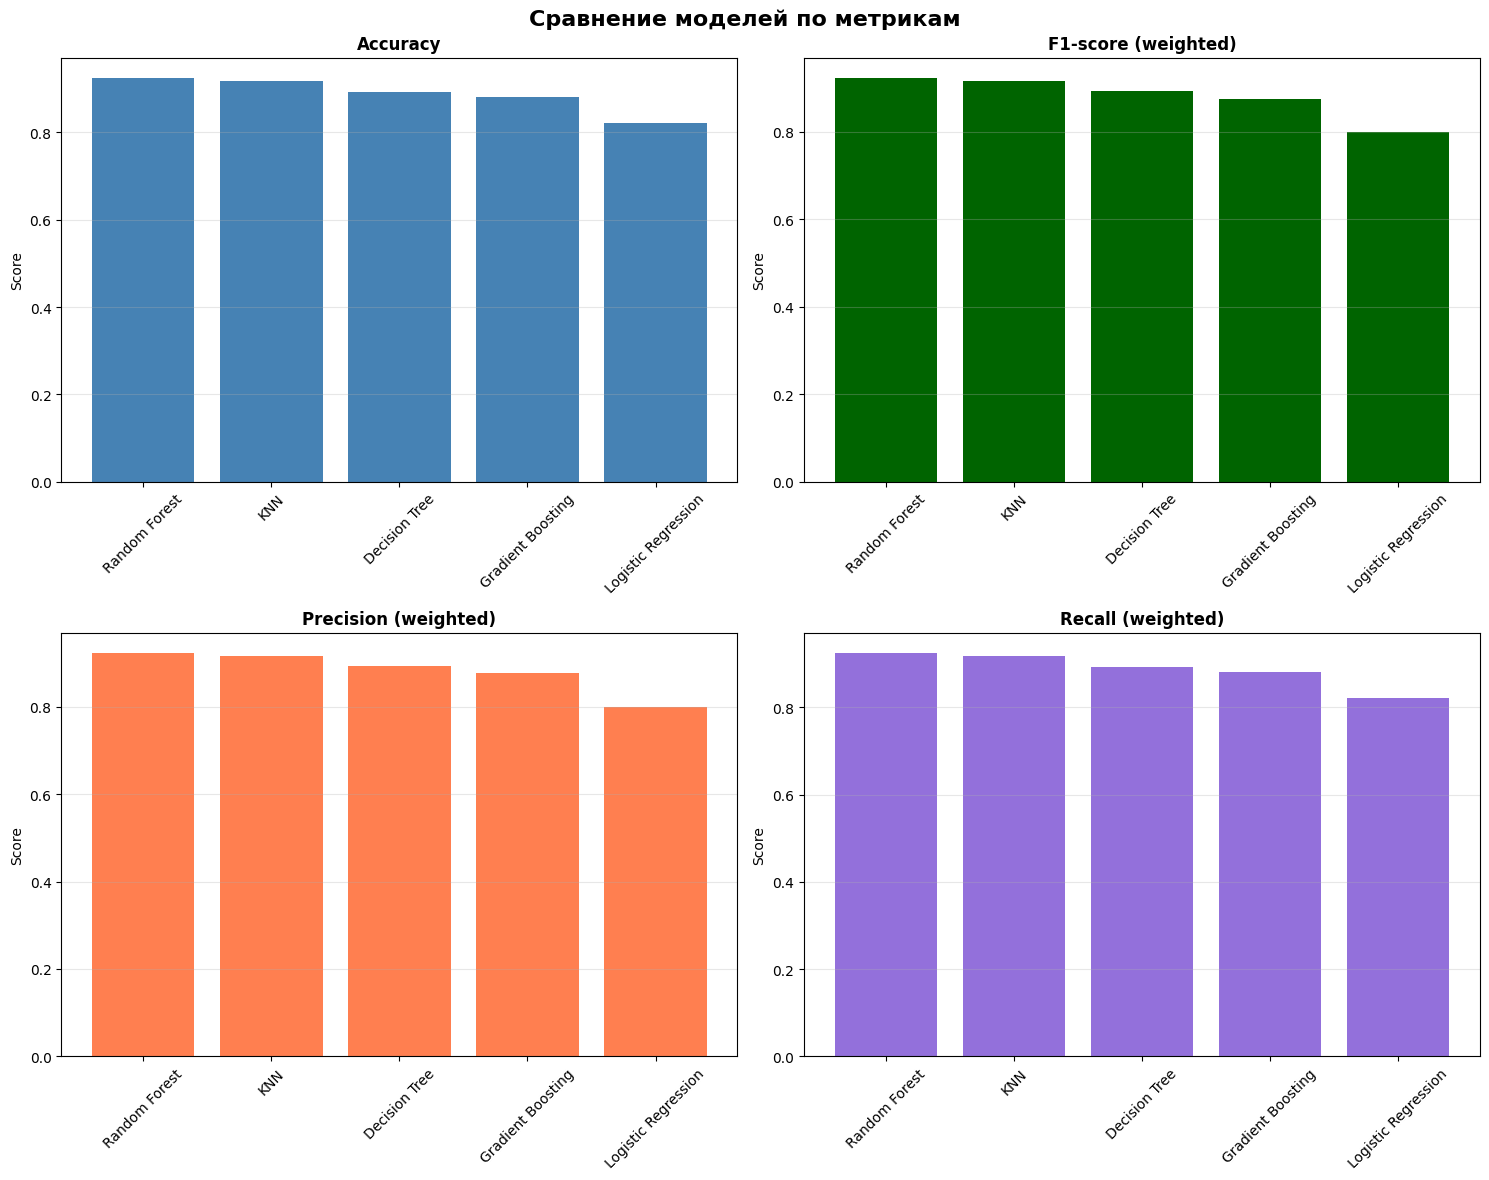

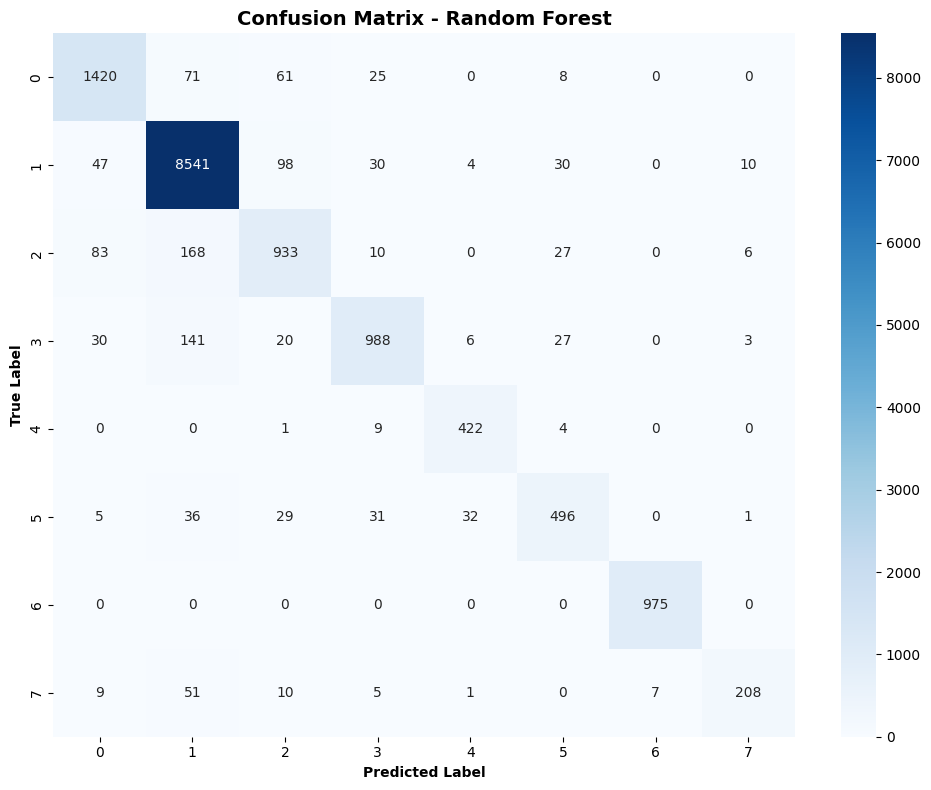


✅ Pipeline обучен и оценен!

💾 Сохранены переменные:
   - best_pipeline: обученный pipeline лучшей модели
   - best_model_name: название лучшей модели
   - results_df: DataFrame с результатами всех моделей
   - trained_pipelines: словарь всех обученных pipelines


In [71]:
# ================================================================================
# PIPELINE ДЛЯ ОБУЧЕНИЯ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ
# ================================================================================
# Pipeline включает:
# 1. RobustScaler для числовых признаков (устойчив к выбросам)
# 2. OneHotEncoder для категориальных признаков
# 3. Обучение 5 моделей: Logistic Regression, KNN, Decision Tree, Random Forest, Gradient Boosting
# ================================================================================

print("="*80)
print("СОЗДАНИЕ И ОБУЧЕНИЕ PIPELINE С 5 МОДЕЛЯМИ")
print("="*80)

# Проверяем наличие данных
if 'X_train' not in globals() or 'y_train' not in globals():
    print("⚠️ Переменные X_train и y_train не найдены.")
    print("   Пожалуйста, выполните ячейки с загрузкой и разделением данных.")
elif 'X_val' not in globals() or 'y_val' not in globals():
    print("⚠️ Переменные X_val и y_val не найдены.")
    print("   Пожалуйста, выполните ячейку с разделением данных.")
else:
    print(f"\n📊 Информация о данных:")
    print(f"   X_train: {X_train.shape}")
    print(f"   X_val: {X_val.shape}")
    print(f"   y_train: {y_train.shape}")
    print(f"   y_val: {y_val.shape}")
    
    # Определяем числовые и категориальные признаки
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()
    
    print(f"\n📋 Классификация признаков:")
    print(f"   Числовые признаки ({len(numeric_features)}): {numeric_features}")
    print(f"   Категориальные признаки ({len(categorical_features)}): {categorical_features}")
    
    # Создаем ColumnTransformer для предобработки
    # RobustScaler для числовых признаков (устойчив к выбросам)
    # OneHotEncoder для категориальных признаков (с drop='first' для уменьшения размерности)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    
    print(f"\n✅ ColumnTransformer создан:")
    print(f"   - RobustScaler для числовых признаков")
    print(f"   - OneHotEncoder для категориальных признаков")
    
    # Создаем пул из 5 моделей с default параметрами
    models_pool = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    print(f"\n📦 Создан пул из {len(models_pool)} моделей:")
    for name in models_pool.keys():
        print(f"   - {name}")
    
    # Словарь для хранения результатов
    results = {}
    trained_pipelines = {}
    
    print(f"\n" + "="*80)
    print("ОБУЧЕНИЕ МОДЕЛЕЙ")
    print("="*80)
    
    # Обучаем каждую модель через pipeline
    for model_name, model in models_pool.items():
        print(f"\n🔄 Обучение модели: {model_name}")
        
        try:
            # Создаем pipeline: предобработка -> модель
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])
            
            # Обучение на train данных
            print(f"   ⏳ Обучение на train данных ({len(X_train)} записей)...")
            pipeline.fit(X_train, y_train)
            
            # Предсказания на validation данных
            print(f"   🔍 Оценка на validation данных ({len(X_val)} записей)...")
            y_val_pred = pipeline.predict(X_val)
            
            # Вычисление метрик
            accuracy = accuracy_score(y_val, y_val_pred)
            precision_macro = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
            precision_weighted = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
            recall_macro = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
            recall_weighted = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
            f1_macro = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
            f1_weighted = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)
            
            # Сохраняем результаты
            results[model_name] = {
                'Accuracy': accuracy,
                'Precision (macro)': precision_macro,
                'Precision (weighted)': precision_weighted,
                'Recall (macro)': recall_macro,
                'Recall (weighted)': recall_weighted,
                'F1-score (macro)': f1_macro,
                'F1-score (weighted)': f1_weighted
            }
            
            trained_pipelines[model_name] = pipeline
            
            print(f"   ✅ Обучение завершено!")
            print(f"      Accuracy: {accuracy:.4f}")
            print(f"      F1-score (weighted): {f1_weighted:.4f}")
            
        except Exception as e:
            print(f"   ❌ Ошибка при обучении модели {model_name}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    # Выводим результаты всех моделей
    if results:
        print(f"\n" + "="*80)
        print("РЕЗУЛЬТАТЫ ВСЕХ МОДЕЛЕЙ")
        print("="*80)
        
        # Создаем DataFrame с результатами
        results_df = pd.DataFrame(results).T
        results_df = results_df.sort_values('F1-score (weighted)', ascending=False)
        
        print(f"\n📊 Сводная таблица метрик:")
        print(results_df.to_string())
        
        # Находим лучшую модель по F1-score (weighted)
        best_model_name = results_df.index[0]
        best_pipeline = trained_pipelines[best_model_name]
        
        print(f"\n" + "="*80)
        print(f"🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
        print("="*80)
        print(f"\n📊 Метрики лучшей модели:")
        for metric, value in results_df.loc[best_model_name].items():
            print(f"   {metric}: {value:.4f}")
        
        # Детальный отчет для лучшей модели
        print(f"\n📋 Classification Report для лучшей модели ({best_model_name}):")
        y_val_pred_best = best_pipeline.predict(X_val)
        print(classification_report(y_val, y_val_pred_best))
        
        # Confusion Matrix для лучшей модели
        print(f"\n📊 Confusion Matrix для лучшей модели ({best_model_name}):")
        cm = confusion_matrix(y_val, y_val_pred_best)
        print(cm)
        
        # Визуализация метрик
        print(f"\n📈 Визуализация метрик...")
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Сравнение моделей по метрикам', fontsize=16, fontweight='bold')
        
        # Accuracy
        axes[0, 0].bar(results_df.index, results_df['Accuracy'], color='steelblue')
        axes[0, 0].set_title('Accuracy', fontweight='bold')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        # F1-score (weighted)
        axes[0, 1].bar(results_df.index, results_df['F1-score (weighted)'], color='darkgreen')
        axes[0, 1].set_title('F1-score (weighted)', fontweight='bold')
        axes[0, 1].set_ylabel('Score')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        # Precision (weighted)
        axes[1, 0].bar(results_df.index, results_df['Precision (weighted)'], color='coral')
        axes[1, 0].set_title('Precision (weighted)', fontweight='bold')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        # Recall (weighted)
        axes[1, 1].bar(results_df.index, results_df['Recall (weighted)'], color='mediumpurple')
        axes[1, 1].set_title('Recall (weighted)', fontweight='bold')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Визуализация Confusion Matrix для лучшей модели
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
        plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontweight='bold')
        plt.xlabel('Predicted Label', fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Сохраняем лучшую модель в глобальную переменную
        globals()['best_pipeline'] = best_pipeline
        globals()['best_model_name'] = best_model_name
        globals()['results_df'] = results_df
        globals()['trained_pipelines'] = trained_pipelines
        
        print(f"\n✅ Pipeline обучен и оценен!")
        print(f"\n💾 Сохранены переменные:")
        print(f"   - best_pipeline: обученный pipeline лучшей модели")
        print(f"   - best_model_name: название лучшей модели")
        print(f"   - results_df: DataFrame с результатами всех моделей")
        print(f"   - trained_pipelines: словарь всех обученных pipelines")
        
    else:
        print(f"\n⚠️ Ни одна модель не была успешно обучена!")
        print(f"   Проверьте ошибки выше и исправьте проблемы.")


CROSS-VALIDATION АНАЛИЗ ДЛЯ ВСЕХ МОДЕЛЕЙ



📊 Информация о данных для Cross-Validation:
   Всего записей: 85674
   Размерность признаков: 5
   Количество классов: 8

📋 Классификация признаков:
   Числовые признаки (4): ['GR', 'RHOB', 'NPHI', 'RDEP']
   Категориальные признаки (1): ['WELL_NAME']

📦 Модели для оценки:
   - Logistic Regression
   - KNN
   - Decision Tree
   - Random Forest
   - Gradient Boosting

🔄 Настройка Cross-Validation:
   Количество фолдов: 5
   Тип: Stratified K-Fold (сохраняет баланс классов)
   Shuffle: True (перемешивание данных)

📊 Метрики для оценки:
   - Accuracy
   - Precision (macro, weighted)
   - Recall (macro, weighted)
   - F1-score (macro, weighted)

ВЫПОЛНЕНИЕ CROSS-VALIDATION

🔄 Cross-Validation для модели: Logistic Regression
   ⏳ Выполнение 5-fold Cross-Validation...
   ✅ Cross-Validation завершена!
      Accuracy: 0.8218 (+/- 0.0023)
      F1-score (weighted): 0.7985 (+/- 0.0028)

🔄 Cross-Validation для модели: KNN
   ⏳ Выполнение 5-fold Cross-Validation...
   ✅ Cross-Validation завершена

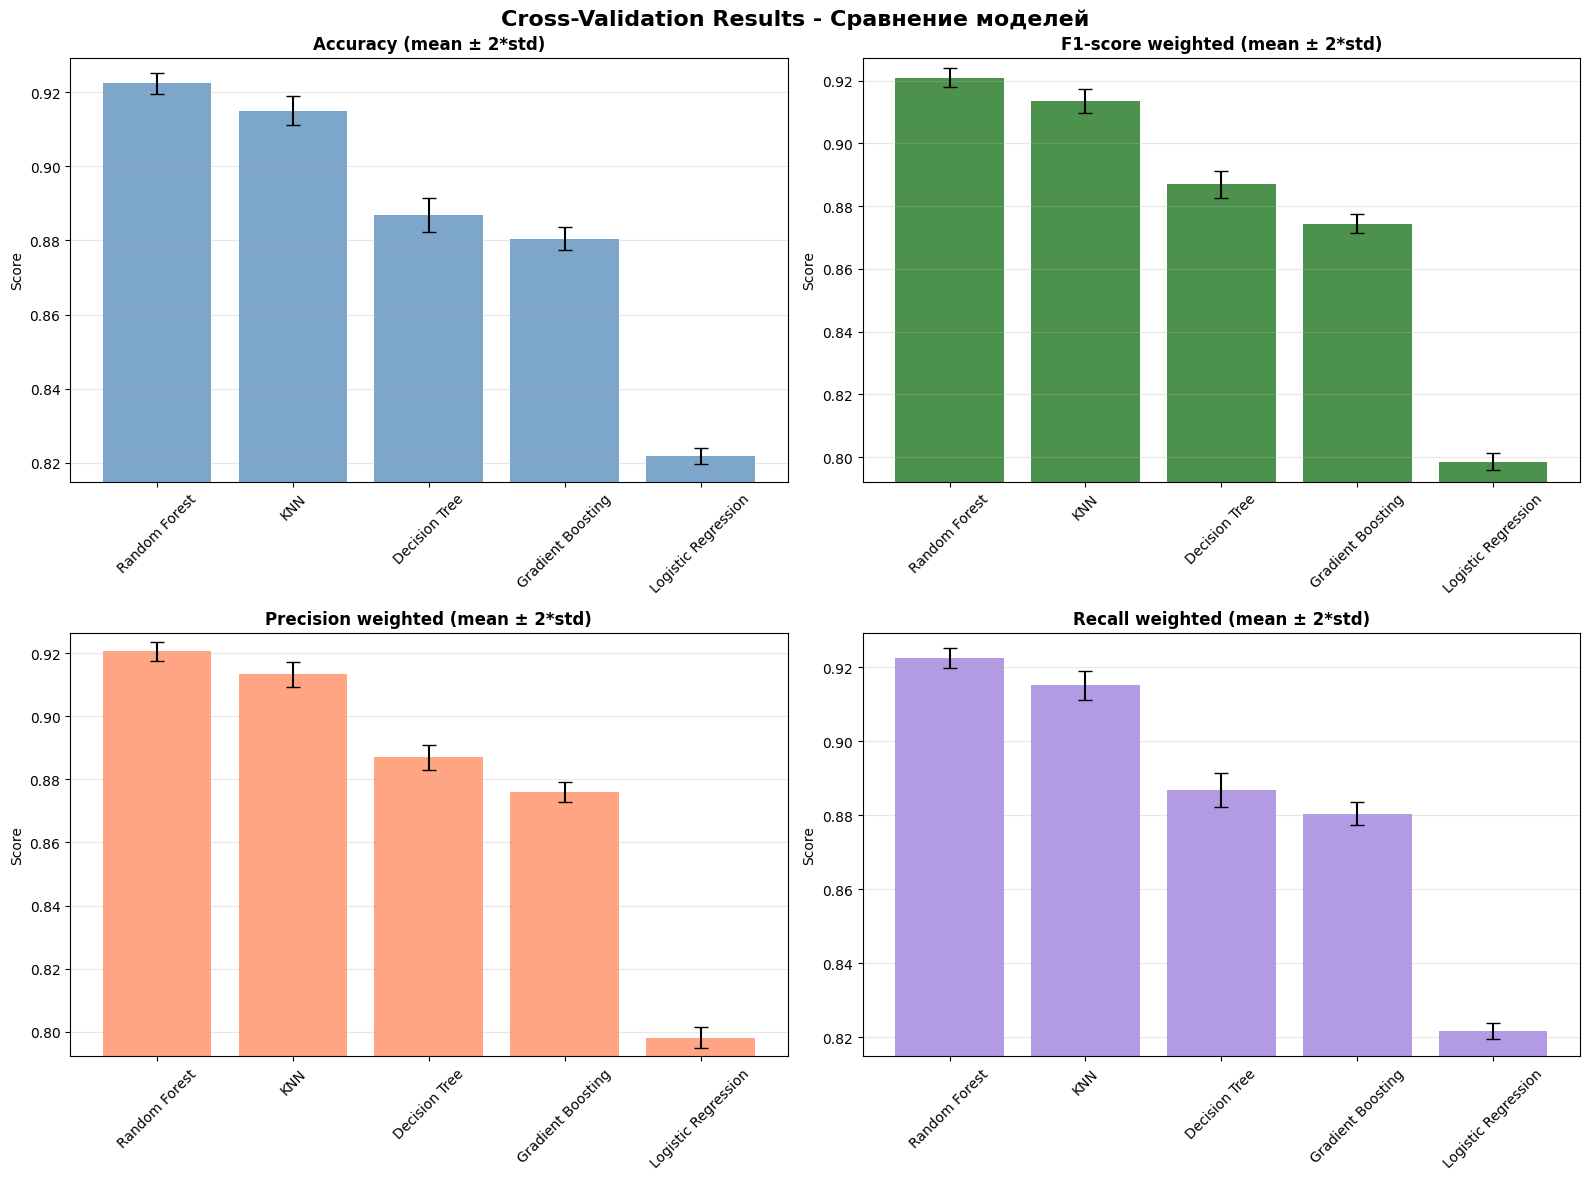


📊 Анализ переобучения для лучшей модели (Random Forest):
   F1-score (weighted) - Train: 1.0000 ± 0.0000
   F1-score (weighted) - Test: 0.9209 ± 0.0015
   ✅ Разрыв между train и test приемлемый (0.0791)

✅ Cross-Validation анализ завершен!

💾 Сохранены переменные:
   - cv_results_df: DataFrame с результатами Cross-Validation всех моделей
   - cv_results_all: Словарь с детальными результатами Cross-Validation
   - best_cv_model_name: Название лучшей модели по Cross-Validation


In [72]:
# ================================================================================
# CROSS-VALIDATION АНАЛИЗ ДЛЯ ВСЕХ МОДЕЛЕЙ
# ================================================================================
# Оценка моделей с использованием кросс-валидации (Stratified K-Fold)
# Обеспечивает более надежную оценку производительности модели
# ================================================================================

print("="*80)
print("CROSS-VALIDATION АНАЛИЗ ДЛЯ ВСЕХ МОДЕЛЕЙ")
print("="*80)

# Проверяем наличие данных
if 'X_train' not in globals() or 'y_train' not in globals():
    print("⚠️ Переменные X_train и y_train не найдены.")
    print("   Пожалуйста, выполните ячейки с загрузкой и разделением данных.")
else:
    # Объединяем train и validation для кросс-валидации
    # Это даст больше данных для более надежной оценки
    X_cv = pd.concat([X_train, X_val], ignore_index=True)
    y_cv = pd.concat([y_train, y_val], ignore_index=True)
    
    print(f"\n📊 Информация о данных для Cross-Validation:")
    print(f"   Всего записей: {len(X_cv)}")
    print(f"   Размерность признаков: {X_cv.shape[1]}")
    print(f"   Количество классов: {y_cv.nunique()}")
    
    # Определяем числовые и категориальные признаки
    numeric_features = X_cv.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_cv.select_dtypes(include=['category', 'object']).columns.tolist()
    
    print(f"\n📋 Классификация признаков:")
    print(f"   Числовые признаки ({len(numeric_features)}): {numeric_features}")
    print(f"   Категориальные признаки ({len(categorical_features)}): {categorical_features}")
    
    # Создаем ColumnTransformer для предобработки
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    
    # Создаем пул из 5 моделей с default параметрами
    models_pool = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    print(f"\n📦 Модели для оценки:")
    for name in models_pool.keys():
        print(f"   - {name}")
    
    # Настройка кросс-валидации
    # Используем StratifiedKFold для сохранения баланса классов
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    print(f"\n🔄 Настройка Cross-Validation:")
    print(f"   Количество фолдов: {n_splits}")
    print(f"   Тип: Stratified K-Fold (сохраняет баланс классов)")
    print(f"   Shuffle: True (перемешивание данных)")
    
    # Определяем метрики для оценки
    scoring = {
        'accuracy': 'accuracy',
        'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
        'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
        'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0),
        'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
        'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0)
    }
    
    print(f"\n📊 Метрики для оценки:")
    print(f"   - Accuracy")
    print(f"   - Precision (macro, weighted)")
    print(f"   - Recall (macro, weighted)")
    print(f"   - F1-score (macro, weighted)")
    
    # Словарь для хранения результатов
    cv_results_all = {}
    
    print(f"\n" + "="*80)
    print("ВЫПОЛНЕНИЕ CROSS-VALIDATION")
    print("="*80)
    
    # Оцениваем каждую модель через кросс-валидацию
    for model_name, model in models_pool.items():
        print(f"\n🔄 Cross-Validation для модели: {model_name}")
        
        try:
            # Создаем pipeline: предобработка -> модель
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])
            
            # Выполняем кросс-валидацию
            print(f"   ⏳ Выполнение {n_splits}-fold Cross-Validation...")
            cv_results = cross_validate(
                pipeline, 
                X_cv, 
                y_cv, 
                cv=cv, 
                scoring=scoring,
                return_train_score=True,
                n_jobs=-1  # Используем все доступные ядра
            )
            
            # Вычисляем средние и стандартные отклонения для каждой метрики
            cv_results_summary = {}
            for metric in scoring.keys():
                test_key = f'test_{metric}'
                train_key = f'train_{metric}'
                
                if test_key in cv_results:
                    cv_results_summary[f'{metric}_mean'] = cv_results[test_key].mean()
                    cv_results_summary[f'{metric}_std'] = cv_results[test_key].std()
                    cv_results_summary[f'{metric}_train_mean'] = cv_results[train_key].mean() if train_key in cv_results else None
            
            cv_results_all[model_name] = cv_results_summary
            
            print(f"   ✅ Cross-Validation завершена!")
            print(f"      Accuracy: {cv_results_summary['accuracy_mean']:.4f} (+/- {cv_results_summary['accuracy_std']*2:.4f})")
            print(f"      F1-score (weighted): {cv_results_summary['f1_weighted_mean']:.4f} (+/- {cv_results_summary['f1_weighted_std']*2:.4f})")
            
        except Exception as e:
            print(f"   ❌ Ошибка при Cross-Validation для модели {model_name}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    # Выводим результаты всех моделей
    if cv_results_all:
        print(f"\n" + "="*80)
        print("РЕЗУЛЬТАТЫ CROSS-VALIDATION ДЛЯ ВСЕХ МОДЕЛЕЙ")
        print("="*80)
        
        # Формируем DataFrame с результатами
        results_data = {}
        for model_name, results in cv_results_all.items():
            results_data[model_name] = {
                'Accuracy (mean ± 2*std)': f"{results['accuracy_mean']:.4f} ± {results['accuracy_std']*2:.4f}",
                'Accuracy': results['accuracy_mean'],
                'Precision (weighted)': results['precision_weighted_mean'],
                'Recall (weighted)': results['recall_weighted_mean'],
                'F1-score (weighted)': results['f1_weighted_mean'],
                'F1-score (weighted std)': results['f1_weighted_std']
            }
        
        cv_results_df = pd.DataFrame(results_data).T
        cv_results_df = cv_results_df.sort_values('F1-score (weighted)', ascending=False)
        
        print(f"\n📊 Сводная таблица результатов Cross-Validation:")
        print(cv_results_df[['Accuracy (mean ± 2*std)', 'Precision (weighted)', 'Recall (weighted)', 'F1-score (weighted)']].to_string())
        
        # Находим лучшую модель по F1-score (weighted)
        best_cv_model_name = cv_results_df.index[0]
        
        print(f"\n" + "="*80)
        print(f"🏆 ЛУЧШАЯ МОДЕЛЬ ПО CROSS-VALIDATION: {best_cv_model_name}")
        print("="*80)
        print(f"\n📊 Метрики лучшей модели (среднее ± стандартное отклонение):")
        best_results = cv_results_all[best_cv_model_name]
        print(f"   Accuracy: {best_results['accuracy_mean']:.4f} ± {best_results['accuracy_std']:.4f}")
        print(f"   Precision (macro): {best_results['precision_macro_mean']:.4f} ± {best_results['precision_macro_std']:.4f}")
        print(f"   Precision (weighted): {best_results['precision_weighted_mean']:.4f} ± {best_results['precision_weighted_std']:.4f}")
        print(f"   Recall (macro): {best_results['recall_macro_mean']:.4f} ± {best_results['recall_macro_std']:.4f}")
        print(f"   Recall (weighted): {best_results['recall_weighted_mean']:.4f} ± {best_results['recall_weighted_std']:.4f}")
        print(f"   F1-score (macro): {best_results['f1_macro_mean']:.4f} ± {best_results['f1_macro_std']:.4f}")
        print(f"   F1-score (weighted): {best_results['f1_weighted_mean']:.4f} ± {best_results['f1_weighted_std']:.4f}")
        
        # Визуализация результатов Cross-Validation
        print(f"\n📈 Визуализация результатов Cross-Validation...")
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Cross-Validation Results - Сравнение моделей', fontsize=16, fontweight='bold')
        
        # Accuracy с error bars
        accuracy_means = [cv_results_all[model]['accuracy_mean'] for model in cv_results_df.index]
        accuracy_stds = [cv_results_all[model]['accuracy_std'] for model in cv_results_df.index]
        axes[0, 0].bar(cv_results_df.index, accuracy_means, yerr=[2*std for std in accuracy_stds], 
                       color='steelblue', capsize=5, alpha=0.7)
        axes[0, 0].set_title('Accuracy (mean ± 2*std)', fontweight='bold')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(axis='y', alpha=0.3)
        axes[0, 0].set_ylim([min(accuracy_means) - max(accuracy_stds)*3, max(accuracy_means) + max(accuracy_stds)*3])
        
        # F1-score (weighted) с error bars
        f1_means = [cv_results_all[model]['f1_weighted_mean'] for model in cv_results_df.index]
        f1_stds = [cv_results_all[model]['f1_weighted_std'] for model in cv_results_df.index]
        axes[0, 1].bar(cv_results_df.index, f1_means, yerr=[2*std for std in f1_stds], 
                       color='darkgreen', capsize=5, alpha=0.7)
        axes[0, 1].set_title('F1-score weighted (mean ± 2*std)', fontweight='bold')
        axes[0, 1].set_ylabel('Score')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(axis='y', alpha=0.3)
        axes[0, 1].set_ylim([min(f1_means) - max(f1_stds)*3, max(f1_means) + max(f1_stds)*3])
        
        # Precision (weighted) с error bars
        precision_means = [cv_results_all[model]['precision_weighted_mean'] for model in cv_results_df.index]
        precision_stds = [cv_results_all[model]['precision_weighted_std'] for model in cv_results_df.index]
        axes[1, 0].bar(cv_results_df.index, precision_means, yerr=[2*std for std in precision_stds], 
                       color='coral', capsize=5, alpha=0.7)
        axes[1, 0].set_title('Precision weighted (mean ± 2*std)', fontweight='bold')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(axis='y', alpha=0.3)
        axes[1, 0].set_ylim([min(precision_means) - max(precision_stds)*3, max(precision_means) + max(precision_stds)*3])
        
        # Recall (weighted) с error bars
        recall_means = [cv_results_all[model]['recall_weighted_mean'] for model in cv_results_df.index]
        recall_stds = [cv_results_all[model]['recall_weighted_std'] for model in cv_results_df.index]
        axes[1, 1].bar(cv_results_df.index, recall_means, yerr=[2*std for std in recall_stds], 
                       color='mediumpurple', capsize=5, alpha=0.7)
        axes[1, 1].set_title('Recall weighted (mean ± 2*std)', fontweight='bold')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(axis='y', alpha=0.3)
        axes[1, 1].set_ylim([min(recall_means) - max(recall_stds)*3, max(recall_means) + max(recall_stds)*3])
        
        plt.tight_layout()
        plt.show()
        
        # Сравнение train vs test scores для лучшей модели (проверка на переобучение)
        # Для этого нужно повторно выполнить cross_validate для лучшей модели, чтобы получить train scores
        print(f"\n📊 Анализ переобучения для лучшей модели ({best_cv_model_name}):")
        best_model_cv = models_pool[best_cv_model_name]
        best_pipeline_cv = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', best_model_cv)
        ])
        
        # Выполняем cross_validate снова для получения train scores
        cv_results_best = cross_validate(
            best_pipeline_cv, 
            X_cv, 
            y_cv, 
            cv=cv, 
            scoring={'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0)},
            return_train_score=True,
            n_jobs=-1
        )
        
        train_mean = cv_results_best['train_f1_weighted'].mean()
        train_std = cv_results_best['train_f1_weighted'].std()
        test_mean = cv_results_best['test_f1_weighted'].mean()
        test_std = cv_results_best['test_f1_weighted'].std()
        
        print(f"   F1-score (weighted) - Train: {train_mean:.4f} ± {train_std:.4f}")
        print(f"   F1-score (weighted) - Test: {test_mean:.4f} ± {test_std:.4f}")
        
        gap = train_mean - test_mean
        if gap > 0.1:
            print(f"   ⚠️ Обнаружен большой разрыв между train и test ({gap:.4f}) - возможно переобучение")
        else:
            print(f"   ✅ Разрыв между train и test приемлемый ({gap:.4f})")
        
        # Сохраняем результаты Cross-Validation
        globals()['cv_results_df'] = cv_results_df
        globals()['cv_results_all'] = cv_results_all
        globals()['best_cv_model_name'] = best_cv_model_name
        
        print(f"\n✅ Cross-Validation анализ завершен!")
        print(f"\n💾 Сохранены переменные:")
        print(f"   - cv_results_df: DataFrame с результатами Cross-Validation всех моделей")
        print(f"   - cv_results_all: Словарь с детальными результатами Cross-Validation")
        print(f"   - best_cv_model_name: Название лучшей модели по Cross-Validation")
        
    else:
        print(f"\n⚠️ Ни одна модель не была успешно оценена через Cross-Validation!")
        print(f"   Проверьте ошибки выше и исправьте проблемы.")


# Обучение лучшей модели на гиперпараметрах

In [73]:
# ================================================================================
# ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ ЛУЧШЕЙ МОДЕЛИ
# ================================================================================
# Используем RandomizedSearchCV для поиска оптимальных гиперпараметров
# Ограничено по времени (20-30 минут) для практичности
# ================================================================================

print("="*80)
print("ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ ЛУЧШЕЙ МОДЕЛИ")
print("="*80)

# Проверяем наличие данных и результатов Cross-Validation
if 'X_train' not in globals() or 'y_train' not in globals():
    print("⚠️ Переменные X_train и y_train не найдены.")
    print("   Пожалуйста, выполните ячейки с загрузкой и разделением данных.")
elif 'X_val' not in globals() or 'y_val' not in globals():
    print("⚠️ Переменные X_val и y_val не найдены.")
    print("   Пожалуйста, выполните ячейку с разделением данных.")
elif 'best_cv_model_name' not in globals():
    print("⚠️ Переменная best_cv_model_name не найдена.")
    print("   Пожалуйста, выполните ячейку с Cross-Validation анализом.")
    print("   Используем Random Forest как модель по умолчанию (обычно лучшая).")
    best_cv_model_name = 'Random Forest'
else:
    print(f"\n📊 Лучшая модель по Cross-Validation: {best_cv_model_name}")

# Определяем лучшую модель и настраиваем параметры для оптимизации
if best_cv_model_name == 'Random Forest':
    # Объединяем train и val для большей выборки при подборе параметров
    X_hyperopt = pd.concat([X_train, X_val], ignore_index=True)
    y_hyperopt = pd.concat([y_train, y_val], ignore_index=True)
    
    print(f"\n📊 Информация о данных для оптимизации:")
    print(f"   Всего записей: {len(X_hyperopt)}")
    
    # Определяем числовые и категориальные признаки
    numeric_features = X_hyperopt.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_hyperopt.select_dtypes(include=['category', 'object']).columns.tolist()
    
    # Создаем ColumnTransformer для предобработки
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    
    # Параметрическая сетка для Random Forest (ограниченная для быстрого обучения)
    # Используем распределения для RandomizedSearchCV
    param_distributions = {
        'classifier__n_estimators': [100, 200, 300],  # Ограничено для скорости
        'classifier__max_depth': [10, 15, 20, 25, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['sqrt', 'log2', 0.5],
        'classifier__bootstrap': [True, False]
    }
    
    print(f"\n🔍 Параметрическая сетка для Random Forest:")
    for param, values in param_distributions.items():
        print(f"   {param}: {values}")
    
    # Создаем базовую модель
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # Создаем pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', base_model)
    ])
    
    # Настройка RandomizedSearchCV
    # Ограничиваем количество итераций для ускорения (примерно 15-20 минут)
    n_iter = 30  # Количество случайных комбинаций
    cv_folds = 3  # Количество фолдов для кросс-валидации
    
    print(f"\n⚙️ Настройки RandomizedSearchCV:")
    print(f"   Количество итераций (случайных комбинаций): {n_iter}")
    print(f"   Количество фолдов CV: {cv_folds}")
    print(f"   Ожидаемое время: ~20-30 минут")
    
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv_folds,
        scoring='f1_weighted',  # Используем ту же метрику, что и при выборе модели
        n_jobs=-1,  # Используем все доступные ядра
        random_state=42,
        verbose=2,  # Подробный вывод прогресса
        return_train_score=True
    )
    
    print(f"\n" + "="*80)
    print("НАЧАЛО ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ")
    print("="*80)
    print(f"\n⏳ Обучение начато...")
    
    # Засекаем время
    start_time = time.time()
    
    # Выполняем поиск
    random_search.fit(X_hyperopt, y_hyperopt)
    
    # Вычисляем время
    elapsed_time = time.time() - start_time
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    
    print(f"\n✅ Оптимизация завершена!")
    print(f"   Время выполнения: {minutes} минут {seconds} секунд")
    
    # Выводим лучшие параметры
    print(f"\n" + "="*80)
    print("НАЙДЕННЫЕ ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ")
    print("="*80)
    
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    print(f"\n🏆 Лучший F1-score (weighted) на CV: {best_score:.4f}")
    print(f"\n📋 Лучшие гиперпараметры:")
    for param, value in best_params.items():
        # Убираем префикс 'classifier__' для читаемости
        param_name = param.replace('classifier__', '')
        print(f"   {param_name}: {value}")
    
    # Сохраняем лучшие параметры в файл
    best_params_clean = {k.replace('classifier__', ''): str(v) for k, v in best_params.items()}
    best_params_dict = {
        'model': 'Random Forest',
        'best_score': float(best_score),
        'best_params': best_params_clean,
        'training_time_seconds': elapsed_time,
        'training_time_formatted': f"{minutes} минут {seconds} секунд"
    }
    
    # Сохраняем в JSON файл
    with open('best_hyperparameters.json', 'w', encoding='utf-8') as f:
        json.dump(best_params_dict, f, indent=4, ensure_ascii=False)
    
    print(f"\n💾 Лучшие параметры сохранены в файл: best_hyperparameters.json")
    
    # Создаем финальную модель с лучшими параметрами
    print(f"\n🔨 Создание финальной модели с оптимальными параметрами...")
    
    # Обновляем параметры модели (без префикса classifier__)
    final_model_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}
    final_model = RandomForestClassifier(**final_model_params, random_state=42, n_jobs=-1)
    
    # Создаем финальный pipeline
    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', final_model)
    ])
    
    # Обучаем финальную модель на всех доступных данных (train + val)
    print(f"   ⏳ Обучение финальной модели на train+val данных ({len(X_hyperopt)} записей)...")
    final_pipeline.fit(X_hyperopt, y_hyperopt)
    
    print(f"   ✅ Финальная модель обучена!")
    
    # Сохраняем финальную модель в глобальные переменные
    globals()['best_pipeline_final'] = final_pipeline
    globals()['best_hyperparameters'] = best_params_dict
    globals()['random_search_results'] = random_search
    
    print(f"\n💾 Сохранены переменные:")
    print(f"   - best_pipeline_final: финальный pipeline с оптимальными параметрами")
    print(f"   - best_hyperparameters: словарь с лучшими параметрами и метриками")
    print(f"   - random_search_results: результаты RandomizedSearchCV")
    
    # Выводим топ-5 комбинаций параметров
    results_df = pd.DataFrame(random_search.cv_results_)
    top_results = results_df.nlargest(5, 'mean_test_score')[
        ['mean_test_score', 'std_test_score', 'params']
    ]
    
    print(f"\n📊 Топ-5 комбинаций гиперпараметров:")
    for idx, (i, row) in enumerate(top_results.iterrows(), 1):
        print(f"\n   {idx}. F1-score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
        params_str = str(row['params']).replace('classifier__', '').replace("'", "")
        print(f"      Параметры: {params_str}")
    
    print(f"\n✅ Оптимизация гиперпараметров завершена!")


ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ ЛУЧШЕЙ МОДЕЛИ

📊 Лучшая модель по Cross-Validation: Random Forest

📊 Информация о данных для оптимизации:
   Всего записей: 85674

🔍 Параметрическая сетка для Random Forest:
   classifier__n_estimators: [100, 200, 300]
   classifier__max_depth: [10, 15, 20, 25, None]
   classifier__min_samples_split: [2, 5, 10]
   classifier__min_samples_leaf: [1, 2, 4]
   classifier__max_features: ['sqrt', 'log2', 0.5]
   classifier__bootstrap: [True, False]

⚙️ Настройки RandomizedSearchCV:
   Количество итераций (случайных комбинаций): 30
   Количество фолдов CV: 3
   Ожидаемое время: ~20-30 минут

НАЧАЛО ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ

⏳ Обучение начато...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=25, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  28.0s
[CV] END classifier__bootstrap=True, classifier__max_d

АНАЛИЗ ФИНАЛЬНОЙ МОДЕЛИ НА TEST ДАННЫХ

📊 Информация о данных:
   Test выборка: 15119 записей
   Количество признаков: 5
   Количество классов: 8

📋 Информация о модели:
   Модель: Random Forest
   Лучший CV score: 0.9196
   Время обучения: 8 минут 26 секунд

ПРЕДСКАЗАНИЯ НА TEST ДАННЫХ

⏳ Выполнение предсказаний...
   ✅ Предсказания выполнены!

РЕЗУЛЬТАТЫ НА TEST ДАННЫХ

📊 Общие метрики на Test данных:
   Accuracy: 0.9249
   Precision (macro): 0.8995
   Precision (weighted): 0.9231
   Recall (macro): 0.8732
   Recall (weighted): 0.9249
   F1-score (macro): 0.8853
   F1-score (weighted): 0.9234

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1585
           1       0.95      0.98      0.96      8760
           2       0.82      0.74      0.78      1227
           3       0.88      0.80      0.84      1216
           4       0.93      0.98      0.96       436
           5       0.82      0.77      0.79       

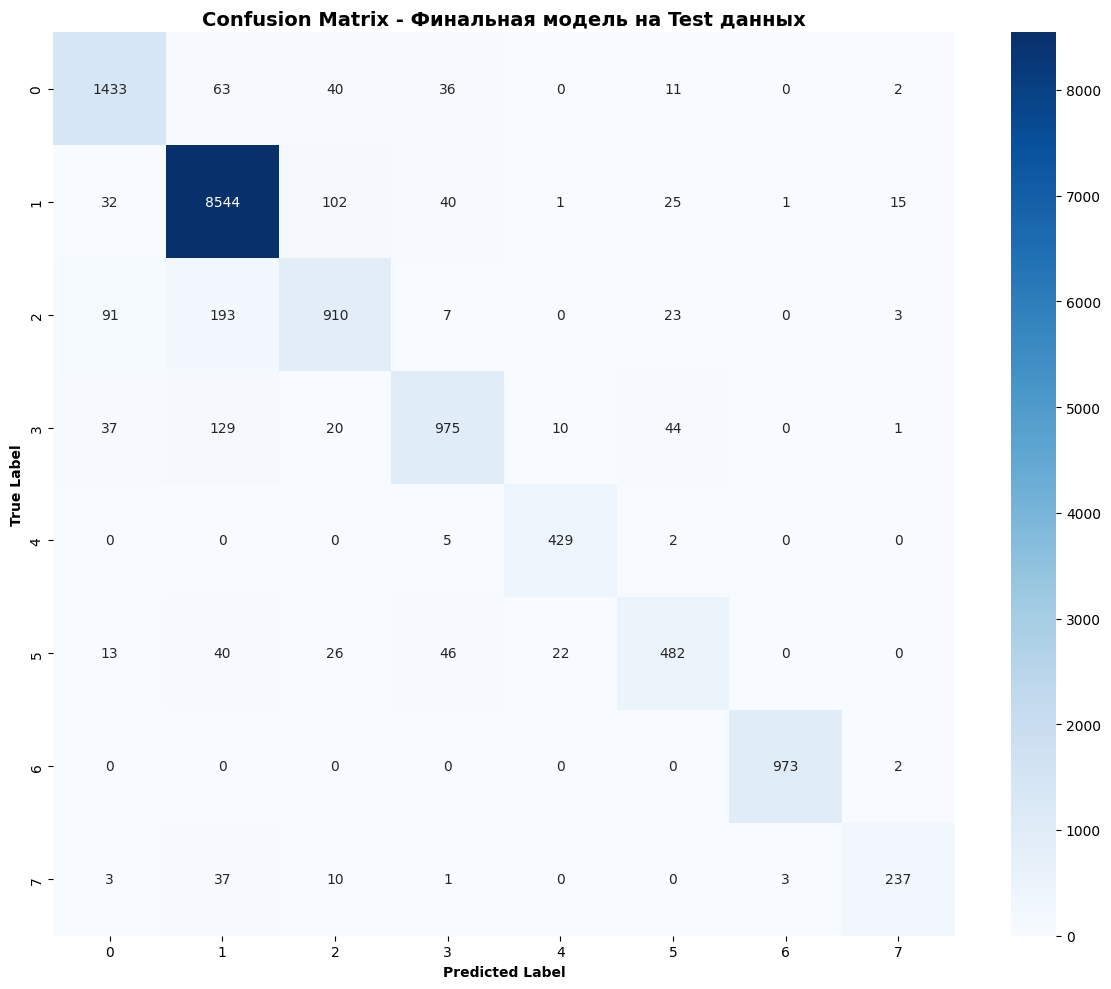

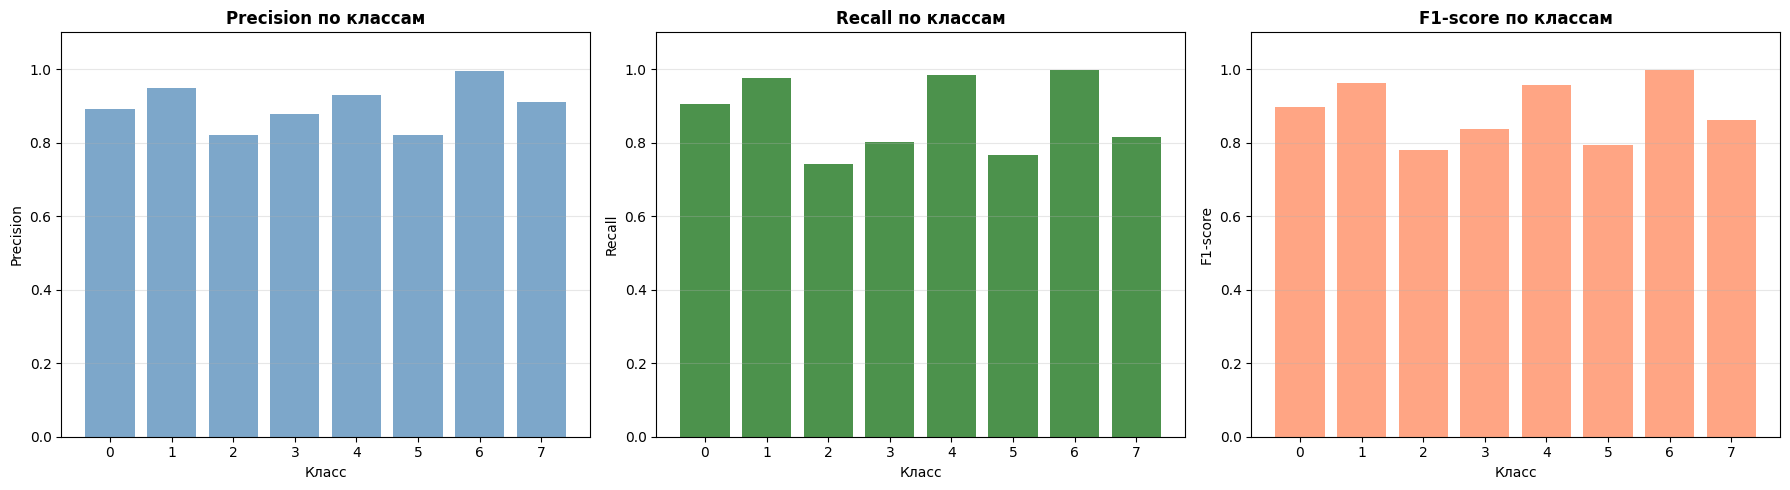

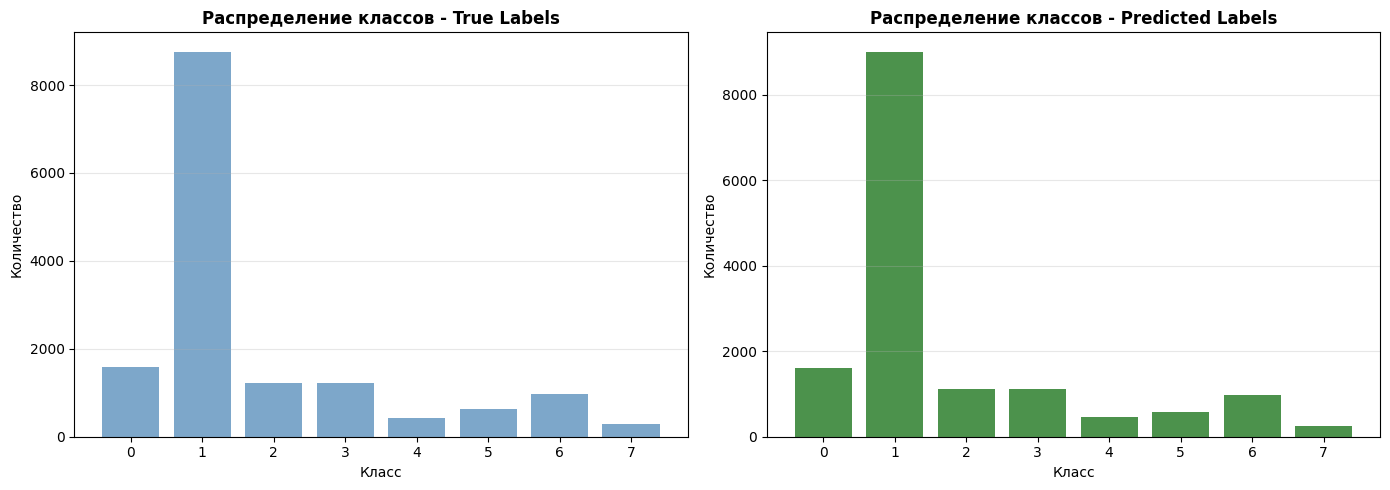


ИТОГОВЫЙ ВЫВОД

✅ Анализ финальной модели завершен!

📊 Ключевые метрики:
   Accuracy: 0.9249
   F1-score (weighted): 0.9234
   F1-score (macro): 0.8853

✅ Лучший класс по предсказаниям: 6 (F1-score: 0.9969)

💾 Сохранены переменные:
   - test_results: словарь с общими метриками
   - test_metrics_per_class: DataFrame с метриками по классам
   - test_confusion_matrix: матрица путаницы

🎯 Модель готова для использования в предсказательной системе!


In [75]:
# ================================================================================
# АНАЛИЗ ФИНАЛЬНОЙ МОДЕЛИ НА TEST ДАННЫХ
# ================================================================================
# Оценка финальной модели с оптимальными гиперпараметрами на тестовой выборке
# Полный анализ метрик, confusion matrix, classification report
# ================================================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, 
    precision_recall_fscore_support
)

print("="*80)
print("АНАЛИЗ ФИНАЛЬНОЙ МОДЕЛИ НА TEST ДАННЫХ")
print("="*80)

# Проверяем наличие финальной модели и test данных
if 'best_pipeline_final' not in globals():
    print("⚠️ Финальная модель (best_pipeline_final) не найдена.")
    print("   Пожалуйста, выполните ячейку с оптимизацией гиперпараметров.")
elif 'X_test' not in globals() or 'y_test' not in globals():
    print("⚠️ Test данные (X_test, y_test) не найдены.")
    print("   Пожалуйста, выполните ячейку с разделением данных.")
else:
    print(f"\n📊 Информация о данных:")
    print(f"   Test выборка: {X_test.shape[0]} записей")
    print(f"   Количество признаков: {X_test.shape[1]}")
    print(f"   Количество классов: {y_test.nunique()}")
    
    # Получаем информацию о модели
    if 'best_hyperparameters' in globals():
        print(f"\n📋 Информация о модели:")
        print(f"   Модель: {best_hyperparameters.get('model', 'Unknown')}")
        print(f"   Лучший CV score: {best_hyperparameters.get('best_score', 'N/A'):.4f}")
        print(f"   Время обучения: {best_hyperparameters.get('training_time_formatted', 'N/A')}")
    
    print(f"\n" + "="*80)
    print("ПРЕДСКАЗАНИЯ НА TEST ДАННЫХ")
    print("="*80)
    
    # Делаем предсказания
    print(f"\n⏳ Выполнение предсказаний...")
    y_test_pred = best_pipeline_final.predict(X_test)
    y_test_pred_proba = best_pipeline_final.predict_proba(X_test)
    
    print(f"   ✅ Предсказания выполнены!")
    
    print(f"\n" + "="*80)
    print("РЕЗУЛЬТАТЫ НА TEST ДАННЫХ")
    print("="*80)
    
    # Вычисляем метрики
    accuracy = accuracy_score(y_test, y_test_pred)
    precision_macro = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    recall_macro = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    recall_weighted = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
    # Метрики по классам
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test, y_test_pred, zero_division=0
    )
    
    print(f"\n📊 Общие метрики на Test данных:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision (macro): {precision_macro:.4f}")
    print(f"   Precision (weighted): {precision_weighted:.4f}")
    print(f"   Recall (macro): {recall_macro:.4f}")
    print(f"   Recall (weighted): {recall_weighted:.4f}")
    print(f"   F1-score (macro): {f1_macro:.4f}")
    print(f"   F1-score (weighted): {f1_weighted:.4f}")
    
    # Classification Report
    print(f"\n" + "="*80)
    print("CLASSIFICATION REPORT")
    print("="*80)
    print(classification_report(y_test, y_test_pred, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    print(f"\n" + "="*80)
    print("CONFUSION MATRIX")
    print("="*80)
    print(f"\nМатрица путаницы (Confusion Matrix):")
    print(cm)
    
    # Детальный анализ по классам
    print(f"\n" + "="*80)
    print("ДЕТАЛЬНЫЙ АНАЛИЗ ПО КЛАССАМ")
    print("="*80)
    
    class_names = sorted(y_test.unique())
    metrics_per_class = pd.DataFrame({
        'Class': class_names,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-score': f1_per_class,
        'Support': support_per_class
    })
    
    print(f"\n📊 Метрики по классам:")
    print(metrics_per_class.to_string(index=False))
    
    # Визуализация результатов
    print(f"\n📈 Создание визуализаций...")
    
    # 1. Confusion Matrix Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Финальная модель на Test данных', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 2. Метрики по классам
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    x_pos = np.arange(len(class_names))
    
    axes[0].bar(x_pos, metrics_per_class['Precision'], color='steelblue', alpha=0.7)
    axes[0].set_title('Precision по классам', fontweight='bold')
    axes[0].set_xlabel('Класс')
    axes[0].set_ylabel('Precision')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(class_names)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim([0, 1.1])
    
    axes[1].bar(x_pos, metrics_per_class['Recall'], color='darkgreen', alpha=0.7)
    axes[1].set_title('Recall по классам', fontweight='bold')
    axes[1].set_xlabel('Класс')
    axes[1].set_ylabel('Recall')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(class_names)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_ylim([0, 1.1])
    
    axes[2].bar(x_pos, metrics_per_class['F1-score'], color='coral', alpha=0.7)
    axes[2].set_title('F1-score по классам', fontweight='bold')
    axes[2].set_xlabel('Класс')
    axes[2].set_ylabel('F1-score')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(class_names)
    axes[2].grid(axis='y', alpha=0.3)
    axes[2].set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.show()
    
    # 3. Сравнение распределения классов (True vs Predicted)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    true_dist = pd.Series(y_test).value_counts().sort_index()
    pred_dist = pd.Series(y_test_pred).value_counts().sort_index()
    
    axes[0].bar(true_dist.index.astype(str), true_dist.values, color='steelblue', alpha=0.7)
    axes[0].set_title('Распределение классов - True Labels', fontweight='bold')
    axes[0].set_xlabel('Класс')
    axes[0].set_ylabel('Количество')
    axes[0].grid(axis='y', alpha=0.3)
    
    axes[1].bar(pred_dist.index.astype(str), pred_dist.values, color='darkgreen', alpha=0.7)
    axes[1].set_title('Распределение классов - Predicted Labels', fontweight='bold')
    axes[1].set_xlabel('Класс')
    axes[1].set_ylabel('Количество')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Сохраняем результаты анализа
    test_results = {
        'accuracy': float(accuracy),
        'precision_macro': float(precision_macro),
        'precision_weighted': float(precision_weighted),
        'recall_macro': float(recall_macro),
        'recall_weighted': float(recall_weighted),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'test_samples': int(len(y_test)),
        'n_classes': int(y_test.nunique())
    }
    
    # Добавляем метрики по классам
    test_results['per_class_metrics'] = metrics_per_class.to_dict('records')
    
    # Сохраняем в глобальные переменные
    globals()['test_results'] = test_results
    globals()['test_metrics_per_class'] = metrics_per_class
    globals()['test_confusion_matrix'] = cm
    
    print(f"\n" + "="*80)
    print("ИТОГОВЫЙ ВЫВОД")
    print("="*80)
    
    print(f"\n✅ Анализ финальной модели завершен!")
    print(f"\n📊 Ключевые метрики:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-score (weighted): {f1_weighted:.4f}")
    print(f"   F1-score (macro): {f1_macro:.4f}")
    
    # Определяем самый проблемный класс (низкий F1-score)
    worst_class_idx = metrics_per_class['F1-score'].idxmin()
    worst_class = metrics_per_class.loc[worst_class_idx, 'Class']
    worst_f1 = metrics_per_class.loc[worst_class_idx, 'F1-score']
    
    if worst_f1 < 0.5:
        print(f"\n⚠️ Самый проблемный класс: {worst_class} (F1-score: {worst_f1:.4f})")
        print(f"   Рекомендуется обратить внимание на улучшение предсказаний для этого класса.")
    
    # Определяем лучший класс
    best_class_idx = metrics_per_class['F1-score'].idxmax()
    best_class = metrics_per_class.loc[best_class_idx, 'Class']
    best_f1 = metrics_per_class.loc[best_class_idx, 'F1-score']
    print(f"\n✅ Лучший класс по предсказаниям: {best_class} (F1-score: {best_f1:.4f})")
    
    print(f"\n💾 Сохранены переменные:")
    print(f"   - test_results: словарь с общими метриками")
    print(f"   - test_metrics_per_class: DataFrame с метриками по классам")
    print(f"   - test_confusion_matrix: матрица путаницы")
    
    print(f"\n🎯 Модель готова для использования в предсказательной системе!")


In [ ]:
# ================================================================================
# СОХРАНЕНИЕ МОДЕЛИ ДЛЯ STREAMLIT ПРИЛОЖЕНИЯ
# ================================================================================
# Сохраняем обученную модель в файл для использования в Streamlit приложении
# ================================================================================

import joblib

print("="*80)
print("СОХРАНЕНИЕ МОДЕЛИ ДЛЯ ПРЕДСКАЗАТЕЛЬНОЙ СИСТЕМЫ")
print("="*80)

# Проверяем наличие финальной модели
if 'best_pipeline_final' not in globals():
    print("⚠️ Финальная модель (best_pipeline_final) не найдена.")
    print("   Пожалуйста, выполните ячейку с оптимизацией гиперпараметров.")
else:
    try:
        # Сохраняем модель
        model_filename = 'best_pipeline_final.pkl'
        joblib.dump(best_pipeline_final, model_filename)
        
        print(f"\n✅ Модель успешно сохранена в файл: {model_filename}")
        print(f"\n📊 Информация о модели:")
        print(f"   Тип: Pipeline с предобработкой и классификатором")
        print(f"   Компоненты:")
        print(f"     1. Preprocessor (ColumnTransformer)")
        print(f"        - RobustScaler для числовых признаков")
        print(f"        - OneHotEncoder для категориальных признаков")
        print(f"     2. Classifier (Random Forest)")
        
        if 'best_hyperparameters' in globals():
            params = best_hyperparameters.get('best_params', {})
            print(f"        Параметры:")
            for param, value in params.items():
                print(f"          - {param}: {value}")
        
        print(f"\n💡 Теперь можно запустить Streamlit приложение:")
        print(f"   streamlit run streamlit_app.py")
        
        print(f"\n✅ Модель готова к использованию в предсказательной системе!")
        
    except Exception as e:
        print(f"\n❌ Ошибка при сохранении модели: {str(e)}")
        import traceback
        traceback.print_exc()
